# Direct Collapse Black Holes from Axion Decay

This file models DCBHs from axions decay

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
 %reload_ext autoreload

In [22]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from physics import definitions as phys

import matplotlib
# import integrators
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import quad_vec
from scipy.integrate import simpson

# import derivatives
from scipy.misc import derivative
# import interpolator
from scipy.interpolate import interp1d
# import system solver 
from scipy.optimize import fsolve
from scipy.misc import derivative

# import ODE solver
from scipy.integrate import solve_ivp

# import pandas for cosmic variance
import pandas as pd

# import h5py for large file management 
import h5py

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

from scipy.misc import derivative

In [23]:
# Run this for pretty graphs :)

import matplotlib
matplotlib.rc_file('matplotlibrc')

In [24]:
# Get the default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Print the colors
print(default_colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [25]:
# Import halo mod 
import hmf
import halomod
from halomod import TracerHaloModel

# I. IGM Mean Intensity

Calculate mean intensity from the IGM. This includes flux attenuation due HI line opacities above $n \geq 3$ Lyman lines.

In [26]:
# Axion Decay rate (s^-1)
def gamma_decay(ma,ga):
    """
    ma - eV
    ga - GeV^(-1)
    output - decay rate s^(-1)
    """
    return (ma*1e-9)**3 * ga**2 *phys.GeV_To_InvSec/(64*np.pi)

# A list containing Hydrogen n>=3 levels
H_levels = phys.lyman_np_level(np.arange(3,25))


In [27]:
1/gamma_decay(500,4e-15)

6.613879270715351e+25

In [28]:
def closest_below(arr, val):
    """
    Function that inputs a list 'arr' and a value 'val' and outputs the largest value smaller than val in the list.
    
    """
    arr = np.asarray(arr)
    val = np.asarray(val)
    
    # Create an output array of the same shape as val to store results
    result = np.full_like(val, np.nan, dtype=float)
    
    for i, v in np.ndenumerate(val):
        # Filter arr to include only elements smaller than the given number
        smaller_elements = arr[arr < v]
        
        # If there are elements smaller than the number, get the maximum element
        if smaller_elements.size > 0:
            result[i] = smaller_elements.max()
    
    return result

In [29]:
# Check
closest_below(H_levels,12.5)

array(12.09394871)

In [30]:
H_levels

array([12.09394871, 12.75533653, 13.06146461, 13.2277564 , 13.32802511,
       13.39310336, 13.43772079, 13.46963538, 13.49324856, 13.51120833,
       13.52518524, 13.5362755 , 13.54522256, 13.55254506, 13.55861378,
       13.56369942, 13.5680034 , 13.57167807, 13.57484039, 13.57758137,
       13.57997265, 13.58207131])

In [31]:
print(12<H_levels[0])

True


Define a function for attenuated intensity

In [32]:
# Define a piecewise function for J_IGM using numpy select

def J_IGM_func(z, ma, ga, energy):

    """ 
    energy in eV. 

    Output: Mean IGM intensity [ergs s^(-1) cm^(-1) Hz^(-1) str^(-1)]
    """

    ma = np.asarray(ma)
    energy = np.asarray(energy)
    
    closest_val = closest_below(H_levels, ma/2)

    # Define conditions for intensity
    conditions = [
        (ma/2 < H_levels[0]) & (energy<=ma/2),
        (H_levels[0] <= ma/2) & (energy >= closest_val) & (energy <= ma/2),
        (energy >= ma/2)
    ]

    # Define functions for these conditions
    functions=[
         (2 * phys.cs * phys.h_planck * phys.eV_to_ergs) / (4 * np.pi * phys.Hubble(z)) * \
            (phys.RhoCrit * phys.Omega_c * (1 + z) ** 3) / ma * gamma_decay(ma, ga) * \
            (2 * energy / ma) ** 1.5,
         (2 * phys.cs * phys.h_planck * phys.eV_to_ergs) / (4 * np.pi * phys.Hubble(z)) * \
            (phys.RhoCrit * phys.Omega_c * (1 + z) ** 3) / ma * gamma_decay(ma, ga) * \
            (2 * energy / ma) ** 1.5,
        0
    ]
    
    # Define intensity value for choice of inputs
    results = np.select(conditions, functions, default=0)

    return results

J_IGM = np.vectorize(J_IGM_func)
    

In [33]:
# Test with scalar inputs
scalar_result = J_IGM(20,25,1e-11,25/2)
print(f"Scalar result: {scalar_result}")

Scalar result: 1.486175598272882e-18


In [34]:
# Test with ma vector results
ma_ray=np.array([20,22,24,25.5])

J_IGM_func(20, ma_ray, 1e-11, 25/2)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.50096378e-18])

In [212]:
J_IGM(10,25,3e-12, 25/2) /1e-21

np.float64(50.67188375609231)

Add a small module that estimates the local halo contribution

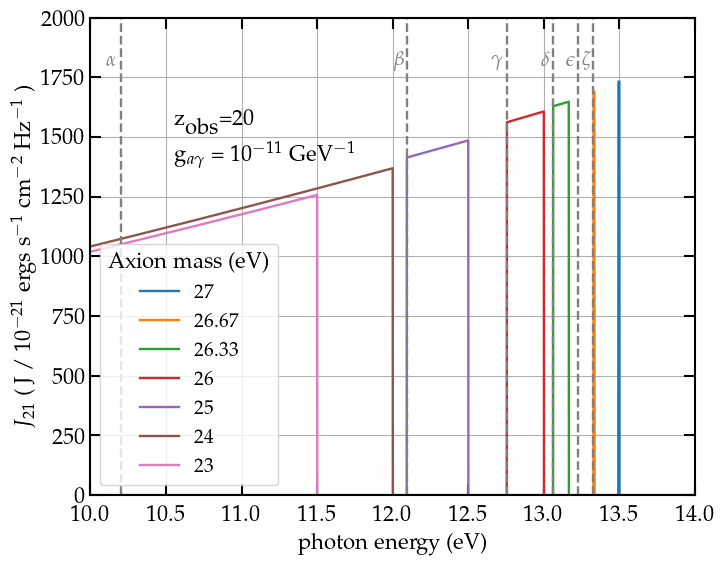

In [35]:
# Plot J IGM for different axion masses
plt.figure(figsize=(7.8, 6.2))

en_space=np.arange(10,14.1,0.001)

plt.plot(en_space, 1e+21*J_IGM(20,27,1e-11, en_space), label=r'27')
plt.plot(en_space, 1e+21*J_IGM(20,26.67,1e-11, en_space), label=r'26.67')
plt.plot(en_space, 1e+21*J_IGM(20,26.33,1e-11, en_space), label=r'26.33')
plt.plot(en_space, 1e+21*J_IGM(20,26,1e-11, en_space), label=r'26')
plt.plot(en_space, 1e+21*J_IGM(20,25,1e-11, en_space), label=r'25')
plt.plot(en_space, 1e+21*J_IGM(20,24,1e-11, en_space), label=r'24')
plt.plot(en_space, 1e+21*J_IGM(20,23,1e-11, en_space), label=r'23')


# Add Lyman Lines 
plt.axvline(x=10.2, color='gray', linestyle='--')
plt.axvline(x=H_levels[0], color='gray', linestyle='--')
plt.axvline(x=H_levels[1], color='gray', linestyle='--')
plt.axvline(x=H_levels[2], color='gray', linestyle='--')
plt.axvline(x=H_levels[3], color='gray', linestyle='--')
plt.axvline(x=H_levels[4], color='gray', linestyle='--')


plt.xlabel(r'photon energy (eV)')
plt.ylabel(r'$J_{21}$ ( J / 10$^{-21}$ ergs s$^{-1}$ cm$^{-2}$ Hz$^{-1}$ )')
plt.legend(title = r'Axion mass (eV)',loc='lower left')
plt.grid()

plt.xlim(10,14)
plt.ylim(0,2000)

plt.text(10.55, 1550, r'z$_\textnormal{obs}$=20', fontsize=16)
plt.text(10.55, 1400, r'g$_{a \gamma}$ = 10$^{-11}$ GeV$^{-1}$', fontsize=16)


# Add labels for Lyman lines 
plt.text(10.1, 1800, r'$\alpha$', fontsize=14, color='gray')
plt.text(12, 1800, r'$\beta$', fontsize=14, color='gray')
plt.text(12.65, 1800, r'$\gamma$', fontsize=14, color='gray')
plt.text(12.98, 1800, r'$\delta$', fontsize=14, color='gray')
plt.text(13.15, 1800, r'$\epsilon$', fontsize=14, color='gray')
plt.text(13.25, 1800, r'$\zeta$', fontsize=14, color='gray')


# Save before show
plt.savefig('./plots/J21_at_z20.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

In [36]:
J_IGM(10, 25, 2e-13, 25/2) / 1e-21

np.float64(0.22520837224929918)

## 1. Define Dissociation Rate Functions

In [37]:
# Define a simple function for Lyman Werner radiation 

def k_LW_func(z, ma, ga):
    """
    Old function to calculate Lyman-Werner dissociation rate. See AxionDecay part for new function. 
    """
    
    ma = np.asanyarray(ma)
    const = 1.39e-12 * 1e+21/2
    closest_val = closest_below(H_levels, ma/2)

    # Define conditions for LW dissociation
    conditions=[
        (ma/2>=11.5) & (ma/2<H_levels[0]),
        (ma/2 >=H_levels[0]) & (ma/2 < phys.rydberg_energy),
        (ma/2 <11.5) & (ma/2>= phys.rydberg_energy)
    ]

    # Define dissociation rate values
    functions = [
        const*J_IGM(z,ma,ga,ma/2)*(ma/2 - 11.5)/2.1,
        const*J_IGM(z,ma,ga,ma/2)*(ma/2 - closest_val)/2.1,
        0
    ]

    # Define intensity value for choice of inputs
    results = np.select(conditions, functions, default=0)

    return results

k_LW = np.vectorize(k_LW_func)
                

In [38]:
k_LW(20,24,1e-11)

array(2.26646025e-10)

In [39]:
# Define a function for photodetachment

"""
Here use quad_vec function in the scipy.integrate library. 
This is suited for integration over functions with varying parameters, but makes the code inefficient.
This is probably the part with highest computation time.
"""

def k_pd_func(z, ma, ga):
    """ 
    Old function to calculate dissocitation photo-detachment rate. See axion decay part to see the new one. 
    """
    ma=np.asarray(ma)
    z=np.asarray(z)
    ga=np.asarray(ga)

    # Define a precursory constant
    const = 4*np.pi/(phys.h_planck * phys.eV_to_ergs)

    # Define a function for integration
    function = lambda en: const*J_IGM(z, ma, ga, en)*phys.sigma_Hm(en)/en

    result, error = quad_vec(function, 0.755, ma/2)

    return result

k_pd = np.vectorize(k_pd_func)

In [40]:
%%timeit
k_pd(20, 25, 1e-11)

226 ms ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
k_pd(np.array([20]),np.array([25]),1e-11)

array([4.03811079e-10])

In [42]:
J_IGM(20,24.25,3e-12,12.1) /1e-21

np.float64(125.46180715086368)

In [43]:
k_pd(np.array([20]),np.array([2,4,6,8,10,25]),1e-11)

array([5.50019513e-11, 1.24836004e-09, 3.06036530e-09, 5.04542249e-09,
       7.07825847e-09, 4.03811079e-10])

Now plot the dissociation rate coefficients

In [44]:
ma_space = 2*np.linspace(11,13.55,5000)
k_LW_20 = k_LW(20, ma_space, 1e-11)
k_LW_40 = k_LW(40, ma_space, 1e-11)
k_LW_60 = k_LW(60, ma_space, 1e-11)

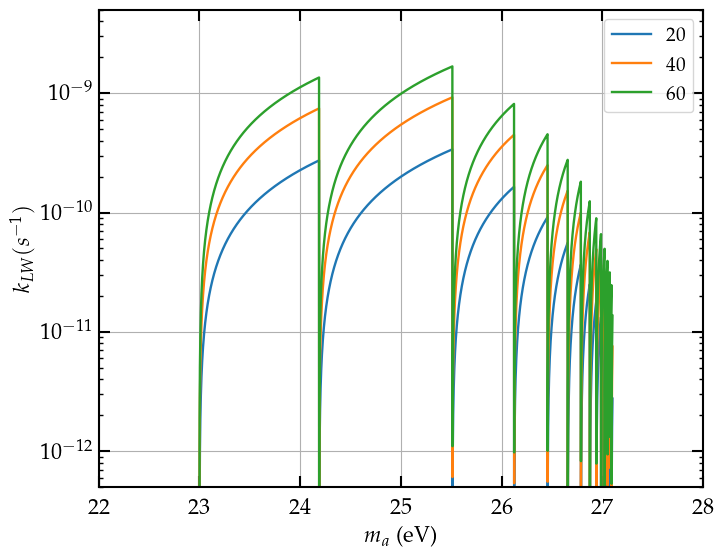

In [45]:
plt.figure(figsize=(7.8, 6.2))
plt.plot(ma_space, k_LW_20, label=r'20')
plt.plot(ma_space, k_LW_40, label=r'40')
plt.plot(ma_space, k_LW_60, label=r'60')

plt.yscale('log')
plt.xlim(22,28)
plt.ylim(5e-13, 5e-9)
plt.xlabel(r'$m_a$ (eV)')
plt.ylabel(r'$k_{LW} (s^{-1})$')
plt.legend()
plt.grid()
plt.show()

In [46]:
list1 = 2*np.linspace(0.755,10.95,100)
list2 = 2*np.linspace(11,13.59,250)

ma_list = np.concatenate((list1,list2))

In [47]:
%%time
k_pd_20 = k_pd (20, ma_list, 1e-11)

CPU times: user 18.4 s, sys: 90.6 ms, total: 18.5 s
Wall time: 18.9 s


In [48]:
k_pd_40 = k_pd (40, ma_list, 1e-11)
k_pd_60 = k_pd (60, ma_list, 1e-11)

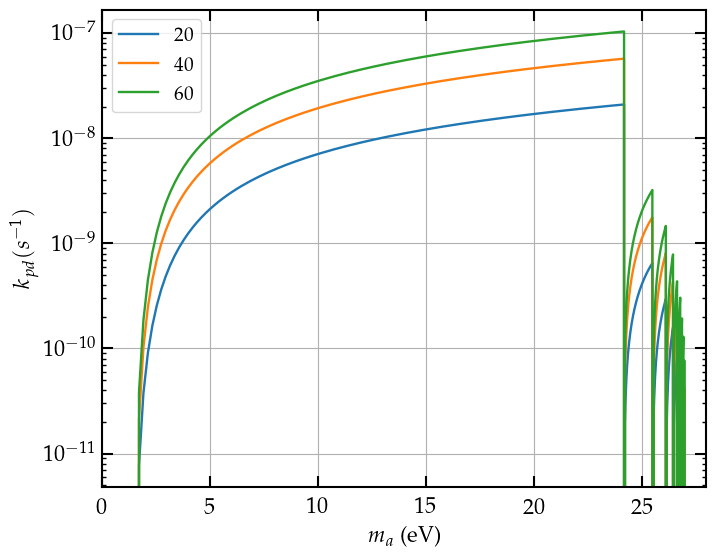

In [49]:
plt.figure(figsize=(7.8, 6.2))
plt.plot(ma_list,k_pd_20, label=r'20')
plt.plot(ma_list,k_pd_40, label=r'40')
plt.plot(ma_list,k_pd_60, label=r'60')

plt.yscale('log')
plt.xlabel(r'$m_a$ (eV)')
plt.ylabel(r'$k_{pd} (s^{-1})$')
plt.xlim(0,28)
plt.grid()
plt.legend()
plt.show()

# II.Toy Halo Model

In this section of the code, we describe a toy halo model. This includes behavior of dark matter, baryons, and temperature evolution in the standard picture.

We first begin with behavior of dark matter. In this case, we use Mass Accretion Histories, based on Extended Press-Schechter, described in [Correa 2015](https://academic.oup.com/mnras/article/450/2/1514/982398). The mass of a halo at any redshift may be written as:
$$
M_H (z) = M_0 (1+z)^{a f(M_0)} \exp{(f(M_0)z)} \ .
$$
Here, $M_0 \equiv M_\text{Halo}(z=0)$ is the only free parameter. The cosmology is encoded in $a$ and $f(M_0)$ via the growth factor $D(z)$, and the variance of the cosmic density field $\sigma(M)$ today (see eq.19-23 in [Correa 2015](https://academic.oup.com/mnras/article/450/2/1514/982398)).

Here, the cosmology is accordance to Planck 2018 parameters.


### 1. Dark Matter

In [50]:
# Read the csv file in physics folder
var_path='./physics/Variance2.0.csv'
var_data=pd.read_csv(var_path, header=None, delimiter=',', lineterminator='\n')

In [51]:
pd.DataFrame(var_data)

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,1.000000e-09,1.020000e-09,1.050000e-09,1.070000e-09,1.100000e-09,1.120000e-09,1.150000e-09,1.170000e-09,1.200000e-09,1.230000e-09,...,7.940000e+15,8.130000e+15,8.320000e+15,8.510000e+15,8.710000e+15,8.910000e+15,9.120000e+15,9.330000e+15,9.550000e+15,9.770000e+15
1,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,7.350000e+01,...,2.900000e-01,2.880000e-01,2.860000e-01,2.840000e-01,2.820000e-01,2.800000e-01,2.780000e-01,2.750000e-01,2.730000e-01,2.710000e-01


In [52]:
# Create Data frames for each row - Row 1: mass, and Row 2: variance.

mass_list = var_data.iloc[0]/phys.h
var_list = var_data.iloc[1]

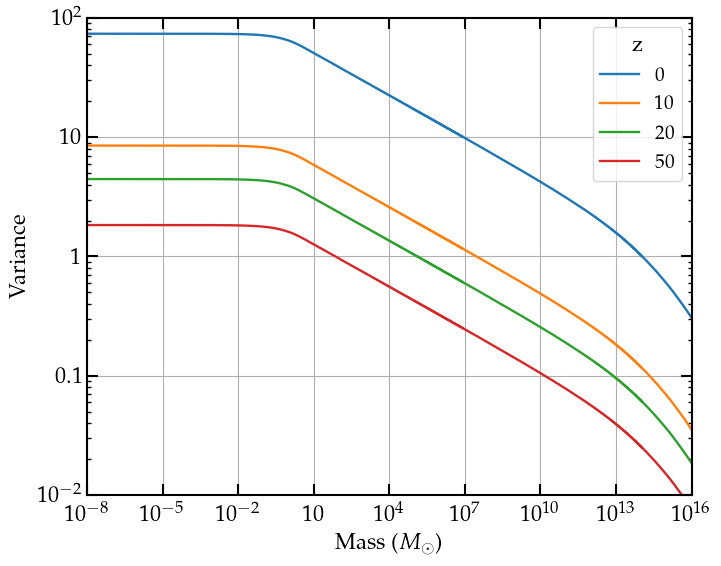

In [53]:
# Plot the variance

plt.figure(figsize=(7.8, 6.2))
plt.plot(mass_list, var_list, label=r'0')
plt.plot(mass_list, phys.growth_fac(10)*var_list, label=r'10')
plt.plot(mass_list, phys.growth_fac(20)*var_list, label=r'20')
plt.plot(mass_list, phys.growth_fac(50)*var_list, label=r'50')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('Variance')
plt.ylim(0.01,100)
plt.xlim(1e-8, 1e+16)
plt.legend(title='z')
plt.grid()

plt.savefig('./plots/variance.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

# This works

In [54]:
# Create a simple interpolator

cosmic_variance = interp1d(mass_list, var_list, kind='linear')

In [55]:
cosmic_variance(np.array([1e-5,1e+6]))

array([73.5       , 12.91333333])

In [56]:
cosmic_variance(1e+13)

array(1.58)

A good test of the cosmic variance plot is to reproduce $\sigma_8 = 0.811 \pm 0.005$ value from Planck 2018 data.

In [57]:
# Define mass corresponding to 8 h^(-1) Mpc scale of the universe
mass_8 = 4 * np.pi / 3 * 2.8e+11 * phys.Omega_m * phys.h**2 * (8/phys.h)**3

In [58]:
mass_8/1e+10

27928.454362547553

In [59]:
# Cosmic Variance
cosmic_variance(mass_8)

array(0.81420977)

In [60]:
# Take derivative of growth factor 
D_0 = derivative(phys.growth_fac, 0, dx = 1e-6)

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/1385999493.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  D_0 = derivative(phys.growth_fac, 0, dx = 1e-6)


In [61]:
print(D_0)

-0.5127221938128201


Agrees Well!

In [62]:
"""
Define parameters from Correa 2015.
Growth factor is defined in definitions file.
Since we only need the derivative at z=0 it is simpler to import the value from mathematica
"""
#derivative of growth factor at z=0.
d_growth_0 = -0.512722

afac = d_growth_0*1.686*(2/np.pi)**0.5 + 1

def zfac(m0):
    return -0.0064*np.log10(m0)**2 + 0.0237*np.log10(m0) + 1.8837

def qfac(zf):
    return 4.137*zf**(-0.9476)

def ffac(m0):
    n1 = zfac(m0)
    n2 = qfac(n1)

    val1 = cosmic_variance(m0/n2)
    val2 = cosmic_variance(m0)

    return (val1**2 - val2**2)**(-1/2)


In [63]:
qfac(zfac(1e+12))

np.float64(3.357434228492294)

In [64]:
cosmic_variance(1e+10)**2

np.float64(17.819655111111107)

In [65]:
ffac(1e+12)

np.float64(0.6866500928311647)

(10000000000.0, 100000000000000.0)

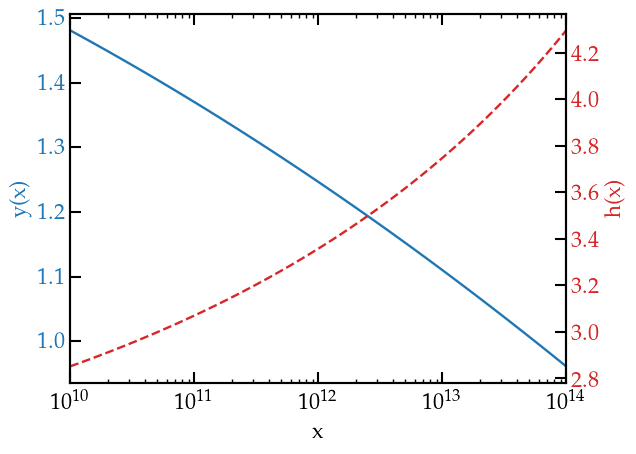

In [66]:
m_scale = 10**np.linspace(10,14,100)

# Create first axis
fig, ax1 = plt.subplots()

# Plot y(x) on left y-axis
color = 'tab:blue'
ax1.set_xlabel('x')
ax1.set_ylabel('y(x)', color=color)
ax1.plot(m_scale, zfac(m_scale), color=color, label='y(x)')
ax1.tick_params(axis='y', labelcolor=color)

# Log scale for x-axis
ax1.set_xscale('log')

# Create second axis (sharing the same x-axis)
ax2 = ax1.twinx()

# Plot h(x) on right y-axis
color = 'tab:red'
ax2.set_ylabel('h(x)', color=color)
ax2.plot(m_scale, qfac(zfac(m_scale)), color=color, linestyle='--', label='h(x)')
ax2.tick_params(axis='y', labelcolor=color)


plt.xlim(1e+10, 1e+14)

In [67]:
# With the parameters defined now define mass accretion histories

def MAH(M0 , z):
    return M0 * (1+z)**(afac*ffac(M0)) * np.exp(-ffac(M0)*z)

In [68]:
phys.Tvir(10, MAH(1e+9,10)) 

np.float64(10347.705709124864)

### 2. Intensity from within the Halo 

In this sub-section, I calculate the LW intensity which comes from axion decay internal to halos. 

In [69]:
# Define D factor 
def D_halo (z, mhalo): 

    # Define halo concentration parameter
    ch = 4 

    # Define NFW density parameter in msol/pc^3
    rho0 = mhalo * ch**3 / (4 * np.pi * phys.Rvir(z, mhalo)**3 * (np.log(1 + ch) - ch/(1+ch) ) )

    # Convert density parameter to eV/cm^3 
    rho0 = rho0 * phys.msol_to_grams * phys.cs**2 /phys.eV_to_ergs / phys.pc_to_cm**3

    # Here r_min is set to 1e-4 pc 
    # Define D_halo eV/cm^2
    result = ( rho0*phys.Rvir(z, mhalo)*phys.pc_to_cm/ch * 
              (1 / (ch+1) - 1 + np.log( phys.Rvir(z, mhalo) / 1e-4 / (ch+1)) )
             )

    return result

def J_halo (z, ma, ga, energy): 

    # Take fiducial model of M_0 = 1e+9 
    result = ( phys.h_planck * gamma_decay(ma,ga) * (ma/2 * 0.833) / (4* np.pi * ma) * 
              D_halo(z, MAH(1e+9,z)) *phys.eV_to_ergs ) 

    return result

In [70]:
D_halo (30, 1e+6) / 1e+9

np.float64(1.943698756173223e+23)

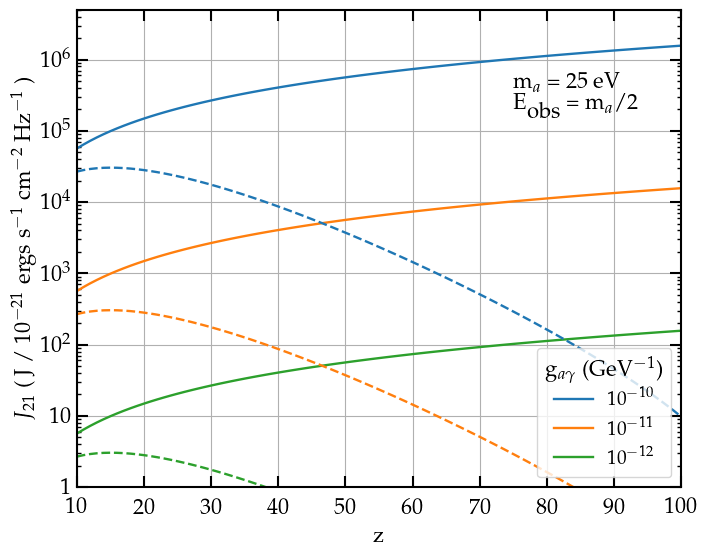

In [71]:
# Plot J_IGM vs z
plt.figure(figsize=(7.8, 6.2))

z_space = np.arange(10,101)

plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-10, 25/2), label=r'$10^{-10}$')
plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-11, 25/2), label=r'$10^{-11}$')
plt.plot(z_space, 1e+21*J_IGM(z_space, 25,1e-12, 25/2), label=r'$10^{-12}$')

# Plot Halo intensities 
plt.plot(z_space, 1e+21*J_halo (z_space, 25, 1e-10, 25/2), color=default_colors[0], linestyle='dashed')
plt.plot(z_space, 1e+21*J_halo (z_space, 25, 1e-11, 25/2), color=default_colors[1], linestyle='dashed')
plt.plot(z_space, 1e+21*J_halo (z_space, 25, 1e-12, 25/2), color=default_colors[2], linestyle='dashed')

plt.yscale('log')
plt.xlabel(r'z')
plt.ylabel(r'$J_{21}$ ( J / 10$^{-21}$ ergs s$^{-1}$ cm$^{-2}$ Hz$^{-1}$ )')
plt.legend(title=r'g$_{a \gamma}$ (GeV$^{-1}$)')

plt.text(75, 4e+5, r'm$_a$ = 25 eV',fontsize=16)
plt.text(75, 2e+5, r'E$_\textnormal{obs}$ = m$_a$/2',fontsize=16)

linestyle_legend = plt.legend(
    handles=[
            Line2D([0], [0], color=default_colors[0], label =r'$10^{-10}$' ), 
            Line2D([0], [0], color=default_colors[1], label =r'$10^{-11}$' ),
            Line2D([0], [0], color=default_colors[2], label =r'$10^{-12}$' )
            ],
    title=r'g$_{a \gamma}$ (GeV$^{-1}$)',
    loc="lower right"
)

plt.xlim(10,100)
plt.ylim(1,5e+6)

plt.grid()

# save figure
plt.savefig('./plots/J21_25eV.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

The plot clearly shows that intensity from IGM dominates intensity from internal decays. 

### 3. Baryons

The density evolution of baryons in halos is goverened by Jeans/filtering mass criteria if there are no extra cooling or heating terms. The filtering mass can be written as (with no streaming velocity) [Hegde 2023](https://inspirehep.net/literature/2650114)
$$
 M_F = 1.66 \times 10^4 \left(\frac{1 + z}{21} \right)^{0.85} \ M_\odot
$$

In [72]:
def filter_mass(z):
    return 1.66e+4 * ((1+z)/21)**(0.85)

In [73]:
filter_mass(21)

17269.54781676384

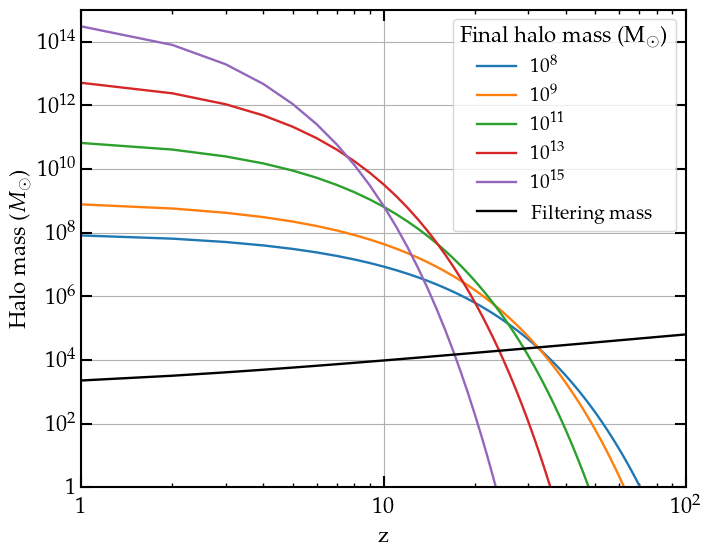

In [74]:
# Plot histories for a few final halo masses: 1e+9, 1e+11.5, 1e+14
z_list=np.arange(0,101)

plt.figure(figsize=(7.8, 6.2))

plt.plot(z_list, MAH(1e+8,z_list), label=r'$10^{8}$')
plt.plot(z_list, MAH(1e+9,z_list), label=r'$10^{9}$')
plt.plot(z_list, MAH(1e+11,z_list), label=r'$10^{11}$')
plt.plot(z_list, MAH(1e+13,z_list), label=r'$10^{13}$')
plt.plot(z_list, MAH(1e+15,z_list), label=r'$10^{15}$')
plt.plot(z_list, filter_mass(z_list), label='Filtering mass', color='black')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'Halo mass ($M_\odot$)')
plt.xlim(1,100)
plt.ylim(1,1e+15)
plt.grid()
plt.legend(title = r'Final halo mass (M$_\odot$)')

plt.savefig('./plots/MAH.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

As one can see from the graph above, smaller halos that collapse earlier also cross the filtering threshold before higher mass halos. 

Now we define virialization redshift i.e. $M_\textnormal{Halo} (M_0, z_\textnormal{vir}) = M_F (z_\textnormal{vir})$

In [75]:
def zvir(M0):
    return fsolve(lambda z: MAH(M0, z) - filter_mass(z), 10)

In [76]:
zvir(1e+8)

array([32.30965386])

In [77]:
MAH(1e+8,31)

np.float64(34703.86313642498)

In [78]:
23772/(1e+6)

0.023772

In [79]:
zvir(1e+9)

array([32.39539417])

### 4. Density evolution

For density evolution, I am using the accurate model based on simulations [Visbal 2014](https://academic.oup.com/mnrasl/article/442/1/L100/955995). Unfortunately, there isn't a smooth way to transition from IGM density to the collapsed density, so I've patched the two pieces together with a sigmoid function with a variable parameter. The results should not be too sensitive to this choice, and so still appropriate for out analysis. 


In [80]:
# Define a base halo model. 
def nH_Halo (k , m0, z):

    """
    k - parameter to sigmoid function
    m0 - final halo mass 

    returns H number density [cm^3 s^(-1)]
    """

    m0 = np.asarray(m0)
    z = np.asarray(z)

    # Calculate redshift of virialization
    z_vir = zvir(m0)

    # Define sigmoid of x
    sigmoid_x = 1 / (1 + np.exp(- k * (z - z_vir) ))

    # z > zvir
    val_1 = phys.nH0*(1+z)**3

    # z <= zvir
    val_2 = 1.2 * MAH(m0,z_vir)/(1e+6) * (( 1+z_vir ) / 10)**(3/2)

    return (sigmoid_x)*val_1 + (1 - sigmoid_x)*val_2


In [81]:
1.2*MAH(1e+9,32.4)*(3.24**1.5)/1e+6

np.float64(0.17206094999830543)

In [82]:
def nH_Halo_crude(zvir, z):

    # Convert arguments to array
    zvir = np.asarray(zvir)
    z = np.asarray(z)
    
    # Define A
    A = (1+zvir)/(1+z)
    # Define conditions for pre and post collapse
    conditions = [
        (z>zvir),
        (z<=zvir)
    ]

    # Define values to return
    funcs=[
        phys.nH0*(1+z)**3 * np.exp((1.9*A) / (1 - 0.75*A**2)),
        ##1.2 * MAH(1e+8,zvir)/(1e+6) * ((1+zvir) / 10)**(3/2)
        phys.nH0*(1+zvir)**3 * np.exp(1.9 / (1 - 0.75))
    ]

    return np.select(conditions, funcs, default=0)

In [83]:
# Now plot halo number density for varying sigmoid parameter
z_list=np.arange(0,101)
zvir_list=np.array([zvir(1e+8),zvir(1e+9),zvir(1e+10), zvir(1e+11), zvir(1e+12), zvir(1e+13), zvir(1e+14), zvir(1e+15), zvir(1e+16) ])

In [84]:
zvir_list[3]

array([29.12567409])

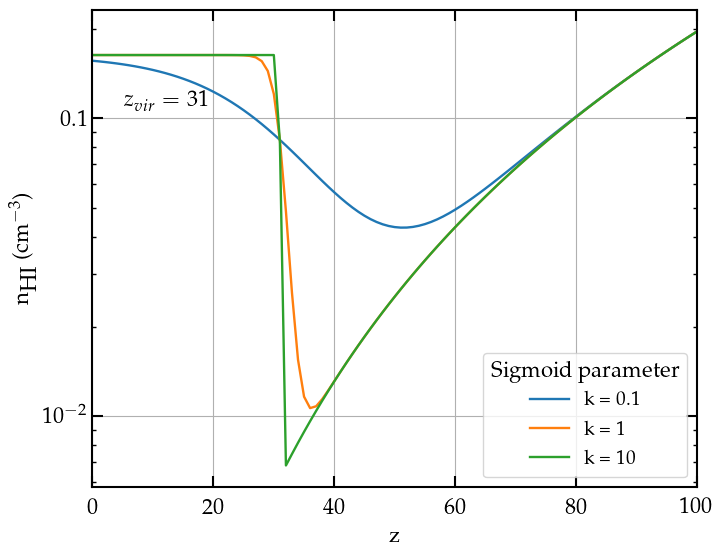

In [85]:
# Plot nH(z) for a few parameters of sigmoid. 
plt.figure(figsize=(7.8, 6.2))
plt.plot(z_list, nH_Halo(0.1, 1e+10, z_list), label = r'k = 0.1')
plt.plot(z_list, nH_Halo(1, 1e+10, z_list), label = r'k = 1')
plt.plot(z_list, nH_Halo(10, 1e+10, z_list),  label = r'k = 10')

plt.yscale('log')
plt.grid()
plt.xlabel('z')
plt.ylabel(r'n$_{\textnormal{HI}}$ (cm$^{-3}$)')
plt.text(5, 1.1e-1, r'$z_{vir} = 31$', fontsize = 16)
plt.legend(title = 'Sigmoid parameter')
plt.xlim(0,100)

plt.savefig('./plots/nH_halo_sigmoid.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [86]:
zvir_list

array([[32.30965386],
       [32.39539417],
       [30.99711393],
       [29.12567409],
       [26.77405637],
       [24.11122311],
       [21.17696416],
       [17.15417609],
       [12.75921769]])

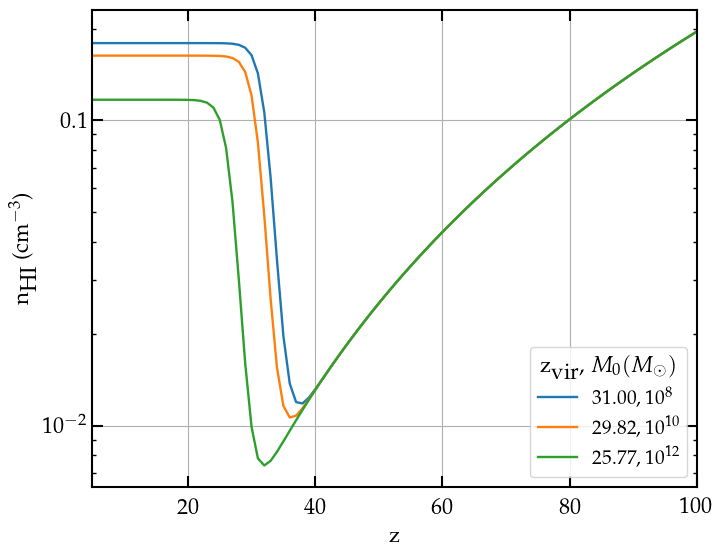

In [87]:
# Plot nH(z) for k = 1, and different zvir 
plt.figure(figsize=(7.8, 6.2))
plt.plot(z_list, nH_Halo(1, 1e+8, z_list), label = r'31.00, $10^8$')
plt.plot(z_list, nH_Halo(1, 1e+10, z_list), label = r'29.82, $10^{10}$')
plt.plot(z_list, nH_Halo(1,1e+12, z_list),  label = r'25.77, $10^{12}$')

plt.yscale('log')
plt.grid()
plt.xlabel('z')
plt.ylabel(r'n$_{\textnormal{HI}}$ (cm$^{-3}$)')
plt.legend(title = r'z$_{\textnormal{vir}}$, $M_0 (M_\odot)$')
plt.xlim(5,1e+2)

plt.savefig('./plots/nH_halo.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [88]:
MAH(1e+8, 10)

np.float64(8509501.268948862)

### 5. Temperature evolution

Since, there are no processes changing temperature of baryonic gas, except changes in H2 chemistry, we can model the temperature in a similar way to number density evolution i.e.

$$ 
 T_{halo} (z) \approx T_{IGM} \ , \ \text{for } z \gtrsim z_{vir}
$$
and
$$ 
T_{halo} (z) \approx T_{vir} \ , \text{for } z \lesssim z_{vir} \ .
$$

In [89]:
# Define a base temperature function 

def T_halo (k, m0, z): 

    """
    k - parameter to sigmoid function
    m0 - final halo mass
    """

    z = np.asarray(z)

    # Define sigmoid of x
    sigmoid_x = 1 / (1 + np.exp(- k * (z - zvir(m0))) )
    
    # z >> zvir
    temp_1 = phys.T_IGM(z)

    # z <= zvir 
    temp_2 = phys.Tvir(z, MAH(m0, z))

    return (sigmoid_x)*temp_1 + (1-sigmoid_x)*temp_2

In [90]:
print(zvir(1e+8), zvir(1e+9), zvir(1e+10), zvir(1e+11), zvir(1e+12), zvir(1e+13), zvir(1e+14))

[32.30965386] [32.39539417] [30.99711393] [29.12567409] [26.77405637] [24.11122311] [21.17696416]


In [91]:
# Atomic cooling limit 
T_atom = np.zeros_like(z_list)
T_atom = T_atom + 1e+4

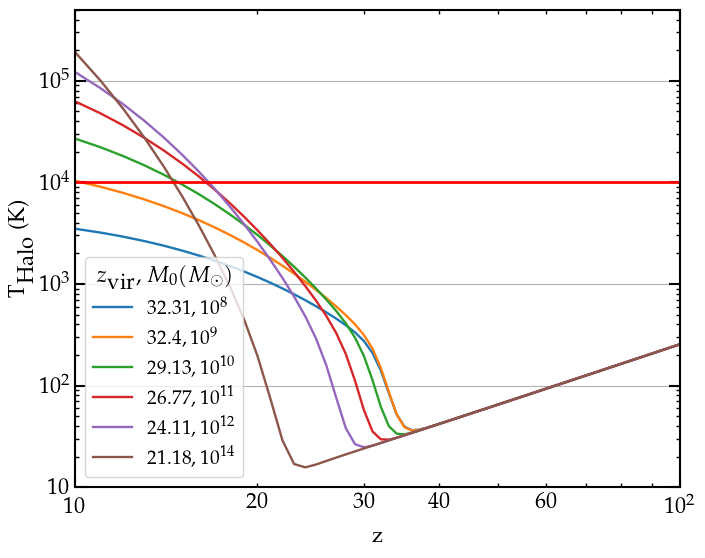

In [92]:
## Plot T_halo(z) for k = 1, and different zvir 
plt.figure(figsize=(7.8, 6.2))

plt.plot(z_list, T_halo(1, 1e+8, z_list), label = r'32.31, $10^{8}$')
plt.plot(z_list, T_halo(1, 1e+9, z_list), label = r'32.4, $10^{9}$')
plt.plot(z_list, T_halo(1, 1e+10, z_list), label = r'29.13, $10^{10}$')
plt.plot(z_list, T_halo(1, 1e+11, z_list), label = r'26.77, $10^{11}$')
plt.plot(z_list, T_halo(1, 1e+12, z_list), label = r'24.11, $10^{12}$')
plt.plot(z_list, T_halo(1, 1e+14, z_list), label = r'21.18, $10^{14}$')

# Plot atomic cooling limit 
plt.plot(z_list, T_atom, color='red', linewidth=2)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.xlabel('z')
plt.ylabel(r'T$_{\textnormal{Halo}}$ (K)')

plt.ylim(1e+1, 5e+5)
plt.xlim(10,1e+2)

plt.legend(title = r'$z_{\textnormal{vir}}$, $M_0 (M_\odot)$')

# Save figure 
plt.savefig('./plots/temp.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

#### (i) Comparing Time Scales

There is some modeling confusion on what the critical $H_2$ fraction is for DCBH formation. To resolve this issue we should compare the relevant time scales in our system: free fall - Hubble time scale (a time scale threshold needed for effective cooling) vs $H_2$ cooling time scale. 

The free fall time scale in the cores of the halo is given as: 
$$ 
\begin{align}
t_{ff} & = \left( \frac{3 \pi}{32 G \bar{\rho}_{core}}\right)^{1/2} \\
    & = 1.5 \times 10^7 \left(\frac{1+z_{vir}}{10}\right)^{-3/2} \ \text{yrs} \ .
\end{align}
$$

On the other hand, $H_2$ cooling time scale is given as 

$$ 
\begin{align}
    t_{cool} = \left( \frac{3 n_{core} k_B T_{vir}}{2 \Lambda (n_{core}, T_{vir})} \right) \ ,
\end{align}
$$

where $\Lambda (n,T)$ is the cooling rate in ergs cm$^{-3}$ s$^{-1}$. 

**Important!**
$T_{vir}$ is the halo temperature at any point along its mass accretion history. Since the virial temperature increases with time, the $H_2$ cooling efficiency changes with time as well, $\Lambda_{H_2} \propto T^{3.4}$. But the density in the core is completely determined by the collapse redshift, $z_{vir}$, and is kept constant afterwards. 

Therefore, the model predicts that the core density stays constant with time after collapse, owing to lack of coolant. But it still experiences heating from mass accretion by the halo. This is ultimately primary mechanism for triggering atomic cooling halos. 


In [93]:
# Define a function for free fall time scale 

def t_ff (zvir): 

    """ returns free fall time scale for a halo virializing/collapsing at zvir"""
    return 1.5e+7 * ((1+zvir)/10)**(-3/2) * phys.yrs_to_sec

In [94]:
print(f'The free fall time scale for z_vir = {zvir(1e+9)[0]:.4} is t_ff = {t_ff (33) /phys.yrs_to_sec:.4} yrs')

The free fall time scale for z_vir = 32.4 is t_ff = 2.393e+06 yrs


In [95]:
# Define a function to calculate H2 cooling time scale 

def t_H2(xH2, ncore, temp): 
    return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H2_cool(xH2, ncore, temp)

In [96]:
print(f'The cooling time scale t_cool = {t_H2(1e-3, 0.1, 3e+3) / phys.yrs_to_sec:.4} yrs')

The cooling time scale t_cool = 8e+06 yrs


#### (ii) Simple test against Mathematica code

This next piece is to simply check against mathematica answers. 

In [97]:
# Define parameters for the base model
m0_base = 1e+11
zvir_base = 28
xe_base = np.array([5e-4]) # Free electron fraction at z~ 100 after recombination

"""
Define differential equation for electron recombination
"""

def dxe_dz_test (z, xe):
    val = (( phys.case_B(3000) * nH_Halo_crude(zvir_base, z) * xe**2) / 
           ((1+z) * phys.Hubble(z)))
    return val
    # T_halo(1, m0_base, z)
# Define redshift range of interest
z_span = (101, 0)
z_eval=np.arange(101,0,-0.1)

# Solve the ODE 

solution_test = solve_ivp(dxe_dz_test, z_span, xe_base, t_eval= z_eval, rtol=1e-10, atol=1e-10 )

<function matplotlib.pyplot.show(close=None, block=None)>

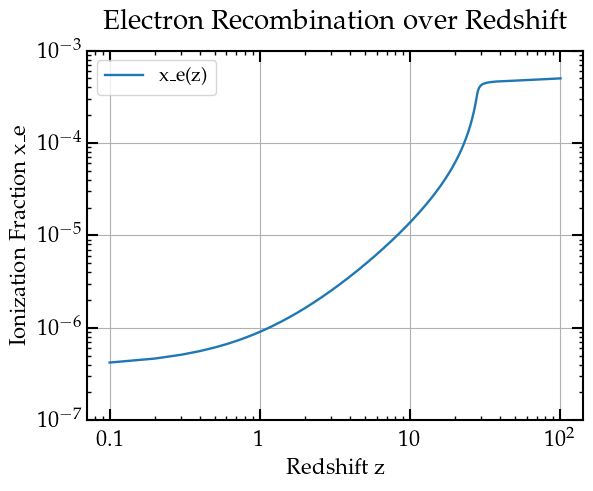

In [98]:
# Plot the results
plt.plot(solution_test.t, solution_test.y[0], label='x_e(z)')
plt.xlabel('Redshift z')
plt.ylabel('Ionization Fraction x_e')
plt.title('Electron Recombination over Redshift')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim(1e-7,1e-3)
plt.grid(True)
plt.show

This part sucessfully reproduces mathematica result. 

# III. Base History

With the halo internal properties defined, we can now model a baseline model for $x_e$ history. To do this let's take $M_0 = 10^{10} \, M_\odot$ and $z_{vir} = 29.82$. Also we can take the free electron fraction at the end of recombination as $2 \times 10^{-4}$.

## 1. Base x_e

In [99]:
# Define parameters for the base model
m0_base = 1e+9
zvir_base = zvir(1e+9)
xe_initial = np.array([2e-4]) # Free electron fraction at z~ 100 after recombination


In [100]:

"""
Define differential equation for electron recombination
"""

def dxe_dz_base (z, xe, m0):
    val = (( phys.case_B(T_halo(1.5, m0, z)) * nH_Halo(1.5, m0, z) * xe**2) / 
           ((1+z) * phys.Hubble(z)))
    return val
    # T_halo(1, m0_base, z)
# Define redshift range of interest
z_span = (120, 0)
z_eval=np.arange(120,0,-0.1)

# Solve the ODE 
solution_base_xe = solve_ivp(dxe_dz_base, z_span, xe_initial, t_eval= z_eval, rtol=1e-10, atol=1e-10, args=(m0_base,) )

<function matplotlib.pyplot.show(close=None, block=None)>

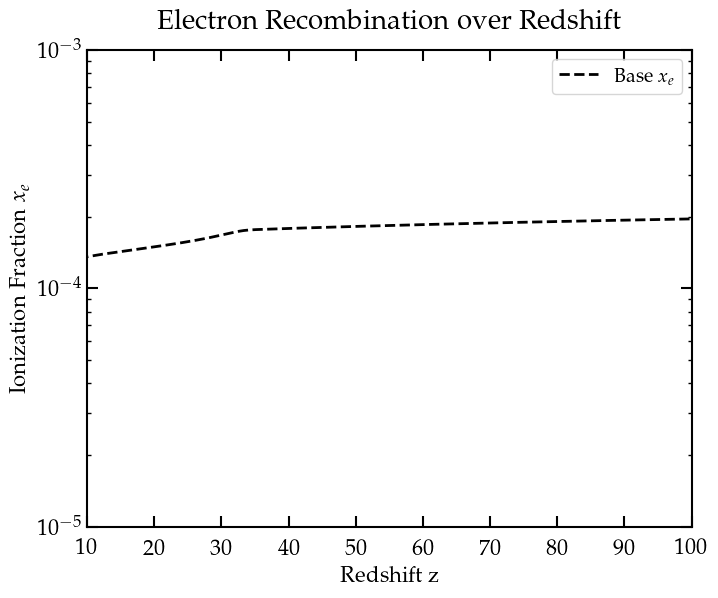

In [101]:
# Plot the results

plt.figure(figsize=(7.8, 6.2))

plt.plot(solution_base_xe.t, solution_base_xe.y[0], label=r'Base $x_e$', 
         linewidth=2, color='black', linestyle='dashed')
plt.xlabel('Redshift z')
plt.ylabel(r'Ionization Fraction $x_e$')
plt.title('Electron Recombination over Redshift')
plt.yscale('log')

plt.legend()
plt.ylim(1e-5,1e-3)
plt.xlim(10,100)
plt.show

In [102]:
# Create an interpolating function to store 
xe_base = interp1d(solution_base_xe.t, solution_base_xe.y[0])

## 2. Base H2

In [103]:
# Define free fall time as the characteristic time scale 

def t_ff_new (z): 

    # Define matter density in the halo 
    rho_m = 200*phys.RhoCrit*phys.Omega_m*(1+z)**3

    # Change units to g cm^-3
    rho_m = rho_m * phys.eV_to_ergs / (phys.cs**2) 

    val = (3 * np.pi / (32 * phys.G * rho_m) )**(1/2)

    return val
    

In [104]:
"""
Define a function to calculate critical H2 fraction as a function of redshift. 
The following function finds xH2_crit from the two cooling time scales define earlier, 
and is modeled on the base halo model we have defined earlier. 

"""

def crit_H2(z, m0, si):

    """ 
    Here z - redshift of observation for the base halo model we are considering. 
    si - a multiplicative factor that sets critical time scale relative to free fall time scale. 
    For Hubble time/age of the universe we use si = 9. 
    For Free-fall time use si = 1. 
    """
    
    # Ensure z is a numpy array
    z = np.atleast_1d(z)

    def crit_H2_func(xH2, z, si):
        # Define the inner function for fsolve
        return t_H2(xH2, nH_Halo(1, m0, z), T_halo(1, m0, z)) - si * t_ff_new(z)

    # Get the critical redshift zvir_value
    zvir_value = zvir(m0)
    
    # Create a mask for valid z values
    mask = z < zvir_value

    # Initialize an array to store the results (dtype=float to avoid issues with np.nan)
    fac = np.full(z.shape, np.nan, dtype=float)
    
    # Iterate over valid z values
    for i, valid in enumerate(mask):
        if valid:
            fac[i] = fsolve(crit_H2_func, 1e-7, args=(z[i], si))[0]  # Extract the root from fsolve

    fac[~mask] = np.nan
    
    return fac


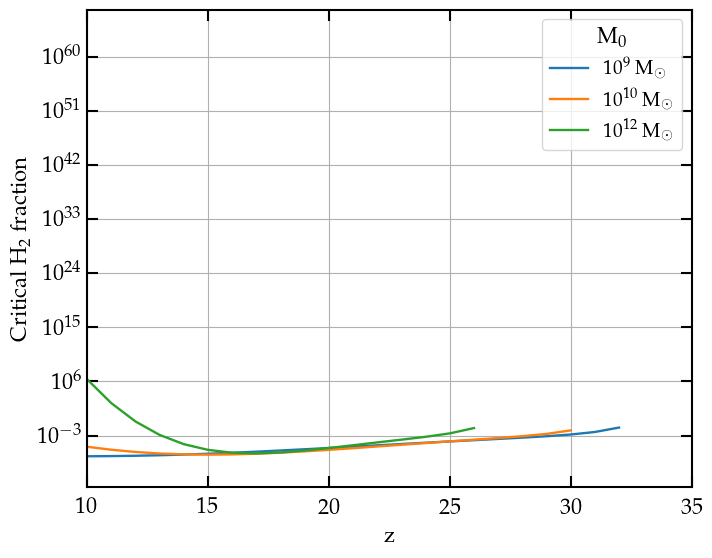

In [105]:
# Try plotting 

plt.figure(figsize=(7.8, 6.2))

plt.plot(z_list, crit_H2(z_list, 1e+9, 36.3), label=r'10$^9$ M$_\odot$' )
plt.plot(z_list, crit_H2(z_list, 1e+10, 36.3), label=r'10$^{10}$ M$_\odot$' )
plt.plot(z_list, crit_H2(z_list, 1e+12, 36.3), label=r'10$^{12}$ M$_\odot$' )

plt.yscale('log')
plt.grid()

plt.xlim(10,35)

plt.xlabel('z')
plt.ylabel(r'Critical H$_2$ fraction')

plt.legend(title=r'M$_0$')

plt.show()


In [106]:
""" 
This entire cell has old critical value calculations I was using. 

"""


# Define critical H2 fraction to cool within Hubble time 
def crit_H2_Furlanetto(z, Tm):

    # Convert scalar inputs to arrays
    z = np.atleast_1d(z)
    Tm = np.atleast_1d(Tm)
    
    T3=Tm/(1e+3)
    fac = (
        1.6e-4 * ((1+z)/ 20)**(-3/2) * 
        (1 + 10*T3**(7/2) / (60 + T3**4))**(-1) * 
        np.exp(512 / Tm)
    )

    zvir_value = zvir(m0_base)
    mask = (z < zvir_value)
    result = np.zeros_like(fac)  # Initialize the result array with zeros
    
    result[mask] = fac[mask]  # Apply the mask to assign fac to the result where the mask is True
    result[~mask] = np.nan
    
    # If the input was scalar, return scalar
    if result.size == 1:
        return result[0]
    return result

# Similarly define critical fraction according to Nebrin 2023
def crit_H2_Nebrin(z, si):
    """ 
    Here si is simply a multiplicative factor to free fall timescale. 
    si = 1 => Free fall cooling time scale or the shortest time scale. Requires highest H2 fraction. 
    si = 6. Threshold taken by Nebrin which reproduces the cooling time scale as seen in simulations. 
    It also signfies time scale when 50% of the halos can be expected to cool.
    si = 36.3 => The cooling threshold is set by Hubble time scale,
    also the minimum H2 required for gas to cool effectively at any redshift.
    """
    
    # Convert scalar inputs to arrays
    z = np.atleast_1d(z)

    M6 =  MAH(m0_base, z) / (1e+6)
    print(M6)

    fac = 1.4e-3 * M6**(-2.6) * ( (1+z) / 10)**(-2.4) / si
    
    zvir_value = zvir(m0_base)
    mask = (z < zvir_value)
    result = np.zeros_like(fac)  # Initialize the result array with zeros

    result[mask] = fac[mask]  # Apply the mask to assign fac to the result where the mask is True
    result[~mask] = np.nan
    
    # If the input was scalar, return scalar
    if result.size == 1:
        return result[0]
    return result

In [107]:
## First define a H^- dissociation rate due to CMB photons. This suppresses H2 formation before structure formation.

def k_pd_CMB(z, m0): 
    val = ( 
        4 * (2*np.pi)**(3/2) *
        ( phys.me_eV * phys.kB * phys.T_CMB(z) )**(3/2) / 
        (phys.h_planck * phys.cs)**3 * 
        np.exp(-0.754 / phys.kB / phys.T_CMB(z)) * 
        phys.C_Hminus(T_halo(1, m0, z))
    )

    return val

In [108]:
# Define base H2 history function for H2 production
def dH2_dz_base (z, xH2, m0): 
    val_1 = - phys.C_Hminus(T_halo(1, m0, z)) * xe_base(z) * (1-xe_base(z)) * nH_Halo(1, m0_base, z) / (1+z) / phys.Hubble(z) 

    val_2 = (1 + k_pd_CMB(z, m0) / (phys.C_H2(T_halo(1, m0_base, z)) * (1-xe_base(z)) * nH_Halo(1, m0_base, z)) )**(-1)
    
    return val_1*val_2

In [109]:
dH2_dz_base (50, 1e-8, m0_base)

array([-1.40639327e-08])

In [110]:
zvir(1e+9)

array([32.39539417])

In [111]:
# Define redshift range of interest
z_span = (119.9, 0.2)
z_eval=np.arange(119.9,0.2,-0.1)

# Solve the ODE 
"""
Here I've used the H2 abundance in the IGM as 10^(-8) as initial condition
"""
solution_base_xH2 = solve_ivp(dH2_dz_base, z_span, np.array([1e-8]), t_eval= z_eval, rtol=1e-10, atol=1e-10, args=(1e+9,) )

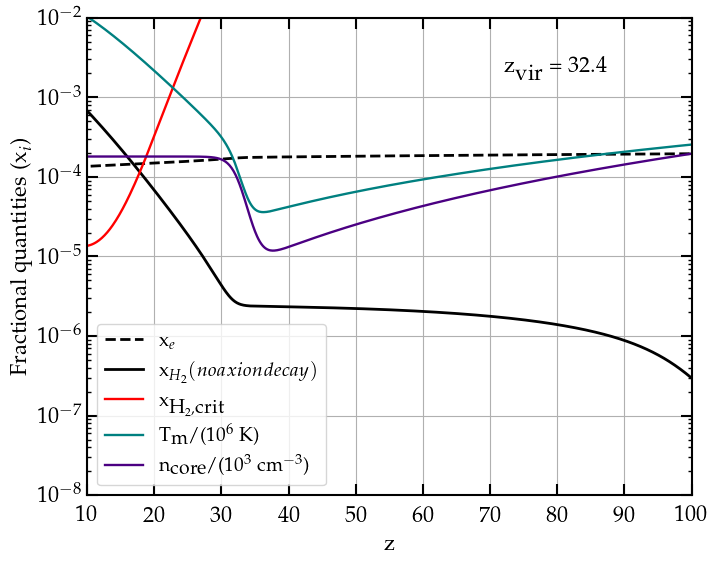

In [112]:
# Plot the results
plt.figure(figsize=(7.8, 6.2))

# Plot xe history
plt.plot(solution_base_xe.t, solution_base_xe.y[0], label=r'x$_e$', 
         linewidth=2, color='black', linestyle='dashed')

# Plot H2 history
plt.plot(solution_base_xH2.t, solution_base_xH2.y[0], label='x$_{H_2} (no axion decay)$', linewidth=2, color='black')

# Plot critical requirement
plt.plot(z_eval, crit_H2(z_eval, 1e+9 , 1), label = r'x$_{\textnormal{H}_2,\textnormal{crit}}$',
         color='red' )

plt.plot(z_eval, T_halo(1, 1e+9, z_eval)/1e+6, label=r'T$_\textnormal{m}$/(10$^6$ K)', color='teal')

plt.plot( z_eval, nH_Halo(1, 1e+9, z_eval)/1e+3, color='indigo', label=r'n$_\textnormal{core}$/(10$^3$ cm$^{-3}$)')

plt.xlabel('z')
plt.ylabel('Fractional quantities (x$_i$)')

plt.text(72, 2e-3, r'z$_\textnormal{vir}$ = 32.4', fontsize=16)

plt.yscale('log')
plt.legend()
plt.grid()
plt.xlim(10,100)
plt.ylim(1e-8,1e-2)

plt.savefig('./plots/Base_history.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

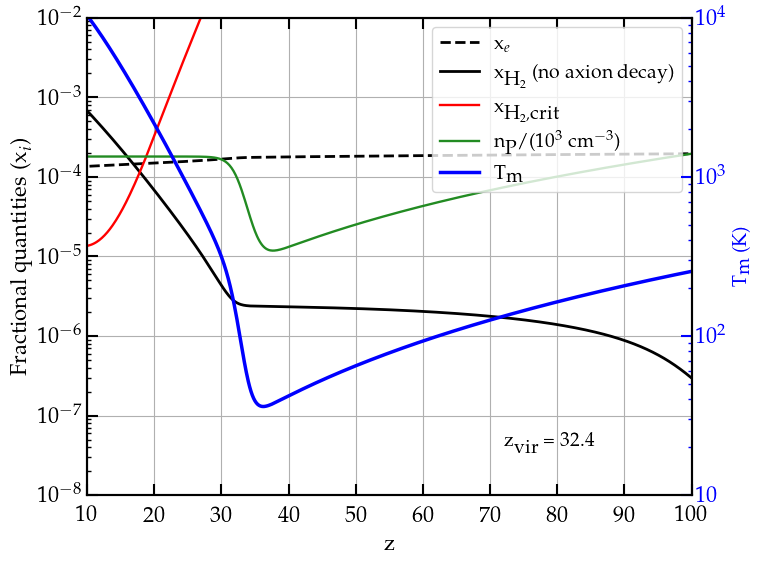

In [113]:
# Alternate version to highlight temperature history

fig, ax1 = plt.subplots(figsize=(7.8, 6.2))

# Primary axis: fractional quantities
ax1.plot(solution_base_xe.t, solution_base_xe.y[0], label=r'x$_e$', 
         linewidth=2, color='black', linestyle='dashed')

ax1.plot(solution_base_xH2.t, solution_base_xH2.y[0], label=r'x$_{\textnormal{H}_2}$ (no axion decay)', 
         linewidth=2, color='black')

ax1.plot(z_eval, crit_H2(z_eval, 1e+9, 1), label=r'x$_{\textnormal{H}_2,\textnormal{crit}}$',
         color='red')

# Density plot
ax1.plot(z_eval, nH_Halo(1, 1e+9, z_eval)/1e+3, color='forestgreen',
         label=r'n$_\textnormal{P}$/(10$^3$ cm$^{-3}$)')

# Add a text annotation
ax1.text(72, 4e-8, r'z$_\textnormal{vir}$ = 32.4', fontsize=14)

# Axis settings for ax1
ax1.set_xlabel('z')
ax1.set_ylabel(r'Fractional quantities (x$_i$)', fontsize=16)
ax1.set_yscale('log')
ax1.set_xlim(10, 100)
ax1.set_ylim(1e-8, 1e-2)
ax1.grid()
ax1.tick_params(axis='y', labelcolor='black')

# Twin axis for temperature
ax2 = ax1.twinx()

# Temperature plot (highlighted)
temp_color = 'blue'
T_vals = T_halo(1, 1e+9, z_eval)
ax2.plot(z_eval, T_vals, label=r'T$_\textnormal{m}$', color=temp_color, linewidth=2.5)

# Axis settings for ax2
ax2.set_ylabel(r'T$_\textnormal{m}$ (K)', color=temp_color, fontsize=14)
ax2.tick_params(axis='y', which='both', colors=temp_color)
#ax2.tick_params(axis='y', color=temp_color, labelcolor=temp_color)
ax2.set_yscale('log')
ax2.set_ylim(10,1e+4)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Save and show
plt.savefig('./plots/Standard_history.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [114]:
phys.Hubble(z_eval) / phys.Hubble(32.4)

array([6.88663803, 6.87809559, 6.86955669, ..., 0.01222097, 0.0115073 ,
       0.01085071])

# IV. Axion decay

This section contains changes in $H_2$ history with inclusion of decaying axions. 

The photo-detachment integrals are extremely slow for computational processes. In this case, redefine the photo-detachment function for easier computation. The easiest way to do this is to compute the energy integral separately, and simply multiply by some function of other parameters. 

In [115]:
# Assuming low_limit function and H_levels are defined elsewhere
def low_limit(ma):
    if ma / 2 < H_levels[0] and ma / 2 >= 0.755:
        return 0.755
    elif ma / 2 >= H_levels[0]:
        return closest_below(H_levels, ma / 2)

# Define the cross-section integral
def cs_int_func(ma):
    eth = 0.755
    ma = np.asarray(ma, dtype='float')


    def integrand(en):
        return (en - eth)**(3 / 2) / en**(5 / 2)

    results = []

    
    if np.isscalar(ma) == True: 
        e_max = ma/2
        e_min = low_limit(ma)
        result, error = quad(integrand, e_min, e_max)
        return result
    else:
        for m in ma:
            e_max = m / 2
            e_min = low_limit(m)
            result, error = quad(integrand, e_min, e_max)
            results.append(result)

    return np.array(results)



In [116]:
7.982e+5 *phys.h_planck**(3/2)* cs_int_func(np.array([0.755*5]))

array([4.33932147e-17])

In [117]:
cs_int_func(np.array([2]))

array([0.01446079])

In [118]:
# Redefine k_pd 

def k_pd (z, ma, ga):

    ma = np.asarray(ma, dtype='float')  # Convert ma to a numpy array

    # Ensure ma is 1-dimensional
    if ma.ndim == 0:  # If ma is a scalar (0-d array), convert it to 1-d
        ma = np.array([ma])

    # Define a factor to impose broadcasting if statments on axion mass and calculate axion mass dependent quantities
    fac = np.zeros_like(ma) 

    # Use masks 
    mask_zero = (ma/2 < 0.755) | (ma/2 >= phys.rydberg_energy)
    fac[mask_zero] = 0
    
    mask_one = (ma/2 >= 0.755) & (ma/2 < phys.rydberg_energy) 
    fac[mask_one] = cs_int_func(ma[mask_one]) 

    # Define a prefactor constant 
    const = (7.982e+5 * phys.cs * phys.h_planck**(3/2) * 2**(5/2) * phys.RhoCrit * phys.Omega_c * (1 + z) ** 3 *gamma_decay(ma,ga)
             / phys.Hubble(z) / ma**(5/2))

    return const*fac
    

In [119]:
k_pd(20,np.array([1,2,25,27,29]), 1e-11)

array([0.00000000e+00, 5.53765861e-11, 4.06561558e-10, 6.45612028e-12,
       0.00000000e+00])

In [120]:
k_pd(np.array([20,40,60]), 25,1e-9)

array([4.06561558e-06, 1.10921977e-05, 2.01298888e-05])

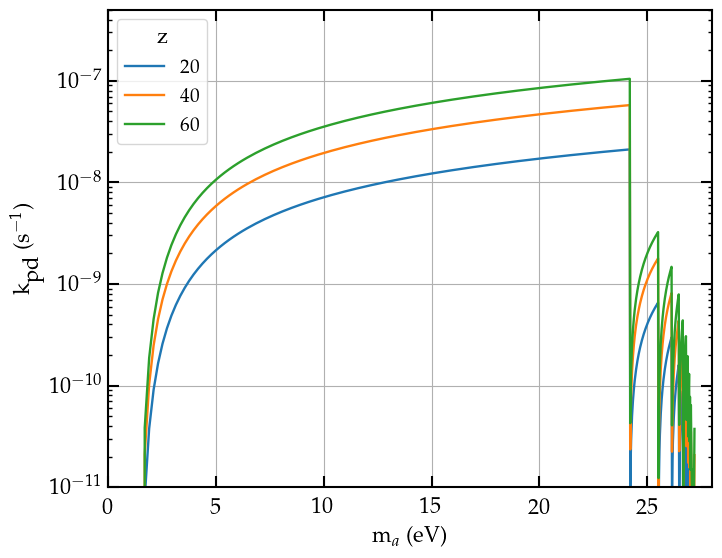

In [121]:
# print new k_pd 


list1 = 2*np.linspace(0.755,10.95,100)
list2 = 2*np.linspace(11,13.59,250)

ma_list = np.concatenate((list1,list2))

plt.figure(figsize=(7.8, 6.2))

plt.plot(ma_list, k_pd(20, ma_list, 1e-11), label='20')
plt.plot(ma_list, k_pd(40, ma_list, 1e-11), label='40')
plt.plot(ma_list, k_pd(60, ma_list, 1e-11), label='60')

plt.ylim(1e-11, 5e-7) 
plt.xlim(0,28)
plt.yscale('log')
plt.legend(title='z')

plt.xlabel(r'm$_a$ (eV)')
plt.ylabel(r'k$_{\textnormal{pd}}$ (s$^{-1}$)')

plt.grid()

plt.savefig('./plots/k_pd.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

Note this produces the earlier version and the mathematica result. 

In [122]:

# Define Doppler broadening velocity 
def doppler(Tm): 
    return (phys.kB *Tm / phys.mp_eV)**(1/2) * phys.cs

# Define the power in the shielding factor denominator, call eta 
def eta (Tm, n): 
    A1 = 0.8711*np.log10(Tm) - 1.928 
    A2 = -0.9639*np.log10(Tm) + 3.892
    val = A1 * np.exp(-0.2856*np.log10(n)) + A2 
    return val 

# Define a function to calculate shielding factor 
def f_sh(Tm, ncore, rcore, xH2): 
    """ 
    Parameters: 
    Tm - matter temperature (K) 
    ncore - density at the core (cm^-3)
    rcore - radius of the core in pc 
    xH2 - H2 fraction
    """
    xH2 = np.asarray(xH2)
    
    # Define H2 column density / 5e+14 cm^2
    NH2 = 0.926 * ncore * rcore * phys.pc_to_cm * xH2 / (5e+14)

    # Define Doppler parameter / 1e+5 cm s^(-1) 
    b5 = doppler(Tm) / (1e+5)
    
    val_1 = 0.965 / ( (1 + NH2/b5)**(eta(Tm,ncore)) )
    val_2 = 0.035 *np.exp( -8.5e-4 * (1+NH2)**0.5 ) / (1 + NH2)**(0.5)

    return val_1 + val_2 

In [123]:
f_sh(3000, 0.1, 100, 1e-0)

np.float64(0.00011949403283699304)

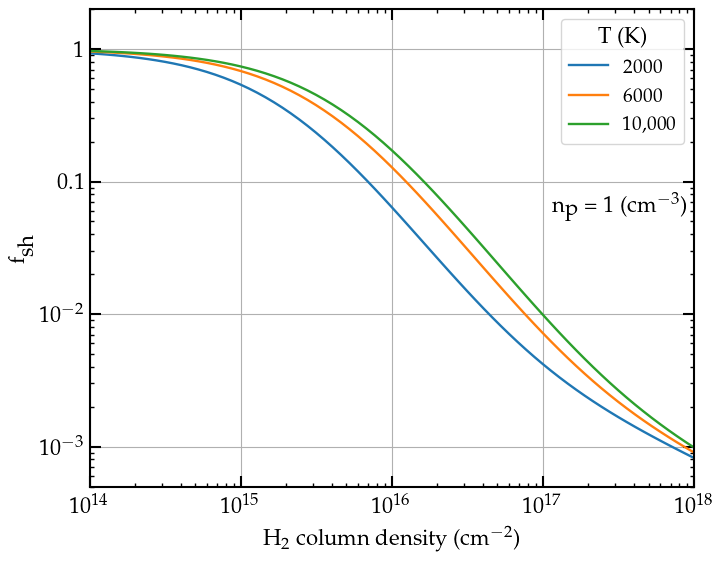

In [124]:
# Plot self-shielding factor

test_xh2 = 10**np.linspace(-7,-1.5,100)
plt.figure(figsize=(7.8,6.2))
plt.loglog()

plt.plot(1*25*phys.pc_to_cm*test_xh2, f_sh(2e+3, 1, 25, test_xh2),
        label=r'2000')
plt.plot(1*25*phys.pc_to_cm*test_xh2, f_sh(6e+3, 1, 25, test_xh2),
        label=r'6000')
plt.plot(1*25*phys.pc_to_cm*test_xh2, f_sh(1e+4, 1, 25, test_xh2), 
        label=r'10,000')

plt.xlim(1e+14, 1e+18)
plt.xlabel(r'H$_2$ column density (cm$^{-2}$)')

plt.ylim(5e-4, 2)
plt.ylabel(r'f$_{\textnormal{sh}}$')

plt.text(1.15e+17, 6e-2, r'n$_{\textnormal{p}}$ = 1 (cm$^{-3}$)', fontsize=16)

plt.legend(title='T (K)')

plt.grid()

plt.savefig('./plots/f_shield.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

In [125]:
eta(10000,0.1)

np.float64(2.1072837781506126)

In [126]:
# Redefine k_LW

def k_LW_2(z, ma, ga): 

    ma = np.asarray(ma, dtype=float)  # Ensure ma is always a float array
    energy = ma/2

    frac = np.zeros_like(ma)

    # Try using masks 
    mask_zero = (ma/2 < 11.5) | (ma/2 >= phys.rydberg_energy)
    frac[mask_zero] = 0

    mask_one = (ma / 2 >= 11.5) & (ma/2 < H_levels[0])
    frac[mask_one] = (ma[mask_one]/2 - 11.5) / 2.1

    mask_two = (ma/2 >= H_levels[0]) & (ma/2 < phys.rydberg_energy)
    frac[mask_two] = (ma[mask_two]/2 - closest_below(H_levels, ma[mask_two]/2))/2.1

    J_igm = 2 * phys.cs * phys.h_planck * phys.eV_to_ergs / (4 * np.pi * phys.Hubble(z)) * \
            (phys.RhoCrit * phys.Omega_c * (1 + z) ** 3) / ma * gamma_decay(ma, ga) * \
            (2 * energy / ma) ** 1.5

    return 1.39e+9* frac *J_igm / 2
    


In [127]:
k_LW(20,12.09*2,1e-11)

array(2.71468988e-10)

In [128]:
# Redefine k_LW

def k_LW(z, ma, ga): 

    ma = np.asarray(ma, dtype=float)  # Ensure ma is always a float array

    frac = np.zeros_like(ma)

    # Define cross section 
    sigma_LW = 3.71e-18 # cm^2 

    # Try using masks 
    # Outside LW limit 
    mask_zero = (ma/2 < 11.5) | (ma/2 >= phys.rydberg_energy)
    frac[mask_zero] = 0

    # Between 12.1 eV and 11.5 eV. 
    mask_one = (ma / 2 >= 11.5) & (ma/2 < H_levels[0])
    frac[mask_one] = 1 - ( 2 * 11.5 / ma[mask_one])**(3/2)
    
    # Between 13.6 eV and 12.1 eV 
    mask_two = (ma/2 >= H_levels[0]) & (ma/2 < phys.rydberg_energy)
    frac[mask_two] = 1 - (2 * closest_below(H_levels, ma[mask_two]/2) / ma[mask_two])**(3/2)

    # Define pre factors from intensity 
    val = ( 4 * phys.cs * sigma_LW * gamma_decay(ma, ga) / (3 * phys.Hubble(z)) * 
            phys.RhoCrit * phys.Omega_c * (1 + z) ** 3 / ma )

    return val*frac

In [129]:
k_LW(np.array([20,40,60]), 25, 1e-11)

array([3.36905401e-10, 9.19177243e-10, 1.66810366e-09])

In [130]:
1 / gamma_decay(1e+4, 1e-18)

1.3227758541430704e+29

In [131]:
k_LW_2(np.array([20,40,60]), 24, 1e-11)

array([2.26646025e-10, 6.18357164e-10, 1.12218167e-09])

In [132]:
k_LW (20, np.array([22,23,24,25,26,27,28,29,30]), 1e-11)

array([0.00000000e+00, 0.00000000e+00, 3.97328064e-10, 3.36905401e-10,
       2.11853509e-10, 6.09892959e-12, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [133]:
k_LW_2 (20, np.array([22,23,24,25,26,27,28,29,30]), 1e-11)

array([0.00000000e+00, 0.00000000e+00, 2.26646025e-10, 1.99717688e-10,
       1.30158173e-10, 3.87328480e-12, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [134]:
ma_space = 2*np.linspace(11.5,13.58,5000)

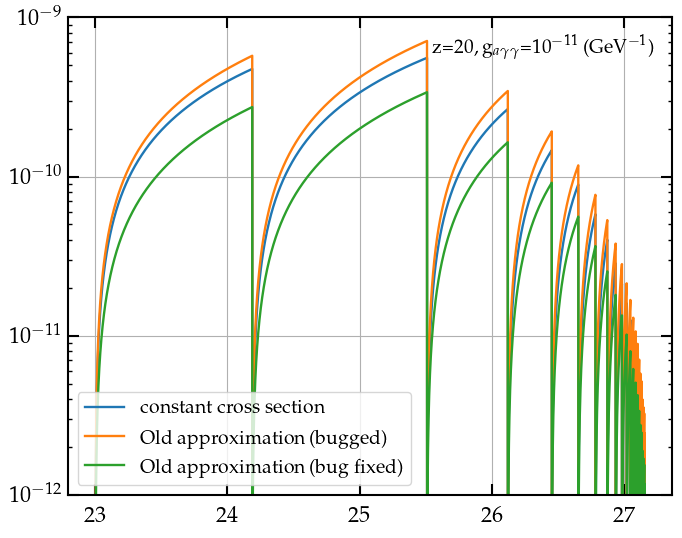

In [135]:
# Compare different k_LW rates 
plt.figure(figsize=(7.8,6.2))

plt.plot(ma_space, k_LW(20, ma_space, 1e-11), label = 'constant cross section')

plt.plot(ma_space, 2.1*k_LW_2(20, ma_space, 1e-11), label='Old approximation (bugged)' )
plt.plot(ma_space, k_LW_2(20, ma_space, 1e-11), label='Old approximation (bug fixed)' )

plt.yscale('log')

plt.legend()
plt.grid()

plt.ylim(1e-12, 1e-9)

plt.text(25.55, 6e-10, r'z=20, g$_{a \gamma \gamma}$=10$^{-11}$ (GeV$^{-1}$)', fontsize=14)

plt.show()

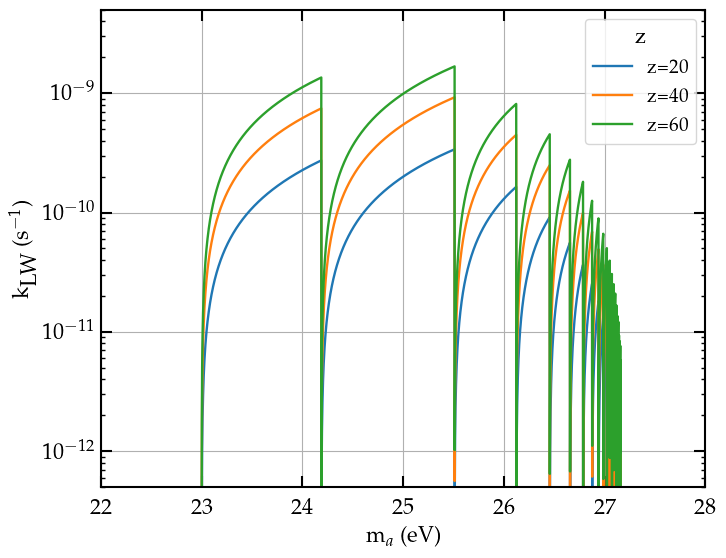

In [136]:
# Plot LW dissociation rates again 
plt.figure(figsize=(7.8, 6.2))

plt.plot(ma_space, k_LW_2(20, ma_space, 1e-11), label='z=20')
plt.plot(ma_space, k_LW_2(40, ma_space, 1e-11), label='z=40')
plt.plot(ma_space, k_LW_2(60, ma_space, 1e-11), label='z=60')

plt.yscale('log')
plt.xlim(22,28)
plt.ylim(5e-13, 5e-9)
plt.grid()
plt.legend(title='z')

plt.xlabel(r'm$_a$ (eV)')
plt.ylabel(r'k$_{\textnormal{LW}}$ (s$^{-1}$)')

plt.savefig('./plots/k_LW.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

### 1. Case 1 

In [137]:
# Define differential equation for x_H2

def dxH2_dz (z, xH2, m0, ma, ga): 

    ma = np.asarray(ma)
    ga = np.asarray(ga)

    # base formation term
    form = phys.C_Hminus(T_halo(1.5, m0, z)) * xe_base(z) * nH_Halo(1.5, m0, z)
    
    # photodetachment term 
    pd = 1 + (k_pd(z, ma, ga) + k_pd_CMB(z, m0) )/ (phys.C_H2(T_halo(1.5, m0, z)) * nH_Halo(1.5, m0, z))

    # LW dissociation term 
    lw = xH2*k_LW(z, ma, ga) * f_sh( T_halo(1.5, m0, z), nH_Halo(1.5, m0, z), 0.1*phys.Rvir(z, MAH(m0, z)), xH2)

    return (-1 / phys.Hubble(z) / (1+z)) * (form / pd  - lw)
    

In [138]:
dxH2_dz (20, 1e-4, 1e+9 ,25, 1e-13)

array([0.00067591])

In [139]:
dxH2_dz(np.array([1,5,10,15,20, 25, 30, 35, 40]), 1 , 1e+9, 25,1e-11)

array([ 11.16019474,  17.43578295,  21.14081867,  25.63095477,
        31.34897032,  38.64848656,  48.64103839, 268.86816201,
       343.7770556 ])

In [140]:
dxH2_dz(20, 1 , 1e+9, 25, np.array([1e-10, 1e-11, 1e-12]))

array([3.13489763e+03, 3.13489703e+01, 3.13473168e-01])

In [141]:
# Try solving the differential equation 

# initial condition
xH20 = np.array([1e-7])

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-0.1)

ma_1 = 25
ga_1 = 1e-13

In [142]:
%%time
solution_xH2 = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(m0_base, ma_1, ga_1), 
                         t_eval= z_eval,  
                         method='Radau',
                         rtol=1e-4, atol=1e-11 )

CPU times: user 4.06 s, sys: 30.1 ms, total: 4.09 s
Wall time: 4.1 s


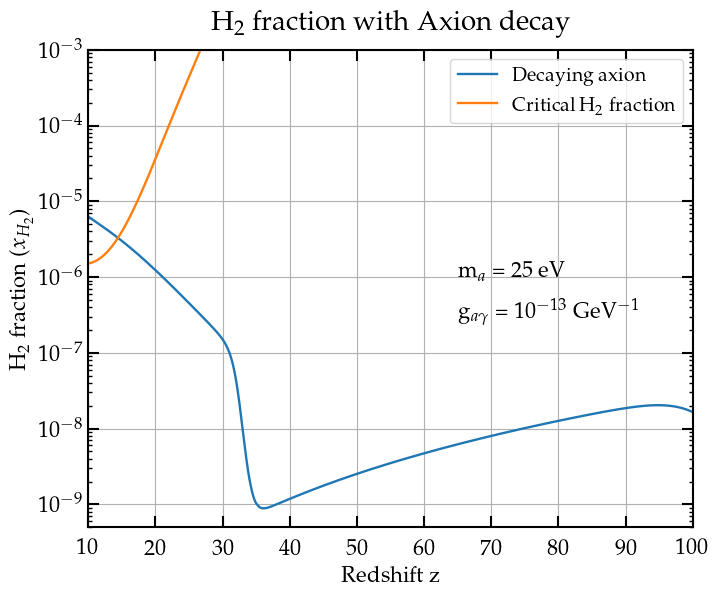

In [143]:
# Plot the results
plt.figure(figsize=(7.8, 6.2))

plt.plot(solution_xH2.t, solution_xH2.y[0], label='Decaying axion')
plt.plot(z_eval, crit_H2(z_eval, m0_base,9), label = r'Critical H$_2$ fraction' )
plt.xlabel('Redshift z')
plt.ylabel(r'H$_2$ fraction ($x_{H_2}$)')
plt.title(r'H$_2$ fraction with Axion decay')
plt.yscale('log')
plt.text(65,1e-6, r'm$_a$ = 25 eV', fontsize=16)
plt.text(65,3e-7, r'g$_{a \gamma}$ = 10$^{-13}$ GeV$^{-1}$', fontsize=16)

plt.legend()
plt.xlim(10,100)
plt.ylim(5e-10,1e-3)
plt.grid()
plt.show()

### 2. Case 2. 

In [144]:
# Try a solution with just photodetachment 

ma_2 = 5
ga_2 = 1e-11

In [145]:
%%time
solution_xH2_2 = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(m0_base, ma_2, ga_2), 
                         t_eval= z_eval,  
                         rtol=1e-4, atol=1e-11, 
                          vectorized=True)

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/1557348712.py:30: RuntimeWarning: invalid value encountered in sqrt
  val_2 = 0.035 *np.exp( -8.5e-4 * (1+NH2)**0.5 ) / (1 + NH2)**(0.5)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/1557348712.py:29: RuntimeWarning: invalid value encountered in power
  val_1 = 0.965 / ( (1 + NH2/b5)**(eta(Tm,ncore)) )


CPU times: user 924 ms, sys: 16.8 ms, total: 941 ms
Wall time: 942 ms


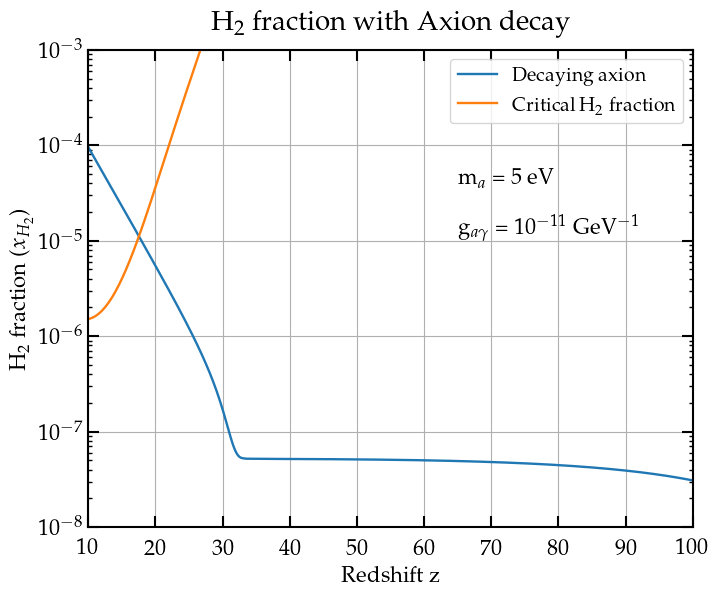

In [146]:
# Plot the results
plt.figure(figsize=(7.8, 6.2))

plt.plot(solution_xH2_2.t, solution_xH2_2.y[0], label='Decaying axion')
plt.plot(z_eval, crit_H2(z_eval, m0_base, 9), label = r'Critical H$_2$ fraction' )
plt.xlabel('Redshift z')
plt.ylabel(r'H$_2$ fraction ($x_{H_2}$)')
plt.title(r'H$_2$ fraction with Axion decay')
plt.yscale('log')
plt.text(65, 4e-5, r'm$_a$ = 5 eV', fontsize=16)
plt.text(65, 1.2e-5, r'g$_{a \gamma}$ = $10^{-11}$ GeV$^{-1}$', fontsize=16)
plt.xlim(10,100)
plt.ylim(1e-8,1e-3)
plt.legend()
plt.grid()
plt.show()

### 3. Parameter Space Scans

Do a test run

In [147]:
# Create a solver 

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-0.1)

ma_test = np.array([5, 10, 25, 27])
ga_test = 10**np.array([-11,-12,-13], dtype='float')
# Create an empty array to store the results 

m0_base = 1e+9

X, Y =np.meshgrid(ma_test, ga_test)

# Create an empty list to store the results
result_test = np.empty((len(ma_test), len(ga_test)), dtype=object)


In [148]:
%%time
for i,ma in enumerate(ma_test): 
    for j,ga in enumerate(ga_test):
        sol = solve_ivp(dxH2_dz, z_span, np.array([1e-8]),
                         args=(m0_base, ma, ga), 
                         t_eval= z_eval,  
                         method='Radau',
                         rtol=1e-4, atol=1e-14 )
        result_test[i][j] = sol.y[0]

CPU times: user 44.1 s, sys: 401 ms, total: 44.5 s
Wall time: 45.1 s


In [149]:
print(result_test[1,2])

[1.00000000e-08 1.01201163e-08 1.02427177e-08 ... 9.14498544e-03
 9.72303042e-03 1.03512738e-02]


In [150]:
result_test.shape

(4, 3)

In [151]:
result_test[0,1]

array([1.00000000e-08, 1.01193989e-08, 1.02412508e-08, ...,
       9.02572376e-03, 9.60243098e-03, 1.02295494e-02])

In [152]:
# Try saving the solutions to differential equations in a file 
with h5py.File('./solutions/test_solution.h5', 'w') as f: 

    print('File \'./solutions/test_solution.h5\' created successfully.')
    
    for i, ma in enumerate(ma_test):
        for j, ga in enumerate(ga_test):

            # Define name for data set
            dataset_name = f'xH2_sol_ma{i}_ga{j}'

            # Create data set and save solution 
            f.create_dataset(dataset_name, data = result_test[i,j])

    print('Data exported successfully.')

File './solutions/test_solution.h5' created successfully.
Data exported successfully.


In [153]:
# Try loading the data into a new variable. 
test_import = np.empty( (len(ma_test), len(ga_test)), dtype='O')

with h5py.File('./solutions/test_solution.h5', 'r') as f:
    print('File \'./solutions/test_solution.h5\' opened succesfully.')

    for i, ma in enumerate(ma_test):
        for j, ga in enumerate(ga_test):

            # Define name for data set
            dataset_name = f'xH2_sol_ma{i}_ga{j}'

            # Save the data in the new variable
            test_import[i,j] = f[dataset_name][:]

    print('H2 solutions imported to variable: test_import.')

File './solutions/test_solution.h5' opened succesfully.
H2 solutions imported to variable: test_import.


In [154]:
crit_H2(20, 1e+9, 1)

array([0.00032553])

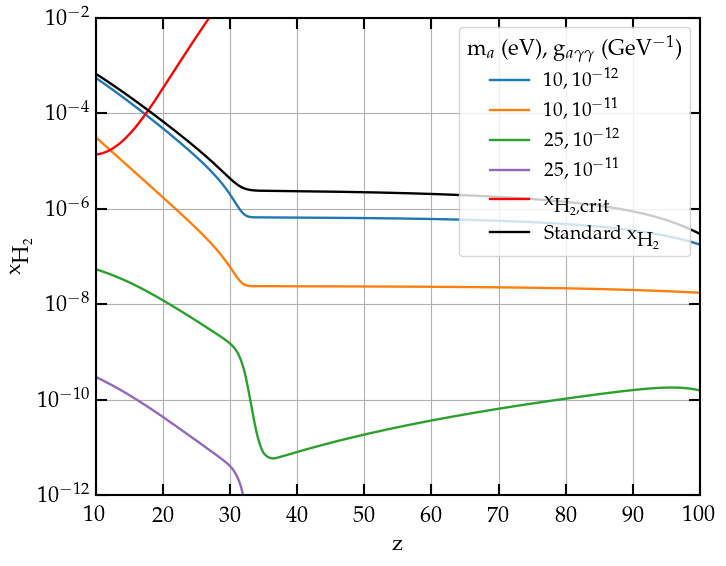

In [155]:
plt.figure(figsize=(7.8, 6.2))

plt.plot(z_eval, test_import[1,1], label=r'10, 10$^{-12}$')
plt.plot(z_eval, test_import[1,0], label=r'10, 10$^{-11}$')
plt.plot(z_eval, test_import[2,1], label=r'25, 10$^{-12}$')
plt.plot(z_eval, test_import[2,0], label=r'25, 10$^{-11}$', color=default_colors[4])

plt.plot(z_eval, crit_H2(z_eval, m0_base, 1), label = r'x$_{\textnormal{H}_2,\textnormal{crit}}$',
         color='red' )

plt.plot(solution_base_xH2.t, solution_base_xH2.y[0], label=r'Standard x$_{\textnormal{H}_2}$', 
         color='black')

plt.yscale('log')
plt.xlim(10,100)
plt.ylim(1e-12,1e-2)
plt.grid()
plt.xlabel('z')
plt.ylabel(r'x$_{\textnormal{H}_2}$')
plt.legend(title=r'm$_a$ (eV), g$_{a \gamma \gamma}$ (GeV$^{-1}$)')

plt.savefig('./plots/sample_H2.pdf', format = 'pdf', dpi=300, bbox_inches='tight')

plt.show()

### 4. Small Scan Over Entire Grid 

Awfully slow calculations

In [1]:
# axion masses 
ma_list = 2*np.linspace(0.76, 13.6, 100)

# couplings
ga_list = 10**np.linspace(-9,-16, 50)

X, Y = np.meshgrid(ma_list, ga_list)

NameError: name 'np' is not defined

In [157]:
# Create the solver 

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-1)

X, Y =np.meshgrid(ma_list, ga_list)

# Create an empty list to store the results
results_small = np.zeros((len(ma_list), len(ga_list)), dtype=object)


#### WARNING!! LONG COMPUTATION!!


Next cell takes almost 2:30 hours to run. 

In [158]:
%%time

"""
WARNING!! This cells takes 2.30 hours to run. The output of the cell is instead stored in a file 
with path solutions/solutions_small.h5. One can simply skip this step and import the file later on. 
"""

# Loop over the meshgrid of parameters and solve the ODE
for i, ma in enumerate(ma_list): 
    for j, ga in enumerate(ga_list):
        sol = solve_ivp(
            dxH2_dz, z_span, np.array([1e-8]),
            args=(m0_base, ma, ga),
            t_eval=z_eval,
            method='Radau',
            rtol=1e-4, atol=1e-11
        )
        results_small[i,j] = sol.y[0]

KeyboardInterrupt: 

Redshift 10 is at position 109 in z_eval. 

In [894]:
results_small[50,25][109]

np.float64(0.0006615935989785013)

In [895]:
# Store the results in a seperate file for easier use. 

with h5py.File('./solutions/solutions_small.h5', 'w') as f: 

    print('File \'./solutions/solutions_small.h5\' created successfully.')
    
    for i, ma in enumerate(ma_list):
        for j, ga in enumerate(ga_list):

            # Define name for data set
            dataset_name = f'xH2_sol_ma{i}_ga{j}'

            # Create data set and save solution 
            f.create_dataset(dataset_name, data = results_small[i,j])

    print('Successfully exported data.')

File './solutions/solutions_small.h5' created successfully.
Successfully exported data.


In [159]:
# Import data from the small parameter space data file 

# Define an empty object matrix 
import_small_results = np.empty( (len(ma_list), len(ga_list)), dtype=object )

# import values 

with h5py.File('./solutions/solutions_small.h5', 'r') as f:
    print('File \'./solutions/solutions_small.h5\' opened succesfully.')

        
    for i, ma in enumerate(ma_list): 
        for j, ga in enumerate(ga_list):

            #  Name in the data set
            dataset_name = f'xH2_sol_ma{i}_ga{j}' 

            # assign values 
            import_small_results[i,j] = f[dataset_name][:] 

    print('Succesfully imported data to variable: import_small_results')

File './solutions/solutions_small.h5' opened succesfully.
Succesfully imported data to variable: import_small_results


In [160]:
# Define a matrix that stores H2 fraction at critical redshift 

h2_frac_z10 = np.zeros((len(ga_list), len(ma_list)))

In [161]:
# Extract the value at z=10 for each (ma, ga) combination
for j, ga in enumerate(ga_list):
    for i, ma in enumerate(ma_list):
        try:
            # Assuming results[j, i] gives the solution array for (ma, ga)
            h2_frac_z10[j, i] = import_small_results[i, j][109]  # Extract value at z=10 (index 109)
        except IndexError:
            # Handle cases where results are incomplete
            print(f"Skipping invalid result at ma={ma}, ga={ga}")


In [162]:
h2_frac_z10.T.shape

(100, 50)

In [163]:
# Create a meshgrid for plotting
X, Y = np.meshgrid(ma_list,ga_list)

In [164]:
X,Y.shape

(array([[ 1.52      ,  1.77939394,  2.03878788, ..., 26.68121212,
         26.94060606, 27.2       ],
        [ 1.52      ,  1.77939394,  2.03878788, ..., 26.68121212,
         26.94060606, 27.2       ],
        [ 1.52      ,  1.77939394,  2.03878788, ..., 26.68121212,
         26.94060606, 27.2       ],
        ...,
        [ 1.52      ,  1.77939394,  2.03878788, ..., 26.68121212,
         26.94060606, 27.2       ],
        [ 1.52      ,  1.77939394,  2.03878788, ..., 26.68121212,
         26.94060606, 27.2       ],
        [ 1.52      ,  1.77939394,  2.03878788, ..., 26.68121212,
         26.94060606, 27.2       ]]),
 (50, 100))

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/2663624490.py:5: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y ,h2_frac_z10,


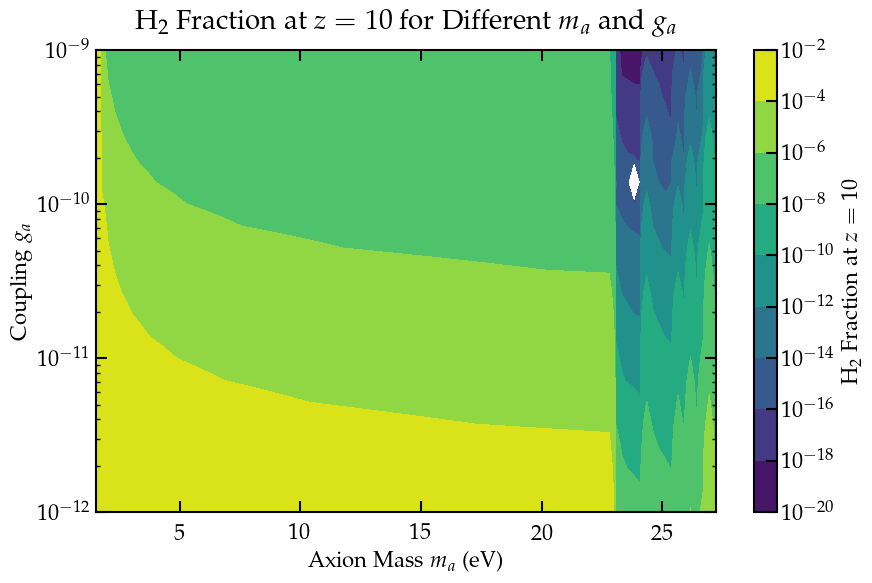

In [165]:
# Plotting the contour
plt.figure(figsize=(10, 6))
ax = plt.gca()

contour = plt.contourf(X, Y ,h2_frac_z10, 
                       norm=LogNorm(),
                       levels=50, 
                       cmap="viridis")

cbar = plt.colorbar(contour)

ax.set_yscale('log')

cbar.set_label(r"H$_2$ Fraction at $z=10$")
plt.xlabel(r"Axion Mass $m_a$ (eV)")
plt.ylabel(r"Coupling $g_a$")
plt.title(r"H$_2$ Fraction at $z=10$ for Different $m_a$ and $g_a$")

plt.ylim(1e-12,1e-9)
plt.show()

# V. Finish

In [166]:
# create a grid for valies 

ma_fin_1 = np.linspace(0.5,11.45,50)
ma_fin_2 = np.linspace(11.5, 13.595, 100)

ma_fin = 2*np.concatenate((ma_fin_1, ma_fin_2))

In [167]:
ma_fin

array([ 1.        ,  1.44693878,  1.89387755,  2.34081633,  2.7877551 ,
        3.23469388,  3.68163265,  4.12857143,  4.5755102 ,  5.02244898,
        5.46938776,  5.91632653,  6.36326531,  6.81020408,  7.25714286,
        7.70408163,  8.15102041,  8.59795918,  9.04489796,  9.49183673,
        9.93877551, 10.38571429, 10.83265306, 11.27959184, 11.72653061,
       12.17346939, 12.62040816, 13.06734694, 13.51428571, 13.96122449,
       14.40816327, 14.85510204, 15.30204082, 15.74897959, 16.19591837,
       16.64285714, 17.08979592, 17.53673469, 17.98367347, 18.43061224,
       18.87755102, 19.3244898 , 19.77142857, 20.21836735, 20.66530612,
       21.1122449 , 21.55918367, 22.00612245, 22.45306122, 22.9       ,
       23.        , 23.04232323, 23.08464646, 23.1269697 , 23.16929293,
       23.21161616, 23.25393939, 23.29626263, 23.33858586, 23.38090909,
       23.42323232, 23.46555556, 23.50787879, 23.55020202, 23.59252525,
       23.63484848, 23.67717172, 23.71949495, 23.76181818, 23.80

In [168]:
H_levels

array([12.09394871, 12.75533653, 13.06146461, 13.2277564 , 13.32802511,
       13.39310336, 13.43772079, 13.46963538, 13.49324856, 13.51120833,
       13.52518524, 13.5362755 , 13.54522256, 13.55254506, 13.55861378,
       13.56369942, 13.5680034 , 13.57167807, 13.57484039, 13.57758137,
       13.57997265, 13.58207131])

In [169]:
# Create a grid for ga gamma space
ga_fin = 10**np.linspace(-15, -9, 120)

In [170]:
ga_fin

array([1.00000000e-15, 1.12310450e-15, 1.26136372e-15, 1.41664327e-15,
       1.59103844e-15, 1.78690243e-15, 2.00687817e-15, 2.25393390e-15,
       2.53140332e-15, 2.84303046e-15, 3.19302031e-15, 3.58609548e-15,
       4.02755998e-15, 4.52337074e-15, 5.08021805e-15, 5.70561576e-15,
       6.40800274e-15, 7.19685673e-15, 8.08282219e-15, 9.07785399e-15,
       1.01953787e-14, 1.14504757e-14, 1.28600808e-14, 1.44432146e-14,
       1.62212394e-14, 1.82181470e-14, 2.04608829e-14, 2.29797097e-14,
       2.58086154e-14, 2.89857721e-14, 3.25540512e-14, 3.65616014e-14,
       4.10624992e-14, 4.61174777e-14, 5.17947468e-14, 5.81709133e-14,
       6.53320146e-14, 7.33746797e-14, 8.24074331e-14, 9.25521591e-14,
       1.03945747e-13, 1.16741936e-13, 1.31113394e-13, 1.47254043e-13,
       1.65381678e-13, 1.85740907e-13, 2.08606449e-13, 2.34286842e-13,
       2.63128607e-13, 2.95520924e-13, 3.31900880e-13, 3.72759372e-13,
       4.18647729e-13, 4.70185149e-13, 5.28067057e-13, 5.93074490e-13,
      

In [171]:
# Create the solver 

# Define redshift range of interest
z_span = (119, 0.5)
z_eval=np.arange(119,0.5,-1)

X, Y =np.meshgrid(ma_fin, ga_fin)

print(X.shape)

(120, 150)


In [172]:
# Create a new coordinate for decay rate 

Z = 1 / gamma_decay(X, Y)

In [173]:
phys.h_planck * phys.cs / 2 / np.pi

1.9732698041522202e-05

In [174]:
2 * np.pi * 11.5 / phys.h_planck / phys.cs

582789.0324881736

In [175]:
phys.h_planck * phys.cs / 9.1e+5

1.3624637187417988e-10

#### WARNING!! LONG COMPUTATION!!

Next cell takes 8+ hours to compute. 

In [939]:
""" 
WARNING!! This cell takes 8+ hours to complete. 
The results of this cell are stored in a data file instead. The path of the file is
./solutions/results_fin.h5

One can simply skip this cell and call the solutions from the cell defined later. 
"""


# Create an empty list to store the results
results_fin = np.zeros((len(ma_fin), len(ga_fin)), dtype=object)

# Loop over the meshgrid of parameters and solve the ODE
for i, ma in enumerate(ma_fin): 
    for j, ga in enumerate(ga_fin):
        sol = solve_ivp(
            dxH2_dz, z_span, np.array([1e-8]),
            args=(m0_base, ma, ga),
            t_eval=z_eval,
            method='Radau',
            rtol=1e-4, atol=1e-11
        )
        results_fin[i,j] = sol.y[0]

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_22739/4253790891.py:27: RuntimeWarning: invalid value encountered in power
  val_1 = 0.965 / ((1 + NH2/b5)**(eta(Tm,ncore)))
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_22739/4253790891.py:28: RuntimeWarning: invalid value encountered in sqrt
  val_2 = 0.035 / ((1 + NH2)**(0.5))*np.exp(-1*8.5e-4*(1+NH2)**0.5)


KeyboardInterrupt: 

Store data in a file for later use

In [ ]:
# Store the results in a seperate file for easier use. 

with h5py.File('./solutions/results_final_test2.h5', 'w') as f: 

    print('File \'./solutions/results_final_test2.h5\' created successfully.')
    
    for i, ma in enumerate(ma_fin):
        for j, ga in enumerate(ga_fin):

            # Define name for data set
            dataset_name = f'xH2_sol_ma{i}_ga{j}'

            # Create data set and save solution 
            f.create_dataset(dataset_name, data = results_fin[i,j])

    print('Successfully exported data.')

In [176]:
""" 
Run this cell to simply load the solutions for the H2 fraction for each point
in the axion (ma,ga) parameter space. 

"""

# Define an empty matrix 
H2_solve_fin = np.empty( (len(ma_fin), len(ga_fin)) , dtype = object)

# import values 

with h5py.File('./solutions/results_final_test2.h5', 'r') as f:
    print('File \'./solutions/results_final_test2.h5\' opened succesfully.')

        
    for i, ma in enumerate(ma_fin): 
        for j, ga in enumerate(ga_fin):

            #  Name in the data set
            dataset_name = f'xH2_sol_ma{i}_ga{j}' 

            # assign values 
            H2_solve_fin[i,j] = f[dataset_name][:] 

    print('Succesfully imported data to variable: H2_solve_fin')

File './solutions/results_final_test2.h5' opened succesfully.
Succesfully imported data to variable: H2_solve_fin


In [177]:
# Define a matrix that stores H2 fraction at critical redshift 

h2_frac_z10_fin = np.zeros((len(ga_fin), len(ma_fin)) )

In [178]:
# Extract the value at z=10 for each (ma, ga) combination
for j, ga in enumerate(ga_fin):
    for i, ma in enumerate(ma_fin):
        try:
            # Assuming results[j, i] gives the solution array for (ma, ga)
            h2_frac_z10_fin[j, i] = H2_solve_fin[i, j][109]  # Extract value at z=10 (index 109)
        except IndexError:
            # Handle cases where results are incomplete
            print(f"Skipping invalid result at ma={ma}, ga={ga}")


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/3950670537.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y ,h2_frac_z10_fin,


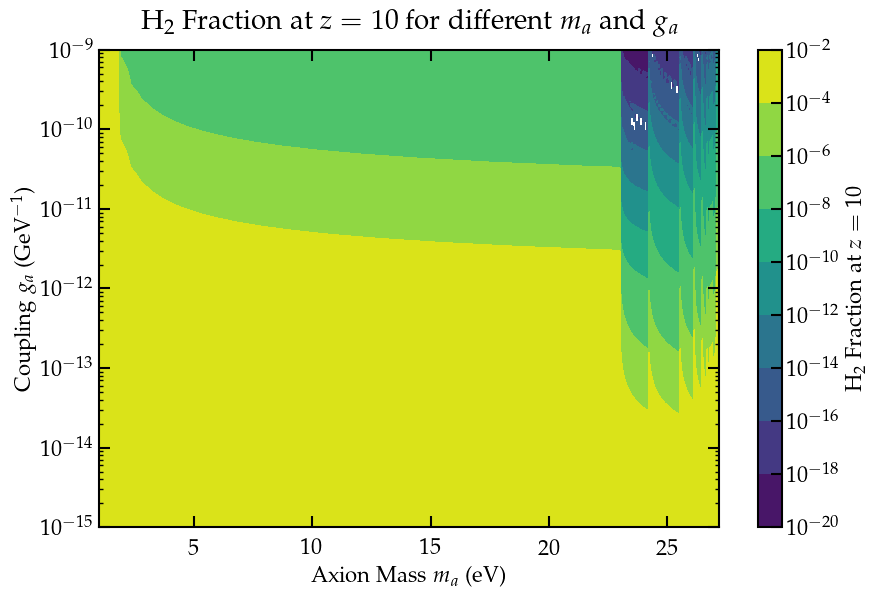

In [179]:
# Define meshgrid
X, Y =np.meshgrid(ma_fin, ga_fin)

# Plotting the contour
plt.figure(figsize=(10, 6.2))
ax = plt.gca()

contour = plt.contourf(X, Y ,h2_frac_z10_fin, 
                       norm=LogNorm(),
                       levels=50, 
                       cmap="viridis")

cbar = plt.colorbar(contour)

ax.set_yscale('log')

cbar.set_label(r"H$_2$ Fraction at $z=10$")
plt.xlabel(r"Axion Mass $m_a$ (eV)")
plt.ylabel(r"Coupling $g_a$ (GeV$^{-1}$)")
plt.title(r"H$_2$ Fraction at $z=10$ for different $m_a$ and $g_a$")

# Save the plot 
plt.savefig('./plots/xH2_z10_scan.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [180]:
# Define critical H2 fraction at z=10

crit_H2_z10 = crit_H2(10, 1e+9 ,9)

print(crit_H2_z10)

[1.51169718e-06]


In [181]:
# Define a matrix that meets the critical criteria 

DCBH_results = np.zeros_like(h2_frac_z10_fin)

print(DCBH_results.shape)

(120, 150)


In [182]:
# Calculate the halo growth rate d(ln M / dt)

# This is for dynamical growth term 


def dlnM_dt (z): 

    def mah (z): 
        return MAH(1e+9,z)
        
    deriv = derivative(mah, z, dx=1e-5)

    val = - 1 / mah(z) * deriv * (1+z) * phys.Hubble(z)
    return val

## 1. Get Critical H2 fractions 

In this section, we finally compare the resultant $H_2$ fraction with critical fraction for Atomic Cooling Halos. 

This is based on 2 time scales: Hubble time (conservative), and free-fall time (realistic)

In [183]:
# Get Boolean answers for exclusion region 
DCBH_results = h2_frac_z10_fin < crit_H2(10, 1e+9, 9)

# Get Halos that cool faster than hubble but slower than 6tff 
# Define ratio of dynamical time to hubble time 
t_dyn_hubble = (2/3 * dlnM_dt(10) )**(-1) / t_ff(zvir(m0_base))
tff6_results = h2_frac_z10_fin < crit_H2(10, 1e+9, t_dyn_hubble)

# Get halos that can cool faster than 6tff but not tff 
tff_results = h2_frac_z10_fin < crit_H2(10, 1e+9, 1)

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/3414227453.py:11: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  deriv = derivative(mah, z, dx=1e-5)


## 2. Import Existing Bounds 

In this section, we import existing bounds for decaying axions. 

In [184]:
# Import Combined Bounds from multiple searches 

# Read file 
axion_bounds_data=pd.read_csv('Combined_DarkMatterAstro.txt', header=None, delimiter=' ')
axion_bounds_data = axion_bounds_data.T


In [185]:
pd.DataFrame(axion_bounds_data)

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
0,1.000000e-25,1.001705e-25,1.003414e-25,1.005125e-25,1.006839e-25,1.008556e-25,1.010276e-25,1.011999e-25,1.013725e-25,1.015454e-25,...,9.847815e+11,9.864609e+11,9.881432e+11,9.898284e+11,9.915165e+11,9.932074e+11,9.949012e+11,9.965979e+11,9.982975e+11,1.000000e+12
1,9.670232e-17,9.686724e-17,9.703243e-17,9.719791e-17,9.736367e-17,9.752972e-17,9.769604e-17,9.786266e-17,9.802955e-17,9.819673e-17,...,8.677524e-31,8.815374e-31,8.955413e-31,9.097678e-31,9.242202e-31,9.389022e-31,9.538175e-31,9.689697e-31,9.843626e-31,1.000000e-30


In [186]:
ma_bound_list = axion_bounds_data.iloc[0]
ga_bound_list = axion_bounds_data.iloc[1]

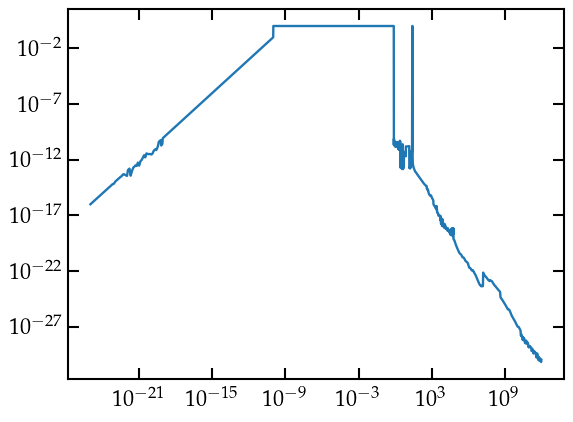

In [187]:
plt.figure()
plt.plot(ma_bound_list, ga_bound_list )

plt.yscale('log')
plt.xscale('log')

In [188]:
# Import CMB bound from Xu's paper 

CMB_bouds_data = pd.read_csv('/Users/yash/Desktop/Superradiance/bounds/CMB_xu_data.csv',header=None, delimiter=',')
CMB_bouds_data = CMB_bouds_data.apply(pd.to_numeric, errors='coerce')
CMB_bounds = CMB_bouds_data.T

In [189]:
pd.DataFrame(CMB_bounds)

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,1.651432e+01,1.656938e+01,1.665198e+01,1.670705e+01,1.676211e+01,1.684471e+01,1.689978e+01,1.698238e+01,1.706498e+01,1.720264e+01,...,2.681167e+01,2.683921e+01,2.689427e+01,2.694934e+01,2.700441e+01,2.708700e+01,2.714207e+01,2.722467e+01,2.727974e+01,2.733480e+01
1,1.125746e+20,1.495881e+20,1.765686e+20,2.291302e+20,2.769407e+20,3.593814e+20,4.242013e+20,5.504790e+20,6.497663e+20,8.431909e+20,...,1.668101e+22,2.876390e+22,4.843789e+22,8.967573e+22,1.700015e+23,3.804056e+23,1.104612e+24,2.591673e+24,4.798107e+24,1.000000e+25


In [190]:
print(type(CMB_bounds.iloc[1][1]))

<class 'numpy.float64'>


In [191]:
# Convert decay life time to g_a\gamma coupling 
CMB_bounds_ga_list = np.empty_like(CMB_bounds.iloc[0])

for i,ma in enumerate(CMB_bounds.iloc[0]): 
    
    # Define decay rate in s^(-1) 
    decay_rate = CMB_bounds.iloc[1][i]

    # Define conversion 
    InvSec_to_GeV = 6.58e-25
    
    # Convert decay rate to GeV
    decay_rate = decay_rate
    
    val = 64*np.pi / (ma*1e-9)**3 / decay_rate
    val = np.sqrt(val*InvSec_to_GeV)
    CMB_bounds_ga_list[i] = val

In [192]:
""" 
In this part, I add critical curve for monolithic collapse case,
using critical curve from Wolcott-Green 2018.
"""

A, B = np.meshgrid(2*ma_fin_2, ga_fin)

C = k_LW(10, A, B) - 1e-9

In [193]:
1/gamma_decay(25.104,1.444e-11)

4.009803527249316e+22

In [194]:
""" 
Old. Yifan Lu's prediction from in-situ decay and adiabatic contraction. 

"""

# Add data by Yifan_Lu 

Relic_axion_1_data = pd.read_csv('/Users/yash/Desktop/Superradiance/bounds/Yifan_Lu_1.csv',header=None, delimiter=',')
Relic_axion_1_data = Relic_axion_1_data.apply(pd.to_numeric, errors='coerce') 

Relic_axion_0p5_data = pd.read_csv('/Users/yash/Desktop/Superradiance/bounds/Yifan_Lu_0.5.csv',header=None, delimiter=',')
Relic_axion_0p5_data = Relic_axion_0p5_data.apply(pd.to_numeric, errors='coerce') 

Relic_axion_0p1_data = pd.read_csv('/Users/yash/Desktop/Superradiance/bounds/Yifan_Lu_0.1.csv',header=None, delimiter=',')
Relic_axion_0p1_data = Relic_axion_0p1_data.apply(pd.to_numeric, errors='coerce') 


In [195]:
# Extract data 
Relic_axion_1 = Relic_axion_1_data.T 
Relic_axion_0p5 = Relic_axion_0p5_data.T 
Relic_axion_0p1 = Relic_axion_0p1_data.T 

In [196]:
1/gamma_decay(25,1e-11)

8.465765466515651e+22

## 3. High Redshift Estimate 

In this section, I estimate H2 fraction at high redshifts due to axion decay. 
To do this I've created a toy model of baryons inside a halo. 

In [197]:
# Define a toy model assuming halos have reached atomic cooling limit and at the same density as our model halo. 

n_toy = 0.1 
temp_toy = 1e+4
xe_toy = 2e-4

In [198]:
# Based on the toy model now I want to show which axion parameters will satisfy ACH criteria at higher redshifts. 

# Define axion mass range 
# create a grid for valies 
ma_toy = 2*np.linspace(11.5, 13.595, 100)

# Create a grid for ga gamma space
ga_toy = 10**np.linspace(-15, -9, 120)

In [199]:
# Higher redshift contribution 
U,V = np.meshgrid(ma_toy, ga_toy)


In [200]:
# Define equilibrium H2 fractionA 


def xH2_eq (z, ma, ga):

    # Call photodetachment rates
    kpd = k_pd(z, ma, ga) 
    # Call LW dissociation rates 
    klw = k_LW(z, ma, ga) 

    # H2 formation term with H- channel 
    H2_form = phys.C_Hminus (temp_toy) * xe_toy * n_toy 

    # Photodetachment suppression term 
    pd_term = 1 + kpd/(phys.C_H2(1e+4)*n_toy ) 

    # LW suppression term 
    lw_term = klw 

    # H2 equilibrium fraction 
    xh2_eq = H2_form / pd_term / lw_term

    return xh2_eq

In [201]:
# Define different grids for different redshifts 

Toy_20 = np.zeros((len(ga_toy), len(ma_toy)) )
Toy_30 = np.zeros((len(ga_toy), len(ma_toy)) )
Toy_40 = np.zeros((len(ga_toy), len(ma_toy)) )

In [202]:
# Generate H2 fractions at different redshifts 

# Extract the value at z=10 for each (ma, ga) combination
for j, ga in enumerate(ga_toy):
    for i, ma in enumerate(ma_toy):
        try:
            # Assuming results[j, i] gives the solution array for (ma, ga)
            Toy_20[j, i] = xH2_eq (20, ma, ga)
            Toy_30[j, i] = xH2_eq (30, ma, ga)
            Toy_40[j, i] = xH2_eq (40, ma, ga)
        except IndexError:
            # Handle cases where results are incomplete
            print(f"Skipping invalid result at ma={ma}, ga={ga}")


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/2652840475.py:21: RuntimeWarning: divide by zero encountered in divide
  xh2_eq = H2_form / pd_term / lw_term
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/361699769.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Toy_20[j, i] = xH2_eq (20, ma, ga)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/361699769.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Toy_30[j, i] = xH2_eq (30, ma, ga)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/361699769.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a sca

In [203]:
# Define a new critical H2 fraction for simplicity. 

def crit_H2_toy (z, si): 
    
    """ 
    Here z - redshift of observation for the base halo model we are considering. 
    si - a multiplicative factor that sets critical time scale relative to free fall time scale. 
    For Hubble time/age of the universe we use si = 9. 
    """
    
    # Ensure z is a numpy array
    z = np.atleast_1d(z)

    def crit_H2_func(xH2, z, si):
        # Define the inner function for fsolve
        return t_H2(xH2, 0.1, 1e+4) - si * t_ff_new(z)

    # Get the critical redshift zvir_value
    zvir_value = 50
    
    # Create a mask for valid z values
    mask = z <= zvir_value

    # Initialize an array to store the results (dtype=float to avoid issues with np.nan)
    fac = np.full(z.shape, np.nan, dtype=float)
    
    # Iterate over valid z values
    for i, valid in enumerate(mask):
        if valid:
            fac[i] = fsolve(crit_H2_func, 1e-7, args=(z[i], si))[0]  # Extract the root from fsolve

    fac[~mask] = np.nan
    
    return fac


In [204]:
# Create values for z=20 and 40. 

ACH_20 = Toy_20 < crit_H2_toy(20,9)
ACH_20_ff = Toy_20 < crit_H2_toy(20,1)

ACH_40 = Toy_40 < crit_H2_toy(40,9)
ACH_40_ff = Toy_40 < crit_H2_toy(40,1)


## 4. Create the main plot 

Combine all the results together to create the main plot. 

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/312037330.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Y ,tff_results,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/312037330.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Y ,DCBH_results,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_48983/312037330.py:34: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(A,B, C, norm=LogNorm(), colors=['grey'], levels=[0, C.max()], alpha=0.4)


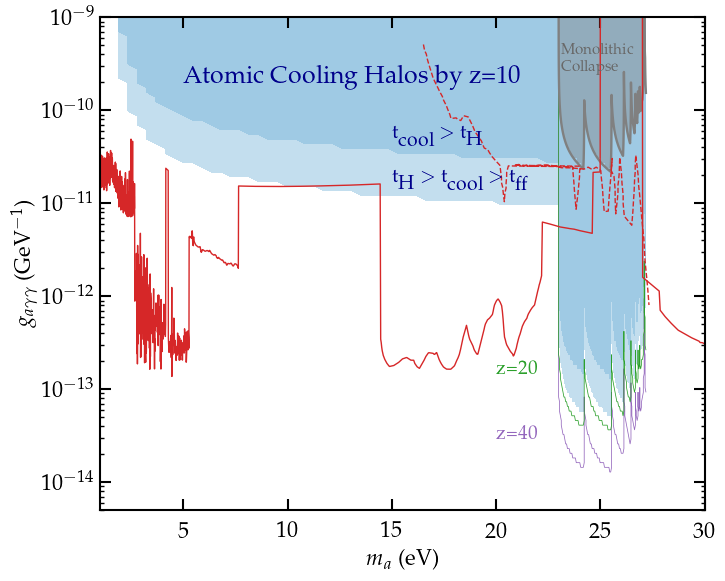

In [205]:
# Plot exclusion on ma vs ga space 
plt.figure(figsize=(7.8,6.4))
ax = plt.gca()
ax2 = plt.gca()


plt.contourf(X, Y ,tff_results, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)
"""
plt.contourf(X, Y ,tff6_results, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)
"""

plt.contourf(X, Y ,DCBH_results, 
                       norm=LogNorm(), 
                       cmap='Blues',
                        alpha=0.4)

# Plot analytical estimates at higher redshifts
# Plot z=40 results
z20_plt = ax2.contour(U, V ,ACH_40, 
                       levels=[0], colors=default_colors[4],linewidths=0.55)


# Plot z=20 results
z40_plt = ax2.contour(U, V ,ACH_20, 
                       levels=[0], colors=default_colors[2],linewidths=0.55)


plt.contourf(A,B, C, norm=LogNorm(), colors=['grey'], levels=[0, C.max()], alpha=0.4)

contour_1 = ax.contour(A,B,C, levels=[0], colors='grey')


# Add other axion bounds
plt.plot(ma_bound_list, ga_bound_list, linewidth=1, color=default_colors[3])

# Add CMB bounds 
plt.plot(CMB_bounds.iloc[0], CMB_bounds_ga_list, linewidth=1, linestyle='dashed', color=default_colors[3])

ax.set_yscale('log')

plt.xlabel(r"$m_a$ (eV)")
plt.ylabel(r"$g_{a \gamma \gamma}$ (GeV$^{-1}$)")

# Add text for z=20 and 40 plots 
plt.text(20,1.5e-13, 'z=20', fontsize=14, color=default_colors[2])
plt.text(20,3e-14, 'z=40', fontsize=14, color=default_colors[4])

plt.text(5, 2e-10, 'Atomic Cooling Halos by z=10', fontsize=18, color='darkblue')

plt.text(15, 5e-11, r't$_\textnormal{cool}$ $>$ t$_\textnormal{H}$', fontsize=14, color='darkblue')

#plt.text(15, 6e-12, r't$_\textnormal{H}$ $>$ t$_\textnormal{cool}$ $>$ 6t$_\textnormal{ff}$', 
#         fontsize=14, color='darkblue')

plt.text(15, 1.7e-11, r't$_\textnormal{H}$ $>$ t$_\textnormal{cool}$ $>$ t$_\textnormal{ff}$',
     fontsize=14, color='darkblue')

# Add DCBH text
plt.text(23.1, 4e-10, 'Monolithic', fontsize=11, color='dimgrey')
plt.text(23.1, 2.7e-10, 'Collapse', fontsize=11, color='dimgrey')

plt.ylim(5e-15,1e-9)
plt.xlim(1,30)

# Save the plot 
plt.savefig('./plots/DCBH.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [206]:
J_IGM (10, 25, 1e-13)

TypeError: J_IGM_func() missing 1 required positional argument: 'energy'

### (i) Time Decay Plot

This section converts the ma vs ga plot to ma vs time decay  curve. This is to generalize dark matter beyond axion decay. 

In [204]:
# Generate bounds on time decay rate 
bound_decay_time = 1 / gamma_decay (ma_bound_list, ga_bound_list)

In [205]:
bound_decay_time[1]

np.float64(1.402530771106377e+112)

In [206]:
1/gamma_decay(25,1e-14)

8.46576546651565e+28

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_22739/1362094509.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Z , tff_results,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_22739/1362094509.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Z , tff6_results,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_22739/1362094509.py:12: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Z , DCBH_results,


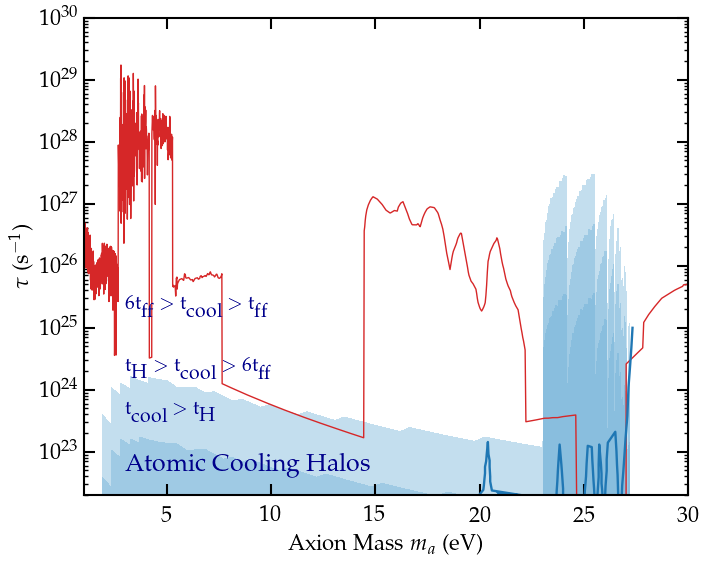

In [207]:
plt.figure(figsize=(7.8, 6.2))
ax = plt.gca()

plt.contourf(X, Z , tff_results, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)
plt.contourf(X, Z , tff6_results, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)
plt.contourf(X, Z , DCBH_results, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)

# Add bounds 
plt.plot(ma_bound_list, bound_decay_time, linewidth=1, color=default_colors[3])

plt.plot(CMB_bounds.iloc[0], CMB_bounds.iloc[1])

ax.set_yscale('log')

plt.xlim(1,30)
plt.ylim(2e+22, 1e+30)

plt.xlabel(r"Axion Mass $m_a$ (eV)")
plt.ylabel(r"$\tau$ (s$^{-1}$)")

plt.text(3, 5e+22, 'Atomic Cooling Halos', fontsize=18, color='darkblue')

plt.text(3, 4e+23, r't$_\textnormal{cool}$ $>$ t$_\textnormal{H}$', fontsize=14, color='darkblue')

plt.text(3, 2e+24, r't$_\textnormal{H}$ $>$ t$_\textnormal{cool}$ $>$ 6t$_\textnormal{ff}$', 
         fontsize=14, color='darkblue')

plt.text(3, 2e+25, r'6t$_\textnormal{ff}$ $>$ t$_\textnormal{cool}$ $>$ t$_\textnormal{ff}$',
         fontsize=14, color='darkblue')

plt.savefig('./plots/DCBH_time.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [208]:
1/gamma_decay(10, 1e-12)

1.3227758541430709e+26

In [209]:
# Create decay rate as a proxy for coupling constant, while keeping axion mass constant. 

# Create an empty matrix of the right size 
ma_time_grid = np.zeros((len(ma_fin), len(ga_fin)))

print(ma_time_grid.shape)

(150, 120)


# VI. Statistical distribution of DCBHs

Now that we have already shown that axion decay can populate DCBHs, and probably on large scales, we want to get an estimate on population statistics of DCBHs given some axion mass and decay rate. To do this we will use the [HaloMod](https://halomod.readthedocs.io/en/latest/examples/getting_started.html) python code. 

The code has already built in halo mass functions, cosmology, and any quantities dealing with halo statistics. For simplicity, we will stick to Press-Schechter halo mass function, since we are also using it for Mass Accretion Histories. 

In [3]:
print(f"Using halomod v{halomod.__version__} and hmf v{hmf.__version__}")

NameError: name 'halomod' is not defined

In [4]:
hm = TracerHaloModel(hmf_model = 'PS', z=10)

hm2 = TracerHaloModel(hmf_model = 'Tinker08', z=10)

hm3 = TracerHaloModel(hmf_model = 'SMT', z=10)


NameError: name 'TracerHaloModel' is not defined

In [5]:
plt.figure(figsize= (7.8, 6.2))
plt.plot(hm.m, hm.m*hm.dndm*np.log(10), label='Press-Schechter')
plt.plot(hm2.m, hm2.m*hm2.dndm*np.log(10), label ='Tinker08')
plt.plot(hm3.m, hm3.m*hm3.dndm*np.log(10), label ='SMT')


plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"Halo Mass [$h^{-1} M_\odot$]")
plt.ylabel(r"dn/d(log$_{10}$m) [$h^2 M_\odot^{-1} {\rm Mpc}^{-3}$]");

plt.xlim(1e+8, 1e+12)
plt.ylim(5e-6,20)

plt.legend()

plt.title('Galaxy Halo Mass Function')

plt.grid()

plt.text(3e+10, 2e-2, 'z=10', fontsize=14)

plt.show()

NameError: name 'plt' is not defined

In [6]:
hm_set2 = TracerHaloModel(
    z=10.0,  # Redshift
    hmf_model="PS",  # Sheth-Tormen mass function
)

hm_smt3 = TracerHaloModel( z=30, hmf_model='PS' )


NameError: name 'TracerHaloModel' is not defined

In [7]:
TracerHaloModel (z=20, hmf_model='PS').m

NameError: name 'TracerHaloModel' is not defined

In [8]:
plt.figure(figsize= (7.8, 6.2))
plt.loglog()

plt.plot(hm.m, hm.dndm, label='0')

plt.ylim(1e-20, 1e+10)
plt.xlim(1e+0, 1e+14)

plt.xlabel(r'Halo mass (h$^{-1}$ M$_\odot$)')
plt.ylabel(r'dn/dM (h$^2$ M$_\odot^{-1}$ Mpc$^{-3}$)')

plt.legend(title='z')

plt.grid()

NameError: name 'plt' is not defined

In [9]:
TracerHaloModel.cosmo_params

NameError: name 'TracerHaloModel' is not defined

In [10]:
# Define a function that integrates over hmf given a lower threshold and z. 

def  hmf_integrator_PS (z, M_min): 

    """
    Output is halo comoving number density in cMpc^(-3)
    """

    # Call hmf module at z 
    hmf = TracerHaloModel(
        z=z,  # Redshift
        hmf_model="PS",  # Press-Schechter mass function
    )

    mask = (hmf.m/phys.h >=  M_min) 

    # Define new variables 
    m_sub = hmf.m[mask] / phys.h
    dndm_sub = hmf.dndm[mask] * phys.h**2

    # Integrate using Simpson 
    integral = simpson(dndm_sub, x=m_sub)

    # Delete object 
    del hmf

    return integral 

def  hmf_integrator_SMT (z, M_min): 

    """
    Output is halo comoving number density in cMpc^(-3)
    """

    # Call hmf module at z 
    hmf = TracerHaloModel(
        z=z,  # Redshift
        hmf_model="SMT",  # Press-Schechter mass function
    )

    mask = (hmf.m/phys.h >=  M_min) 

    # Define new variables 
    m_sub = hmf.m[mask] / phys.h
    dndm_sub = hmf.dndm[mask] * phys.h**2

    # Integrate using Simpson 
    integral = simpson(dndm_sub, x=m_sub)

    # Delete object 
    del hmf

    return integral 


In [11]:
hmf_integrator_PS (20, 1e+5)

NameError: name 'TracerHaloModel' is not defined

In [219]:
MAH(1e+9,10)/1e+6

np.float64(43.39439500885355)

In [220]:
hmf_integrator_PS (10, MAH(1e+9,10))

np.float64(14.528316089781875)

In [221]:
# Define a new z_list 
z_list = np.linspace(10,100,100)

In [222]:
fill_mask = (z_list<=16)

In [1]:
# Define critical mass for Atomic Cooling Halos 

def m_halo_crit(z): 
    return 4e+7 *( (1+z)/11)**(-3/2)

In [2]:
plt.figure(figsize=(7.8,6.2)) 

plt.plot(np.linspace(10,100), m_halo_crit(np.linspace(10,100)))
plt.yscale('log')

plt.xlabel('z')
plt.ylabel(r'minimum mass for atomic cooling halos (M$_\odot$)')

plt.show()

NameError: name 'plt' is not defined

In [225]:
# Calculate comoving number density of halos that meet atomic cooling limit.
hmf_list_PS=np.zeros_like(z_list)
hmf_list_SMT=np.zeros_like(z_list)

for i,z in enumerate(z_list): 
    hmf_list_PS[i] = hmf_integrator_PS(z, 4e+7*((1+z)/11)**(-3/2) )
    hmf_list_SMT[i] = hmf_integrator_SMT(z, 4e+7*((1+z)/11)**(-3/2) )

In [226]:
# Import Brennan:2025 predictions

Brennan_simulation_300_data = pd.read_csv('/Users/yash/Desktop/Superradiance/bounds/Brennan_Simulation_300.csv',
                                         header=None, delimiter=',')
Brennan_simulation_300_data = Brennan_simulation_300_data.T

Brennan_numerical_300_data = pd.read_csv('/Users/yash/Desktop/Superradiance/bounds/Brennan_Numeric_300.csv',
                                         header=None, delimiter=',')
Brennan_numerical_300_data = Brennan_numerical_300_data.T


In [227]:
pd.DataFrame(Brennan_simulation_300_data)

,0,1,2,3,4,5,6,7
0,11.775234,12.482239,13.463742,14.476847,15.457469,1.643713e+01,1.744632e+01,1.830437e+01
1,0.000305,0.000412,0.000124,0.000072,0.000011,8.556412e-07,2.641648e-08,5.232991e-09


In [228]:
pd.DataFrame(Brennan_numerical_300_data)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1.004616e+01,1.026138e+01,1.047659e+01,1.069180e+01,1.093774e+01,1.127584e+01,11.675467,11.952045,12.228703,12.505280,...,2.592902e+01,2.638969e+01,2.681964e+01,2.724958e+01,2.761809e+01,2.826301e+01,2.866223e+01,2.909218e+01,2.955285e+01,2.998272e+01
1,4.697589e-07,5.296126e-07,5.970926e-07,6.731704e-07,7.589416e-07,8.556412e-07,0.000001,0.000001,0.000001,0.000001,...,3.480701e-07,3.087332e-07,2.738420e-07,2.428939e-07,2.154435e-07,1.799734e-07,1.596339e-07,1.415930e-07,1.255909e-07,1.049140e-07


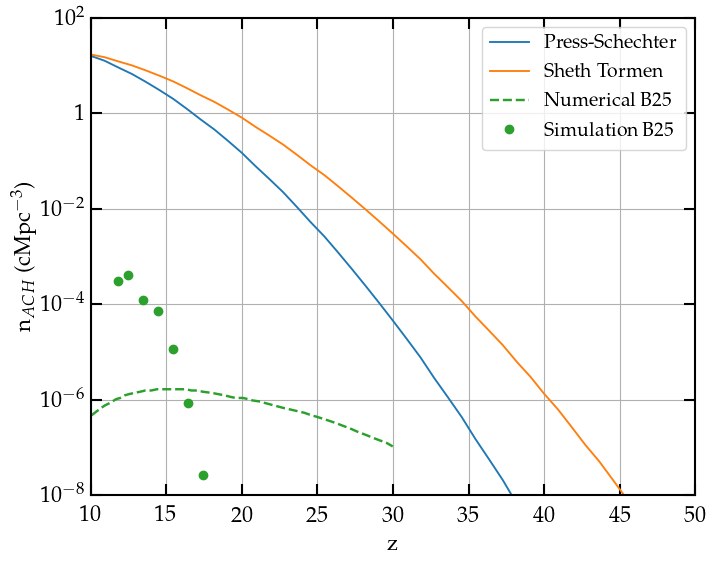

In [229]:
# Plot comoving number density of halos that meet atomic cooling limit 
plt.figure( figsize=(7.8, 6.2) )

plt.plot(z_list, hmf_list_PS, label='Press-Schechter', linewidth=1.35)
plt.plot(z_list, hmf_list_SMT, label='Sheth Tormen', linewidth=1.35)

plt.plot(Brennan_numerical_300_data.iloc[0], Brennan_numerical_300_data.iloc[1], 
         linestyle='dashed', color=default_colors[2], linewidth=1.75, label='Numerical B25')

plt.plot(Brennan_simulation_300_data.iloc[0], Brennan_simulation_300_data.iloc[1],
         marker='o', linestyle='None',color=default_colors[2], label='Simulation B25')

plt.yscale('log')
plt.ylim(1e-8,1e+2)
plt.xlim(10,50)

plt.legend()

plt.xlabel('z')
plt.ylabel('n$_{ACH}$ (cMpc$^{-3}$)')

plt.grid()

plt.savefig('./plots/ACH_number_density.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

# VII. Thermal Plot 

Produce plot for thermal rates. Heating from dynamical heating, and proxy Hubble time scale. 
Cooling plot from standard H2, and H-$\alpha$, and changes in H2 cooling from axion decay. 

In [269]:
# Calculate the halo growth rate d(ln M / dt)

# Define a proxy function 


def dlnM_dt (z): 

    def mah (z): 
        return MAH(1e+9,z)

    
    deriv = derivative(mah, z, dx=1e-5)

    val = - 1 / mah(z) * deriv * (1+z) * phys.Hubble(z)
    return val

In [270]:
dlnM_dt(20)

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/3519823458.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  deriv = derivative(mah, z, dx=1e-5)


np.float64(8.254471284703333e-16)

In [271]:
# Save Standard H2 history
t_H2(solution_base_xH2.y[0], nH_Halo(1, 1e+9, solution_base_xH2.t), T_halo(1, 1e+9, solution_base_xH2.t))

array([1.02881042e+21, 1.02504090e+21, 1.02118762e+21, ...,
       3.83028157e+12, 3.46140822e+12, 3.13644315e+12])

In [272]:
# Define H cooling time scale 

def t_H (xe, ncore, temp): 
    return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)

In [273]:
1/t_H (solution_base_xe.y[0], nH_Halo(1, 1e+9, solution_base_xe.t), T_halo(1, 1e+9, solution_base_xe.t))

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/2521747546.py:4: RuntimeWarning: divide by zero encountered in divide
  return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/2521747546.py:4: RuntimeWarning: overflow encountered in divide
  return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)


array([2.37716143e-150, 1.39086581e-150, 8.12707181e-151, ...,
       1.05565588e-016, 8.18431510e-017, 6.37285248e-017])

In [274]:
# Define New t_ff 

def t_ff_new (z): 

    # Define matter density in the halo 
    rho_m = 200*phys.RhoCrit*phys.Omega_m*(1+z)**3

    # Change units to g cm^-3
    rho_m = rho_m * phys.eV_to_ergs / (phys.cs**2) 

    val = (3 * np.pi / (32 * phys.G * rho_m) )**(1/2)

    return val
    

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/2521747546.py:4: RuntimeWarning: divide by zero encountered in divide
  return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/2521747546.py:4: RuntimeWarning: overflow encountered in divide
  return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/3519823458.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  deriv = derivative(mah, z, dx=1e-5)


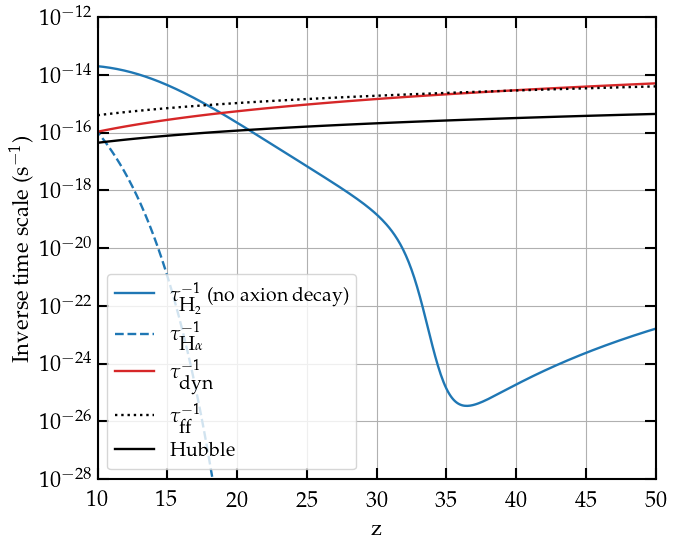

In [275]:
# Create a thermal plot for standard history. 
plt.figure(figsize=(7.2,6.0))

# Define a z space 
z_list = np.linspace(10,50,100)
z_eval=np.arange(119,0.5,-0.1)

# Show a plot for standard thermal history. 

# H2 cooling 
plt.plot(solution_base_xH2.t, 
         1/t_H2(solution_base_xH2.y[0], nH_Halo(1, 1e+9, solution_base_xH2.t), 
                T_halo(1, 1e+9, solution_base_xH2.t)),
        label=r'$\tau_{\textnormal{H}_2}^{-1}$ (no axion decay)', 
         color=default_colors[0])

# Add H-alpha cooling 
plt.plot(solution_base_xe.t, 
         1/t_H (2e-4, nH_Halo(1, 1e+9, solution_base_xe.t), 
                T_halo(1, 1e+9, solution_base_xe.t)),
        label=r'$\tau_{\textnormal{H}\alpha}^{-1}$',  color=default_colors[0], 
         linestyle='dashed')

# Add dynamical heating 
plt.plot(z_list, (2/3 * dlnM_dt(z_list)), label = r'$\tau_{\textnormal{dyn}}^{-1}$',
         color=default_colors[3])


# Plot free fall time 
plt.plot(z_list, 1/t_ff_new(z_list), color='black', 
         linestyle='dotted', label=r'$\tau_\textnormal{ff}^{-1}$')


# Add Hubble time 
plt.plot(z_list, phys.Hubble(z_list), label = r'Hubble', 
         color='black')


# Fill between t_ff and ceiling 
#plt.fill_between(z_list, phys.Hubble(z_list), 1e-12, 
#                 color='yellow', alpha=0.2, label=r'Above $t_{\rm ff}^{-1}$')

# plt.text(15.5, 1.5e-14, r'POP-III stars', color='goldenrod', fontsize=16)


plt.yscale('log')

plt.xlim(10,50)
plt.ylim(1e-28,1e-12) 

plt.xlabel('z')
plt.ylabel(r'Inverse time scale (s$^{-1}$)')

plt.grid()

plt.legend()

plt.savefig('./plots/Thermal_rates_standard.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/3519823458.py:12: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  deriv = derivative(mah, z, dx=1e-5)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/2521747546.py:4: RuntimeWarning: divide by zero encountered in divide
  return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_4998/2521747546.py:4: RuntimeWarning: overflow encountered in divide
  return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H_cool(xe, ncore, temp)


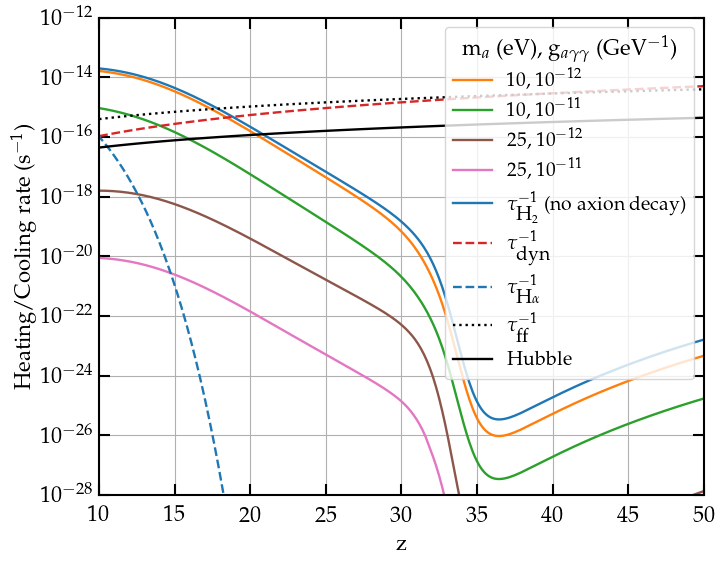

In [276]:
# Define a z space 
z_list = np.linspace(10,50,100)
z_eval=np.arange(119,0.5,-0.1)

plt.figure(figsize=(7.8,6.2))

# Add standard curves


# Add curves for axion decay 
plt.plot(z_eval, 
         1/t_H2(test_import[1,1], nH_Halo(1, 1e+9, z_eval), T_halo(1, 1e+9, z_eval)), 
         label=r'10, 10$^{-12}$', color=default_colors[1]) 

plt.plot(z_eval, 
         1/t_H2(test_import[1,0], nH_Halo(1, 1e+9, z_eval), T_halo(1, 1e+9, z_eval)), 
         label=r'10, 10$^{-11}$', color=default_colors[2]) 

plt.plot(z_eval, 
         1/t_H2(test_import[2,1], nH_Halo(1, 1e+9, z_eval), T_halo(1, 1e+9, z_eval)), 
         label=r'25, 10$^{-12}$', color=default_colors[5]) 

plt.plot(z_eval, 
         1/t_H2(test_import[2,0], nH_Halo(1, 1e+9, z_eval), T_halo(1, 1e+9, z_eval)), 
         label=r'25, 10$^{-11}$', color=default_colors[6]) 


plt.plot(solution_base_xH2.t, 
         1/t_H2(solution_base_xH2.y[0], nH_Halo(1, 1e+9, solution_base_xH2.t), T_halo(1, 1e+9, solution_base_xH2.t)),
        label=r'$\tau_{\textnormal{H}_2}^{-1}$ (no axion decay)', color = default_colors[0])


plt.plot(z_list, (2/3 * dlnM_dt(z_list)), label = r'$\tau_{\textnormal{dyn}}^{-1}$', color=default_colors[3],
        linestyle='dashed')

plt.plot(solution_base_xe.t, 
         1/t_H (2e-4, nH_Halo(1, 1e+9, solution_base_xe.t), T_halo(1, 1e+9, solution_base_xe.t)),
        label=r'$\tau_{\textnormal{H}\alpha}^{-1}$',  color=default_colors[0], linestyle='dashed')

# Plot free fall time 
plt.plot(z_list, 1/t_ff_new(z_list), color='black', 
         linestyle='dotted', label=r'$\tau_\textnormal{ff}^{-1}$')

# Add Hubble time 
plt.plot(z_list, phys.Hubble(z_list), label = r'Hubble', 
         color='black')


# Add curves for free fall time 
#plt.plot(z_eval, 1 / t_ff_new(z_eval), linestyle='dotted', color='black', label=r'Free-fall')

plt.yscale('log')

plt.legend(title=r'm$_a$ (eV), g$_{a \gamma \gamma}$ (GeV$^{-1}$)')

plt.grid()
plt.xlim(10,50)
plt.ylim(1e-28,1e-12)
plt.xlabel('z')
plt.ylabel(r'Heating/Cooling rate (s$^{-1}$)')

plt.savefig('./plots/Thermal_rates.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

# Tests from Henceforth 

The cells from here are mostly tests to check things, or produce desired plots 

## Contribution of Adiabatic Contraction 

In this section, I approximate the effect of adiabatic contraction. 

In [317]:
# import data file for K. Freese's prediction on adiabatic contraction. 
Freese_data_file = pd.read_csv('/Users/yash/Desktop/Superradiance/Adiabatic_contraction.csv')

# Import data file for K. Freese's standard dark matter density using NFW profile. 
Freese_NFW_file = pd.read_csv('/Users/yash/Desktop/Superradiance/Default_density_Freese.csv')

In [318]:
# Take in data values for adaibatic contracted profile. 
Freese_dist = Freese_data_file.T.iloc[0]
Freese_density = Freese_data_file.T.iloc[1]

Freese_NFW_dist = Freese_NFW_file.T.iloc[0]
Freese_NFW_density = Freese_NFW_file.T.iloc[1]

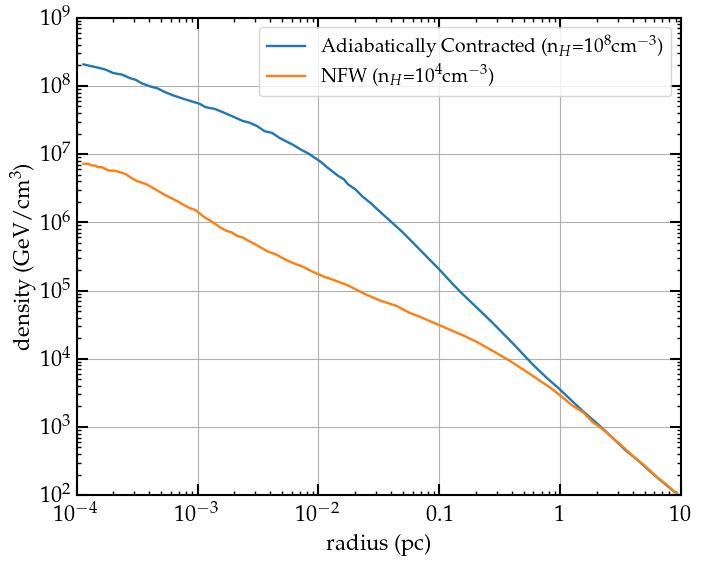

In [239]:
plt.figure(figsize=(7.8,6.2))
plt.loglog()

plt.plot(Freese_dist, Freese_density, label='Adiabatically Contracted (n$_H$=10$^8$cm$^{-3}$)')
plt.plot(Freese_NFW_dist, Freese_NFW_density, label='NFW (n$_H$=10$^4$cm$^{-3}$)')

plt.grid()
plt.xlabel('radius (pc)')
plt.ylabel(r'density (GeV/cm$^3$)')

plt.legend()

plt.xlim(1e-4, 10)
plt.ylim(1e+2,1e+9)

plt.savefig('./plots/Freese_contraction.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [240]:
# Calculate D Factor 
D_Freese = 1e+9*phys.pc_to_cm*np.trapz(Freese_density, Freese_dist)
print(f'D factor for adiabatic contracted halo:{D_Freese}')

D factor for adiabatic contracted halo:1.2238642017527337e+33


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_22739/126173325.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D_Freese = 1e+9*phys.pc_to_cm*np.trapz(Freese_density, Freese_dist)


In [241]:
D_Freese_NFW = 1e+9*phys.pc_to_cm*np.trapz(Freese_NFW_density, Freese_NFW_dist )
print(f'D factor for NFW halo:{D_Freese_NFW}')

D factor for NFW halo:7.31236163334309e+31


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_22739/1538409085.py:1: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D_Freese_NFW = 1e+9*phys.pc_to_cm*np.trapz(Freese_NFW_density, Freese_NFW_dist )


### D factor to estimate in-situ contribution

In [242]:
D_halo(10,5e+7)

np.float64(1.0859117221328492e+32)

In [243]:
MAH(1e+9,10)

np.float64(43394395.00885355)

In [244]:
# Define a D-factor again to check in-situ contribution. 

def D_halo_2 (z, mhalo, r):
    # Define halo concentration parameter
    ch = 4 

    # Define NFW density parameter in msol/pc^3
    rho0 = mhalo * ch**3 / (4 * np.pi * phys.Rvir(z, mhalo)**3 * (np.log(1 + ch) - ch/(1+ch) ) )

    # Convert density parameter to eV/cm^3 
    rho0 = rho0 * phys.msol_to_grams * phys.cs**2 /phys.eV_to_ergs / phys.pc_to_cm**3

    # Define limits of integrand 
    a = ch * 1e-4 / phys.Rvir(z,mhalo)
    b = ch * r / phys.Rvir(z,mhalo)

    # Define integrand 
    def integrand(x):
        return 1/x/(1+x)**2 

    integral, error = quad(integrand, 1e-4*ch / phys.Rvir(z,mhalo), r*ch / phys.Rvir(z,mhalo))

    def func(a,b): 
        val_1 = 1/(b+1) - 1/(a+1)
        val_2 = np.log( (a / (1+a))* ( (b+1)/b ) )
        return - (val_1 + val_2) 
    
    return rho0*phys.Rvir(z,mhalo)*phys.pc_to_cm / ch * func (a,b)

In [245]:
D_frac = D_halo_2(10, MAH(1e+9,10) , 0.1 * phys.Rvir(10,5e+7) ) / D_halo_2(10,MAH(1e+9,10), 1000 * phys.Rvir(10,5e+7) )

In [246]:
print(f'The fraction of local halo intensity internal to halo core is {D_frac}')

The fraction of local halo intensity internal to halo core is 0.8779821732096231


## Plot NFW Profile

In [247]:
# Define NFW halo 

def NFW (z, mhalo, r): 

    """ 
    Returns dark matter density in ev/cm^3
    """

    # Define halo concentration parameter
    ch = 4 

    # Define NFW density parameter in msol/pc^3
    rho0 = mhalo * ch**3 / (4 * np.pi * phys.Rvir(z, mhalo)**3 * (np.log(1 + ch) - ch/(1+ch) ) )

    # Convert density parameter to eV/cm^3 
    rho0 = rho0 * phys.msol_to_grams * phys.cs**2 /phys.eV_to_ergs / phys.pc_to_cm**3

    x = r * ch / phys.Rvir(z,mhalo)

    val = rho0 / x /(1+x)**2

    return val

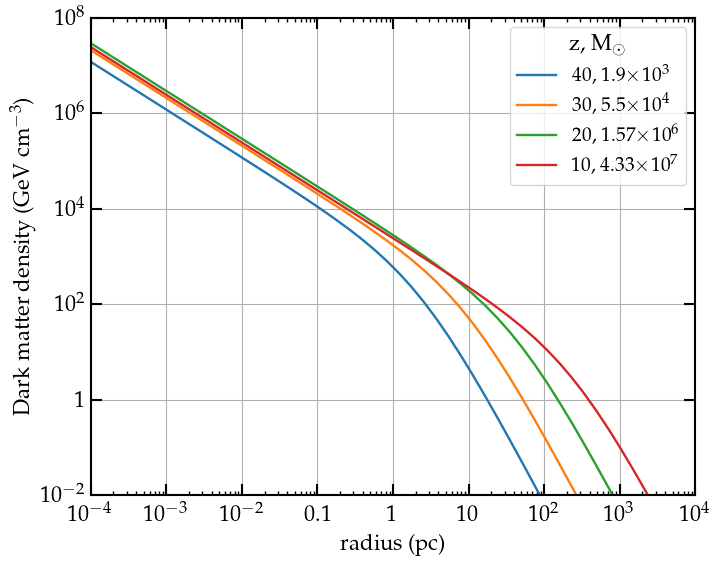

In [248]:
# Define radius list 
rad_list = 10**np.linspace(-4,4)

# Plot NFW profile 
plt.figure(figsize=(7.8,6.2)) 
plt.loglog()

plt.plot ( rad_list,  NFW(40,MAH(1e+9,40), rad_list) /1e+9, label=r'40, 1.9$\times10^{3}$' )
plt.plot ( rad_list,  NFW(30,MAH(1e+9,30), rad_list) /1e+9, label=r'30, 5.5$\times10^{4}$'  )
plt.plot ( rad_list,  NFW(20,MAH(1e+9,20), rad_list) /1e+9, label=r'20, 1.57$\times10^{6}$' )
plt.plot ( rad_list,  NFW(10,MAH(1e+9,10), rad_list) /1e+9, label=r'10, 4.33$\times10^{7}$' )

plt.xlim(1e-4,1e+4)
plt.ylim(1e-2,1e+8)

plt.xlabel(r'radius (pc)')
plt.ylabel(r'Dark matter density (GeV cm$^{-3}$)')

plt.legend(title=r'z, M$_\odot$')

plt.grid()

plt.savefig('./plots/NFW.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


## Estimate to determine Gravitational Blueshift 

In this section, I estimate how much a photon blueshifts as it fall deeper into the gravitational potential well of the halo. 

In [249]:
# Define NFW enclosed mass 

def M_NFW(z, mhalo, r): 
    """ 
    Returns enclose halo mass within NFW halo from 0 to r. [units: M_sol] 

    Mhalo - total halo mass or mass at Rvir
    """

    # unit conversion for integrand 
    const = phys.eV_to_ergs / phys.cs**2 / phys.msol_to_grams * phys.pc_to_cm**3

    # Define integrand 
    integrand = lambda x: NFW(z, mhalo, x) * 4 * np.pi * x**2 * const
    
    # Integrate 
    result, error = quad(integrand, 0, r)

    return result

In [250]:
M_NFW (20, 1e+8, phys.Rvir(20, 1e+8) ) /1e+6

100.00000000000006

In [251]:
masses = [M_NFW(10, 1e+8, r) for r in rad_list]

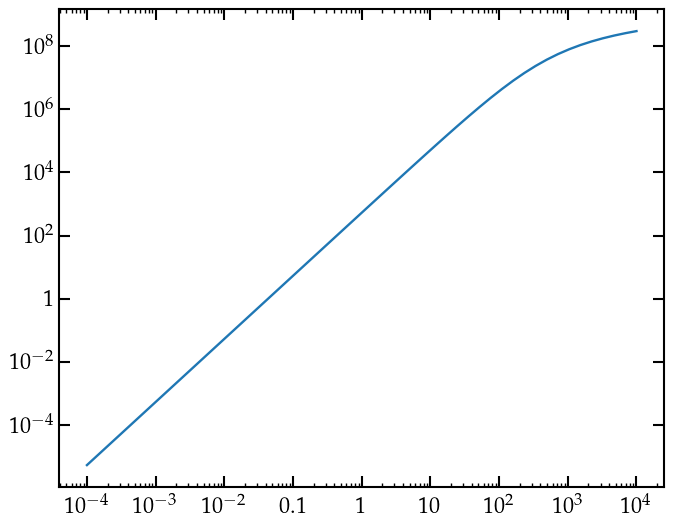

In [252]:
# Plot enclosed mass 

plt.figure(figsize=(7.8,6.2))
plt.loglog()

plt.plot(rad_list, masses )

In [253]:
# Define blueshift 
def blueshift (z, mhalo, r_max): 
    """ 
    Returns the gravitational blueshift factor for a photon that travels from r_max to  0
    """

    # Define unit conversions
    const = phys.msol_to_grams / phys.pc_to_cm * phys.G / phys.cs**2

    # Define integrand 
    integrand = lambda x: M_NFW(z, mhalo, x) * const / x**2

    # Integrate 
    result, error = quad(integrand, 0, r_max)

    return np.exp(result)

In [214]:
print(f' {blueshift (10,5e+7, phys.Rvir(10, 5e+7)) - 1:.8e}')

 6.53437704e-09


In [215]:
print(f'{NFW(10, 1e+9, 1e-4)/25/1e+4:.2e}')

2.77e+11


## Test for Critical Curves at higher redshifts. 

In this section, we estimate the critical LW flux at zone of no return. 

In [216]:
xH2C_zone_no_return = 1e-6

# Under steady state approximation 

kLW_critical = phys.C_Hminus(8e+3) * 1e-4 * 1e+4 / 1e-6

In [217]:
kLW_critical = 1.38e-12*75

In [218]:
print(kLW_critical)

1.035e-10


In [219]:
k_LW ( 10,25,1e-10)

np.float64(1.588876853129393e-08)

In [220]:
ma_fin_2

array([11.5       , 11.52116162, 11.54232323, 11.56348485, 11.58464646,
       11.60580808, 11.6269697 , 11.64813131, 11.66929293, 11.69045455,
       11.71161616, 11.73277778, 11.75393939, 11.77510101, 11.79626263,
       11.81742424, 11.83858586, 11.85974747, 11.88090909, 11.90207071,
       11.92323232, 11.94439394, 11.96555556, 11.98671717, 12.00787879,
       12.0290404 , 12.05020202, 12.07136364, 12.09252525, 12.11368687,
       12.13484848, 12.1560101 , 12.17717172, 12.19833333, 12.21949495,
       12.24065657, 12.26181818, 12.2829798 , 12.30414141, 12.32530303,
       12.34646465, 12.36762626, 12.38878788, 12.40994949, 12.43111111,
       12.45227273, 12.47343434, 12.49459596, 12.51575758, 12.53691919,
       12.55808081, 12.57924242, 12.60040404, 12.62156566, 12.64272727,
       12.66388889, 12.68505051, 12.70621212, 12.72737374, 12.74853535,
       12.76969697, 12.79085859, 12.8120202 , 12.83318182, 12.85434343,
       12.87550505, 12.89666667, 12.91782828, 12.9389899 , 12.96

In [221]:
ga_fin

array([1.00000000e-15, 1.12310450e-15, 1.26136372e-15, 1.41664327e-15,
       1.59103844e-15, 1.78690243e-15, 2.00687817e-15, 2.25393390e-15,
       2.53140332e-15, 2.84303046e-15, 3.19302031e-15, 3.58609548e-15,
       4.02755998e-15, 4.52337074e-15, 5.08021805e-15, 5.70561576e-15,
       6.40800274e-15, 7.19685673e-15, 8.08282219e-15, 9.07785399e-15,
       1.01953787e-14, 1.14504757e-14, 1.28600808e-14, 1.44432146e-14,
       1.62212394e-14, 1.82181470e-14, 2.04608829e-14, 2.29797097e-14,
       2.58086154e-14, 2.89857721e-14, 3.25540512e-14, 3.65616014e-14,
       4.10624992e-14, 4.61174777e-14, 5.17947468e-14, 5.81709133e-14,
       6.53320146e-14, 7.33746797e-14, 8.24074331e-14, 9.25521591e-14,
       1.03945747e-13, 1.16741936e-13, 1.31113394e-13, 1.47254043e-13,
       1.65381678e-13, 1.85740907e-13, 2.08606449e-13, 2.34286842e-13,
       2.63128607e-13, 2.95520924e-13, 3.31900880e-13, 3.72759372e-13,
       4.18647729e-13, 4.70185149e-13, 5.28067057e-13, 5.93074490e-13,
      

In [222]:
X, Y = np.meshgrid(2*ma_fin_2, ga_fin)
Z = k_LW(10, X, Y) - kLW_critical

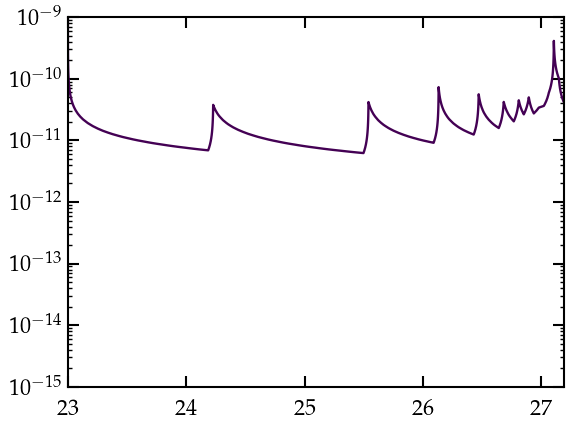

In [223]:
plt.figure()
ax = plt.gca()

plt.contour(X, Y, Z, levels=[0] ) 

ax.set_yscale('log')

In [224]:
1/gamma_decay(25,1e-10)

8.465765466515649e+20

### Redefine Base (no Axion decay) Halo Histories

We want to create base halo history plots for ionization fraction, H2 fraction, and critical H2 fraction.

First, we need to check how does the number density scale when the halo collapses. [Visbal:2014](https://academic.oup.com/mnrasl/article/442/1/L100/955995), [Nebrin:2023](https://arxiv.org/pdf/2303.08024), and [Hegde:2023](https://arxiv.org/pdf/2304.03358) show that the density in the core of halos can fall into two regimes: 

$$ 
n_{\textnormal{core}} = 
\begin{cases} 
1.2 M_6 \left(\frac{1+z_{\textnormal{vir}}}{10} \right)^{3/2} \ \text{cm}^{-3} & \text{for }M_6 \leq 2.92\left(\frac{1+z_{\textnormal{vir}}}{10} \right)^{3/2}  \\ 
3.5\left(\frac{1+z_{\textnormal{vir}}}{10} \right)^{3} \ \text{cm}^{-3}& \text{for }M_6 > 2.92 \left(\frac{1+z_{\textnormal{vir}}}{10} \right)^{3/2} \ . \\ 
\end{cases}
$$
Here, $M_6 = M_\textnormal{halo}/10^6 M_\odot$. This equation simply implies that the core density in the halo can fall into two regimes. For smaller halos given at a given redshift, the central density at the time of collapse scales as the virial temperature. Whereas for more massive halos, the central core density is independent of halo mass at a given redshift. 

In [225]:
# Check to see in which core density category halos that follow MAH from PS fall in to
mhalo_list = 10**np.linspace(9,16,10)

print('The following halos are in low mass category:')
for mhalo in mhalo_list: 
    val = MAH(mhalo, zvir(mhalo)) / 1e+6 <= 2.92*zvir((1 + zvir(mhalo))/10)**(3/2)
    print(f'{mhalo:.2e} : {val}')

The following halos are in low mass category:
1.00e+09 : [ True]
5.99e+09 : [ True]
3.59e+10 : [ True]
2.15e+11 : [ True]
1.29e+12 : [ True]
7.74e+12 : [ True]
4.64e+13 : [ True]
2.78e+14 : [ True]
1.67e+15 : [ True]
1.00e+16 : [ True]


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/139448003.py:4: RuntimeWarning: invalid value encountered in power
  return M0 * (1+z)**(afac*ffac(M0)) * np.exp(-ffac(M0)*z)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/3386421627.py:2: RuntimeWarning: invalid value encountered in power
  return 1.66e+4 * ((1+z)/21)**(0.85)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/445008769.py:2: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(lambda z: MAH(M0, z) - filter_mass(z), 10)


Above cell implies that the halos histories generated using PS all fall into low mass categories. That is their core densities at the time of virialization scales as virial temperature. 

### Statistical run on halo grid

In [226]:
# Define a halo mass grid observed at z=0 

halo_mass_grid = 10**np.arange(9.25,15.25,0.25)

In [227]:
halo_mass_grid

array([1.77827941e+09, 3.16227766e+09, 5.62341325e+09, 1.00000000e+10,
       1.77827941e+10, 3.16227766e+10, 5.62341325e+10, 1.00000000e+11,
       1.77827941e+11, 3.16227766e+11, 5.62341325e+11, 1.00000000e+12,
       1.77827941e+12, 3.16227766e+12, 5.62341325e+12, 1.00000000e+13,
       1.77827941e+13, 3.16227766e+13, 5.62341325e+13, 1.00000000e+14,
       1.77827941e+14, 3.16227766e+14, 5.62341325e+14, 1.00000000e+15])

### Redo standard ionization histories

In [228]:
"""
Define differential equation for electron recombination
"""


# Define redshift range of interest
z_span = (120, 0)
z_eval=np.arange(120,0,-0.1)

# Solve the ODE 
solution_base_xe = solve_ivp(
                        dxe_dz_base, # Differential equation to be solved
                        z_span, # Domain of the 
                        [2e-4], 
                        args=(1e+9,), 
                        t_eval= z_eval, 
                        rtol=1e-10, atol=1e-10 )

# Solve the ODE 
solution_base_xe_2 = solve_ivp(
                        dxe_dz_base, # Differential equation to be solved
                        z_span, # Domain of the 
                        [2e-4], 
                        args=(1e+12,), 
                        t_eval= z_eval, 
                        rtol=1e-10, atol=1e-10 )

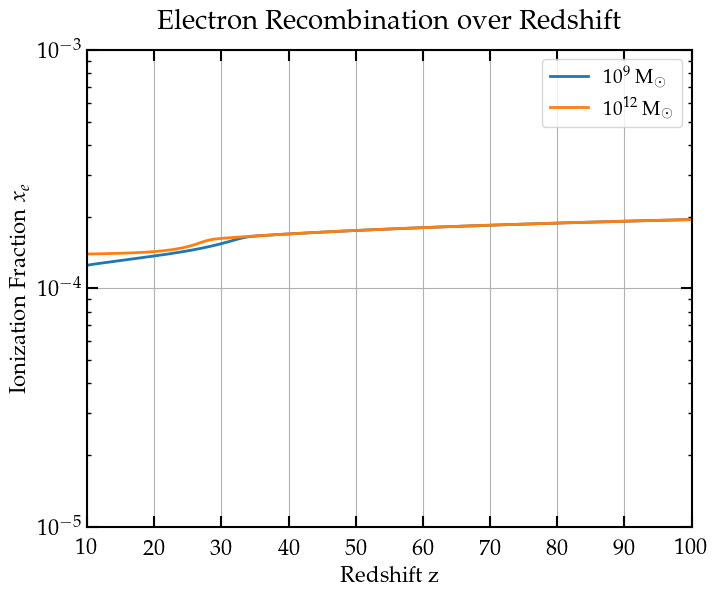

In [229]:
# Plot the results

plt.figure(figsize=(7.8, 6.2))

plt.plot(solution_base_xe.t, solution_base_xe.y[0], label=r'10$^9$ M$_\odot$', 
         linewidth=2)
plt.plot(solution_base_xe_2.t, solution_base_xe_2.y[0], label=r'10$^{12}$ M$_\odot$', 
         linewidth=2)
plt.xlabel('Redshift z')
plt.ylabel(r'Ionization Fraction $x_e$')
plt.title('Electron Recombination over Redshift')
plt.yscale('log')

plt.legend()
plt.ylim(1e-5,1e-3)
plt.xlim(10,100)
plt.grid()

plt.show()

Barely any difference in ionization fraction for different mass accretion histories. 

In [230]:
import os

# Get current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)


Current working directory: /Users/yash/Desktop/Superradiance/AxionCode


##  Toy Model for DCBHs at higher redshifts

In this section, instead of solving for a complete evolution, I basically employ a toy model inspired from our original analysis to figure out part of axion parameter space capable of triggering ACH cooling. 

In [231]:
# Redefine H2 cooling time scale 

# Define a function to calculate H2 cooling time scale 

def t_H2(xH2, ncore, temp): 
    return  3 * ncore * phys.kB * temp * phys.eV_to_ergs / 2 / phys.lambda_H2_cool(xH2, ncore, temp)

In [232]:
# Define a toy model assuming halos have reached atomic cooling limit and at the same density as our model halo. 

n_toy = 0.1 
temp_toy = 1e+4
xe_toy = 2e-4

First, I want to describe an equilibrium H2 fraction with the inclusion of LW and pd dissociation rates in the halos that have just reached atomic cooling limit. 

In [233]:
# Define equilibrium H2 fractionA 


def xH2_eq (z, ma, ga):

    # Call photodetachment rates
    kpd = k_pd(z, ma, ga) 
    # Call LW dissociation rates 
    klw = k_LW(z, ma, ga) 

    # H2 formation term with H- channel 
    H2_form = phys.C_Hminus (temp_toy) * xe_toy * n_toy 

    # Photodetachment suppression term 
    pd_term = 1 + kpd/(phys.C_H2(1e+4)*n_toy ) 

    # LW suppression term 
    lw_term = klw 

    # H2 equilibrium fraction 
    xh2_eq = H2_form / pd_term / lw_term

    return xh2_eq

In [234]:
xH2_eq (np.array([10,20,30,40]), 2*11.6, 2e-13)

array([4.13843196e-06, 1.49861207e-06, 7.90891872e-07, 4.89216947e-07])

In [235]:
# Define a new critical H2 fraction for simplicity. 

def crit_H2_toy (z, si): 
    
    """ 
    Here z - redshift of observation for the base halo model we are considering. 
    si - a multiplicative factor that sets critical time scale relative to free fall time scale. 
    For Hubble time/age of the universe we use si = 36.3. 
    """
    
    # Ensure z is a numpy array
    z = np.atleast_1d(z)

    def crit_H2_func(xH2, z, si):
        # Define the inner function for fsolve
        return t_H2(xH2, 0.1, 1e+4) - si * t_ff_new(z)

    # Get the critical redshift zvir_value
    zvir_value = 50
    
    # Create a mask for valid z values
    mask = z <= zvir_value

    # Initialize an array to store the results (dtype=float to avoid issues with np.nan)
    fac = np.full(z.shape, np.nan, dtype=float)
    
    # Iterate over valid z values
    for i, valid in enumerate(mask):
        if valid:
            fac[i] = fsolve(crit_H2_func, 1e-7, args=(z[i], si))[0]  # Extract the root from fsolve

    fac[~mask] = np.nan
    
    return fac


In [236]:
crit_H2_toy (50, 9) 

array([2.65643875e-05])

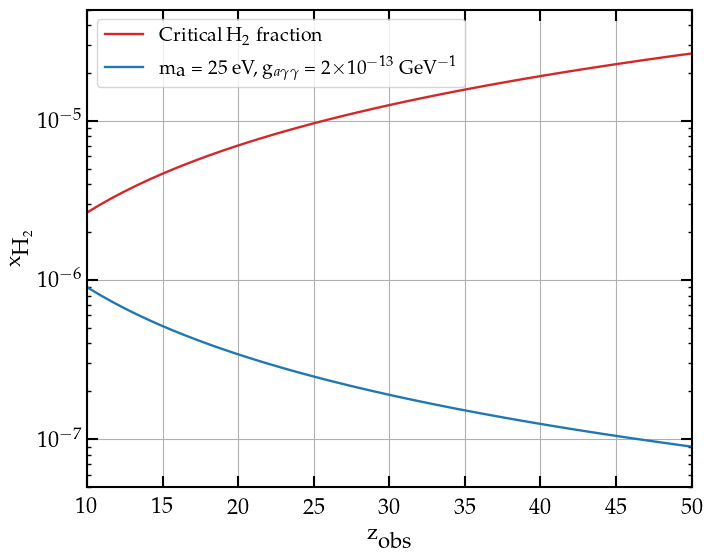

In [237]:
# Plot curve of evolveing critical H2 fraction vs H2 equilibrium value with axion decay 

z_list = np.linspace(10,50)

plt.figure(figsize=(7.8,6.2))

# Plot critical curve
plt.plot ( z_list, crit_H2_toy (z_list, 9), color=default_colors[3], label=r'Critical H$_2$ fraction' )

plt.plot( z_list, xH2_eq(z_list, 25, 2e-13), label=r'm$_{\textnormal{a}}$ = 25 eV, g$_{a \gamma \gamma}$ = 2$\times10^{-13}$ GeV$^{-1}$' )


plt.yscale('log')

plt.xlim(10,50) 
plt.ylim(5e-8, 5e-5)

plt.legend()

plt.xlabel(r'z$_\textnormal{obs}$')
plt.ylabel(r'x$_{\textnormal{H}_2}$')

plt.grid()

In [238]:
# Based on the toy model now I want to show which axion parameters will satisfy ACH criteria at higher redshifts. 

# Define axion mass range 
# create a grid for valies 
ma_toy = 2*np.linspace(11.5, 13.595, 100)

# Create a grid for ga gamma space
ga_toy = 10**np.linspace(-15, -9, 120)

In [239]:
X, Y =np.meshgrid(ma_toy, ga_toy)

In [240]:
# Define a matrix that stores H2 fraction at z=20

h2_frac_space = np.zeros((len(ga_toy), len(ma_toy)) )

In [241]:
h2_frac_space

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [242]:
# Extract the value at z=20 for each (ma, ga) combination
for j, ga in enumerate(ga_toy):
    for i, ma in enumerate(ma_toy):
        try:
            # Assuming results[j, i] gives the solution array for (ma, ga)
            h2_frac_space[j, i] = xH2_eq (20, ma, ga) 
        except IndexError:
            # Handle cases where results are incomplete
            print(f"Skipping invalid result at ma={ma}, ga={ga}")


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/2652840475.py:21: RuntimeWarning: divide by zero encountered in divide
  xh2_eq = H2_form / pd_term / lw_term
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/352363939.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h2_frac_space[j, i] = xH2_eq (20, ma, ga)


In [243]:
h2_frac_space

array([[           inf, 3.09120463e-01, 1.53994011e-01, ...,
        3.58941261e+01, 2.18146175e+00, 3.63376538e-01],
       [           inf, 2.45068337e-01, 1.22085273e-01, ...,
        2.84566025e+01, 1.72944704e+00, 2.88082281e-01],
       [           inf, 1.94288277e-01, 9.67882574e-02, ...,
        2.25601878e+01, 1.37109306e+00, 2.28389540e-01],
       ...,
       [           inf, 4.12317166e-19, 2.04994611e-19, ...,
        6.73463499e-12, 2.80759615e-14, 7.86980172e-16],
       [           inf, 2.59149765e-19, 1.28843303e-19, ...,
        4.33887606e-12, 1.76759399e-14, 4.94772587e-16],
       [           inf, 1.62880917e-19, 8.09806458e-20, ...,
        2.78232097e-12, 1.11244950e-14, 3.11044201e-16]])

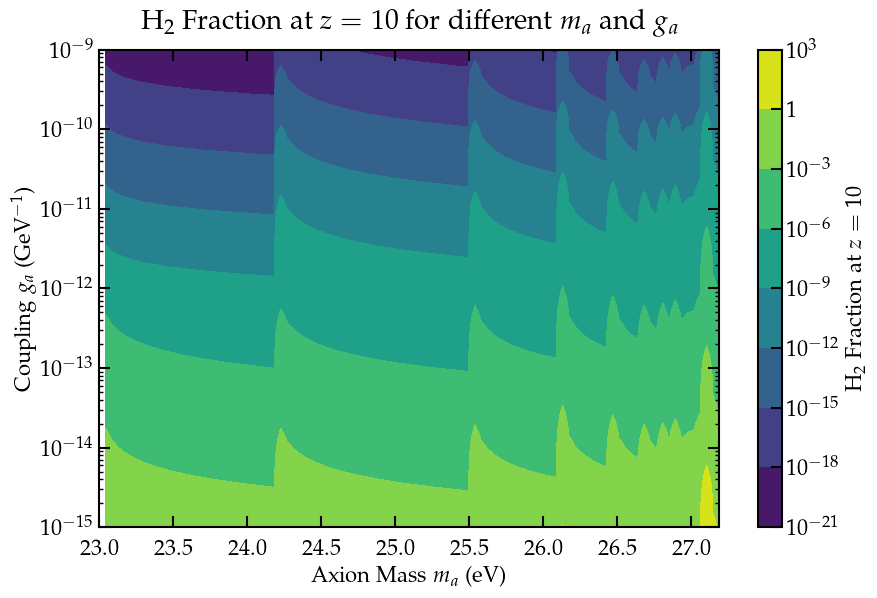

In [244]:
# Define meshgrid
X, Y =np.meshgrid(ma_toy, ga_toy)

# Plotting the contour
plt.figure(figsize=(10, 6.2))
ax = plt.gca()

contour = plt.contourf(X, Y ,h2_frac_space, 
                       norm=LogNorm(),
                       levels=50, 
                       cmap="viridis")

cbar = plt.colorbar(contour)

ax.set_yscale('log')

cbar.set_label(r"H$_2$ Fraction at $z=10$")
plt.xlabel(r"Axion Mass $m_a$ (eV)")
plt.ylabel(r"Coupling $g_a$ (GeV$^{-1}$)")
plt.title(r"H$_2$ Fraction at $z=10$ for different $m_a$ and $g_a$")

# Save the plot 
plt.savefig('./plots/xH2_z20_scan.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [245]:
# Define toy results

# Get Boolean answers for exclusion region 
DCBH_toy_20 = h2_frac_space < crit_H2_toy(20,9)

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/2144823418.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  contour = plt.contourf(X, Y ,DCBH_toy_20,


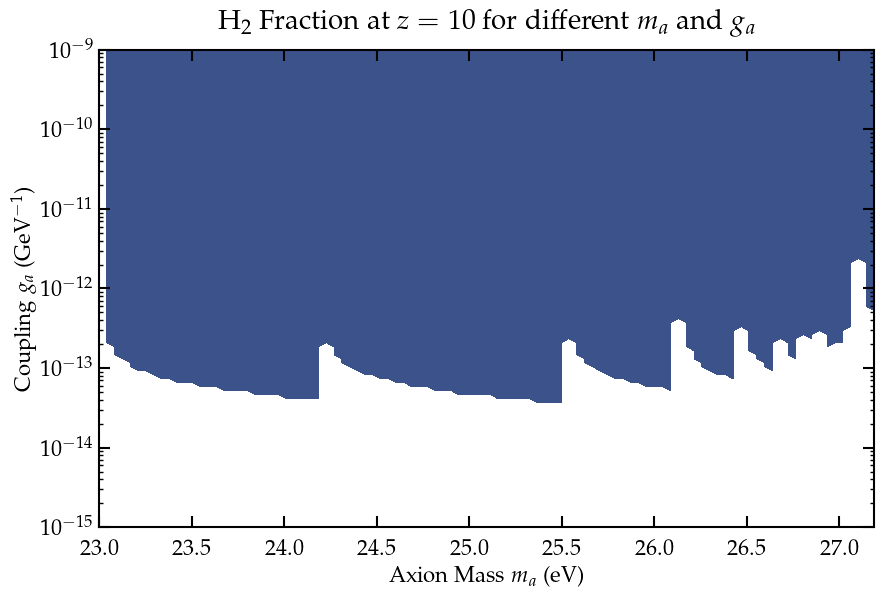

In [246]:
# Define meshgrid
X, Y =np.meshgrid(ma_toy, ga_toy)

# Plotting the contour
plt.figure(figsize=(10, 6.2))
ax = plt.gca()

contour = plt.contourf(X, Y ,DCBH_toy_20, 
                       norm=LogNorm(),
                       levels=50, 
                       cmap="viridis")


ax.set_yscale('log')

cbar.set_label(r"H$_2$ Fraction at $z=10$")
plt.xlabel(r"Axion Mass $m_a$ (eV)")
plt.ylabel(r"Coupling $g_a$ (GeV$^{-1}$)")
plt.title(r"H$_2$ Fraction at $z=10$ for different $m_a$ and $g_a$")

# Save the plot 
plt.savefig('./plots/xH2_z20_scan.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

Generate plots at different redshifts for Hubble time criteria. 

In [247]:
# Based on the toy model now I want to show which axion parameters will satisfy ACH criteria at higher redshifts. 

# Define axion mass range 
# create a grid for valies 
ma_toy = 2*np.linspace(11.5, 13.595, 400)

# Create a grid for ga gamma space
ga_toy = 10**np.linspace(-15, -9, 120)

X, Y =np.meshgrid(ma_toy, ga_toy)

In [248]:
# Define different grids for different redshifts 

Toy_20 = np.zeros((len(ga_toy), len(ma_toy)) )
Toy_30 = np.zeros((len(ga_toy), len(ma_toy)) )
Toy_40 = np.zeros((len(ga_toy), len(ma_toy)) )

In [249]:
# Generate H2 fractions at different redshifts 

# Extract the value at z=10 for each (ma, ga) combination
for j, ga in enumerate(ga_toy):
    for i, ma in enumerate(ma_toy):
        try:
            # Assuming results[j, i] gives the solution array for (ma, ga)
            Toy_20[j, i] = xH2_eq (20, ma, ga)
            Toy_30[j, i] = xH2_eq (30, ma, ga)
            Toy_40[j, i] = xH2_eq (40, ma, ga)
        except IndexError:
            # Handle cases where results are incomplete
            print(f"Skipping invalid result at ma={ma}, ga={ga}")


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/2652840475.py:21: RuntimeWarning: divide by zero encountered in divide
  xh2_eq = H2_form / pd_term / lw_term
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/361699769.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Toy_20[j, i] = xH2_eq (20, ma, ga)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/361699769.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Toy_30[j, i] = xH2_eq (30, ma, ga)
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/361699769.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a sca

In [250]:
ACH_20 = Toy_20 < crit_H2_toy(20,9)
ACH_20_ff = Toy_20 < crit_H2_toy(20,1)

ACH_30 = Toy_30 < crit_H2_toy(30,9)


ACH_40 = Toy_40 < crit_H2_toy(40,9)
ACH_40_ff = Toy_40 < crit_H2_toy(40,1)


/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/4169420262.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Y ,ACH_40,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/4169420262.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Y ,ACH_20,


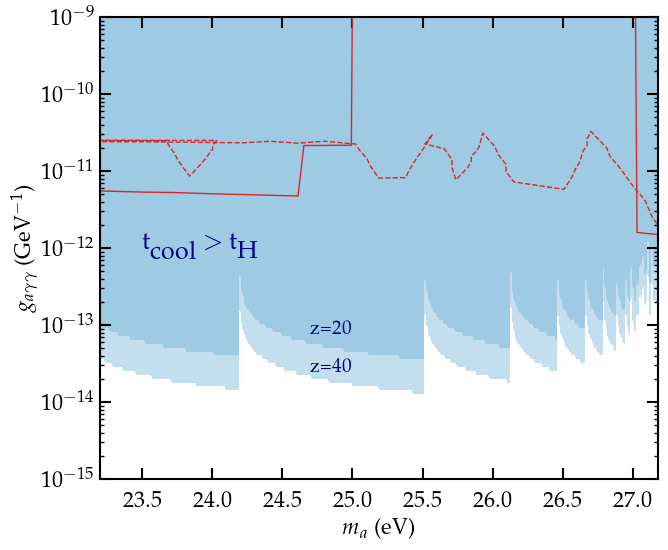

In [251]:
# Plot for Hubble cooling

# Define meshgrid
X, Y =np.meshgrid(ma_toy, ga_toy)

# Plotting the contour
plt.figure(figsize=(7.2, 6.0))
ax = plt.gca()

# Plot z=40 results
plt.contourf(X, Y ,ACH_40, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)


plt.contourf(X, Y ,ACH_20, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)

# Add other axion bounds
plt.plot(ma_bound_list, ga_bound_list, linewidth=1, color=default_colors[3])

# Add CMB bounds 
plt.plot(CMB_bounds.iloc[0], CMB_bounds_ga_list, linewidth=1, linestyle='dashed', color=default_colors[3])


ax.set_yscale('log')

cbar.set_label(r"H$_2$ Fraction at $z=10$")
plt.xlabel(r"$m_a$ (eV)")
plt.ylabel(r"$g_{a \gamma \gamma}$ (GeV$^{-1}$)")

plt.xlim(2*11.6, 2*13.59)
plt.ylim(1e-15,1e-9)

plt.text(23.5, 1e-12, r't$_\textnormal{cool}$ $>$ t$_\textnormal{H}$', fontsize=18, color='darkblue')

plt.text(24.7, 0.8e-13, r'z=20', fontsize=14, color='darkblue')
plt.text(24.7, 2.5e-14, r'z=40', fontsize=14, color='darkblue')

# Save the plot 
plt.savefig('./plots/ACH_Hubble.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/1259943212.py:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Y ,ACH_40_ff,
/var/folders/1s/743cth097qq_y5bzsg5_vhwm0000gn/T/ipykernel_57837/1259943212.py:17: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(X, Y ,ACH_20_ff,


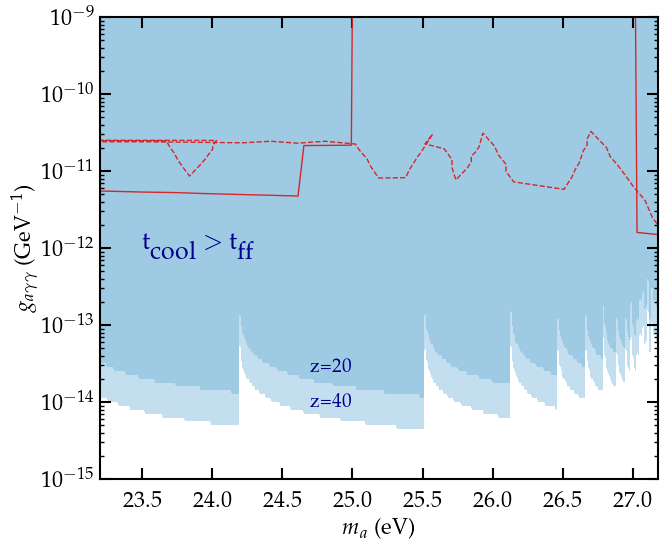

In [252]:
# Plot for Hubble cooling

# Define meshgrid
X, Y =np.meshgrid(ma_toy, ga_toy)

# Plotting the contour
plt.figure(figsize=(7.2, 6.0))
ax = plt.gca()

# Plot z=40 results
plt.contourf(X, Y ,ACH_40_ff, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)


plt.contourf(X, Y ,ACH_20_ff, 
                       norm=LogNorm(), 
                       cmap='Blues', 
                       alpha=0.4)

# Add other axion bounds
plt.plot(ma_bound_list, ga_bound_list, linewidth=1, color=default_colors[3])

# Add CMB bounds 
plt.plot(CMB_bounds.iloc[0], CMB_bounds_ga_list, linewidth=1, linestyle='dashed', color=default_colors[3])


ax.set_yscale('log')

cbar.set_label(r"H$_2$ Fraction at $z=10$")
plt.xlabel(r"$m_a$ (eV)")
plt.ylabel(r"$g_{a \gamma \gamma}$ (GeV$^{-1}$)")

plt.xlim(2*11.6, 2*13.59)
plt.ylim(1e-15,1e-9)

plt.text(23.5, 1e-12, r't$_\textnormal{cool}$ $>$ t$_\textnormal{ff}$', fontsize=18, color='darkblue')

plt.text(24.7, 2.5e-14, r'z=20', fontsize=14, color='darkblue')
plt.text(24.7, 9e-15, r'z=40', fontsize=14, color='darkblue')

# Save the plot 
plt.savefig('./plots/ACH_ff.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

## Toy critical curve for atomic cooling halos

This section produces a toy critical curve for atomic cooling halos as in opposition to the monolthic collapse case. 

In [253]:
# Define critical curve by Wolcott Green 2011 
def cc_Wolcott(kpd):

    # Define fit parameters 
    A = 9.05 
    B = 0.95 
    C = 1.6e-6 
    D = 0.3 

    val_1 = 10**(-A) / ( 1 + kpd/C )**D 
    val_2 = np.exp(- B * kpd / C)

    return val_1*val_2 

In [254]:
# Define Yang Luo Critical curve 
def cc_Luo(kpd): 

    # Define DCBH parameters for Halo C and lambda_jeans,25 
    a = 3.2e-8
    b = 3.1e-7
    c = -3.1 

    return a * (1 + kpd/b)**(c)

In [255]:
# Define critical curve function for atomic cooling halos

def k_LW_toy_cc (z, si, kpd): 

    # Define quantities for toy model 
    n = 1 # gas density 
    temp = 1e+4 # Temperature 
    xe = 2e-4 # free electron fraction 

    # Define critical H2 fraction using time scales 
    xH2_crit = crit_H2_toy(z, si)

    # H2 formation term 
    form = phys.C_Hminus(temp) * xe * n 

    # Photodetachment term 
    pd_term = 1 + kpd / (phys.C_H2 (temp) * n )

    return form/pd_term/xH2_crit

In [256]:
# Define dumb critical curve for monolithic collapse 

def cc_dumb (kpd): 
    
    # Define quantities for toy model 
    n = 3e+3 # gas density 
    temp = 8e+3 # Temperature 
    xe = 1e-4 # free electron fraction 

    # Define critical H2 fraction using Omukai 2001
    xH2_crit = 1e-6 

    # H2 formation term 
    form = phys.C_Hminus(temp) * xe * n 

    # Photodetachment term 
    pd_term = 1 + kpd / (phys.C_H2 (1e+4) * n )

    return form/pd_term/xH2_crit


In [257]:
# Draw a parameteric plot for decaying axions 
z_list = np.linspace(10,100)

kpd_toy = k_pd(z_list, 25,1e-11)
klw_toy = k_LW(z_list, 25,1e-11)

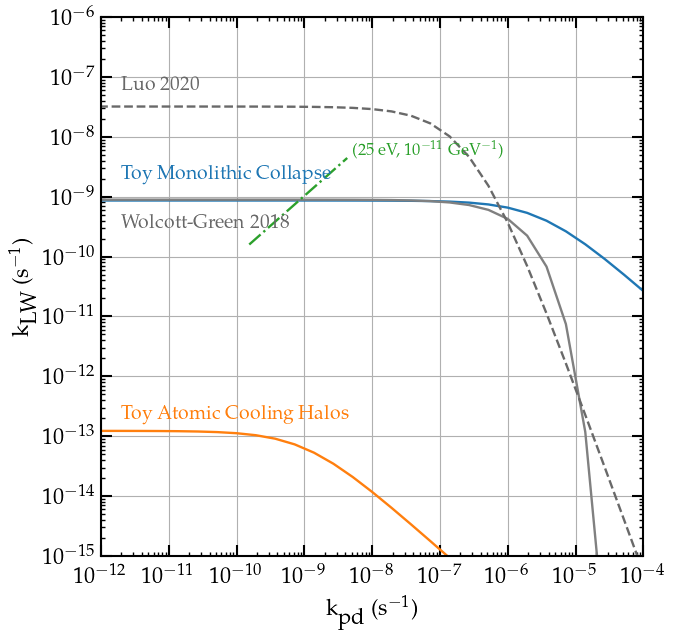

In [258]:
# Plot the results 
kpd_list = 10**np.linspace(-18, -4)

plt.figure(figsize=(7, 7))
plt.loglog()

# Plot the dumb critical curve 
plt.plot(kpd_list, cc_dumb(kpd_list) , label=r'Toy monolithic collapse')

# Plot Wolcott:2011 Critical Curve
plt.plot(kpd_list, cc_Wolcott(kpd_list), color='gray',
         label=r'Wolcott-Green 2018 ($\lambda_\textnormal{Jeans,25}$)')

# Plot Luo:2020 Critical Curve 
plt.plot(kpd_list, cc_Luo(kpd_list), color='dimgray', linestyle='dashed',
         label=r'Luo 2020 ($\lambda_\textnormal{sob}$)')

# Plot curve for ACH cooling 
plt.plot ( kpd_list, k_LW_toy_cc(15, 9, kpd_list), label=r'Toy atomic cooling halos' )

# Plot parameteric plot for a decaying axion 
plt.plot(kpd_toy, klw_toy, linestyle='dashdot')

plt.xlim(1e-12,1e-4)
plt.ylim(1e-15, 1e-6)

# plt.legend()

plt.xlabel(r'k$_\textnormal{pd}$ (s$^{-1}$)')
plt.ylabel(r'k$_\textnormal{LW}$ (s$^{-1}$)')

plt.grid()


# Add Texts 
plt.text(2e-12, 2e-13, 'Toy Atomic Cooling Halos',
         fontsize=14, color=default_colors[1])

plt.text(2e-12, 2e-9, 'Toy Monolithic Collapse', 
        fontsize=14, color=default_colors[0])

plt.text (2e-12, 6e-8, r'Luo 2020', 
         fontsize=14, color='dimgrey')

plt.text(2e-12, 3e-10, r'Wolcott-Green 2018', 
        fontsize=14, color='dimgrey')

plt.text(5e-9, 5e-9, r'(25 eV, 10$^{-11}$ GeV$^{-1}$)', color= default_colors[2], fontsize=12)


# Save the plot 
plt.savefig('./plots/Critical_Curves.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [259]:
k_LW_toy_cc ( 15, 9, 10**np.linspace(-10,-1) )

array([1.12330705e-13, 1.07439569e-13, 1.00743763e-13, 9.19926147e-14,
       8.12230172e-14, 6.89090922e-14, 5.59592920e-14, 4.34853666e-14,
       3.24455939e-14, 2.33839298e-14, 1.63947016e-14, 1.12583078e-14,
       7.61612169e-15, 5.09844396e-15, 3.38859068e-15, 2.24126298e-15,
       1.47760349e-15, 9.72048554e-16, 6.38557631e-16, 4.19087893e-16,
       2.74879537e-16, 1.80220373e-16, 1.18127221e-16, 7.74141634e-17,
       5.07272430e-17, 3.32375942e-17, 2.17769272e-17, 1.42675583e-17,
       9.34745891e-18, 6.12394782e-18, 4.01204200e-18, 2.62843286e-18,
       1.72197412e-18, 1.12811987e-18, 7.39065881e-19, 4.84184168e-19,
       3.17203306e-19, 2.07809129e-19, 1.36141774e-19, 8.91903980e-20,
       5.84311913e-20, 3.82799483e-20, 2.50782900e-20, 1.64295051e-20,
       1.07634385e-20, 7.05143612e-21, 4.61959726e-21, 3.02643012e-21,
       1.98270082e-21, 1.29892393e-21])

In [260]:
k_LW_toy_cc(15, 9, kpd_list) 

array([1.22964667e-13, 1.22964667e-13, 1.22964667e-13, 1.22964666e-13,
       1.22964666e-13, 1.22964664e-13, 1.22964661e-13, 1.22964655e-13,
       1.22964645e-13, 1.22964624e-13, 1.22964583e-13, 1.22964505e-13,
       1.22964355e-13, 1.22964064e-13, 1.22963503e-13, 1.22962420e-13,
       1.22960328e-13, 1.22956290e-13, 1.22948495e-13, 1.22933447e-13,
       1.22904404e-13, 1.22848371e-13, 1.22740332e-13, 1.22532277e-13,
       1.22132576e-13, 1.21368205e-13, 1.19919181e-13, 1.17217236e-13,
       1.12330705e-13, 1.03963074e-13, 9.08911392e-14, 7.31365865e-14,
       5.31075941e-14, 3.47395506e-14, 2.08300629e-14, 1.17482281e-14,
       6.37874458e-15, 3.38859068e-15, 1.77874099e-15, 9.27763795e-16,
       4.82287019e-16, 2.50272527e-16, 1.29755329e-16, 6.72406476e-17,
       3.48363060e-17, 1.80458410e-17, 9.34745891e-18, 4.84167010e-18,
       2.50777837e-18, 1.29891022e-18])

## Dark Matter Annihilation in the core

In [261]:
# Calculate J factor

def J_fac(z, mhalo): 

    # Define halo concentration parameter
    ch = 4 

    # Define NFW density parameter in msol/pc^3
    rho0 = mhalo * ch**3 / (4 * np.pi * phys.Rvir(z, mhalo)**3 * (np.log(1 + ch) - ch/(1+ch) ) )

    # Convert density parameter to eV/cm^3 
    rho0 = rho0 * phys.msol_to_grams * phys.cs**2 /phys.eV_to_ergs / phys.pc_to_cm**3

    # Here r_min is set to 1e-4 pc 
    # Define integrand 
    def integrand (x):  
        return 1 / x**2 / (1+x)**4 

    # Define bounds of integration 
    a = 1e-4 * ch / phys.Rvir(z, mhalo) 
    b = ch 

    # Define integrals 
    def integr(x):

        val_1 = 12*x**3 + 30*x**2 + 22*x +3 
        val_2 = 3 * x * (1+x)**3 
        val_3 = 4*np.log(x / (1+x))

        return val_1 / val_2 + val_3

    return rho0**2 * phys.Rvir(z, mhalo) * phys.pc_to_cm * (integr (a) - integr(b) ) / ch 


In [262]:
J_fac (20,1e+6) / 1e+18

np.float64(1.9673861645234455e+29)

In [263]:
J_fac (30,1e+6) / 1e+18

np.float64(9.341926983992277e+29)

In [264]:
12.5 * 1e-9 * 3.2e-28

4.0000000000000004e-36

In [265]:
# Estimate J internal for annihilating dark matter 
# Define cross sections
sv = 4e-36 # cm^3 s^(-1)
dNdE_ave = 0.952 # eV^(-1) 
mchi = 12.5 # dark matter mass in eV

In [266]:
(12.4 * phys.eV_to_ergs * phys.h_planck * 
 sv * dNdE_ave * J_fac (15, 4.33e+7) / 
 mchi**2 / 4 / np.pi )

np.float64(1.3027743407246342e-16)

In [267]:
100 * phys.Omega_b*phys.h**2

2.24

In [268]:
(0.45 * 0.1) / (0.9) * np.log(1e+9/1e+4)

np.float64(0.5756462732485115)

## Jeans Mass and Accretion Rate 

In [269]:
50 * (1e+16)**(-1/2) * (6e+3)**(3/2)

0.23237900077244503

In [270]:
# Define sound speed 

def cs(T): 
    
    val = phys.kB * T / 1.22 / phys.mp_eV
    # Take square root 
    val = (val)**(1/2)

    return val * phys.cs


In [271]:
# Print Mass Accretion rates for atomic cooling halos. 
cs(1e+4)**3 / phys.G * phys.yrs_to_sec / phys.msol_to_grams

0.1322233472220089

In [636]:
1 / (12.4 * phys.eV_to_ergs)

50334753867.804184

In [638]:
4 * np.pi * 3.71e-18 * (2.42) * 1e-21 / (12.4 * phys.eV_to_ergs) / phys.h_planck

1.3731609780239178e-12

## LW Oscillator Strengths and Average Cross Section

In [735]:
# Define oscillator strength x dissociation probability for a few LW lines 

b4 = 2e-5
b7 = 5e-3
b17 = 3e-3

# Define frequencies of lines 



In [737]:
# Dissociation cross section across each line 
np.pi * phys.e_charge**2 * b7 / phys.me / phys.cs

0.0001326891325971882

In [771]:
# line width approximation 
def line_width (en, Tm, mu): 

    """ 
    H2 only 
    inputs:
        en - line energy (eV)
        Tm - matter temperature (K)
        mu - particle mass in units of H atom (dimensionless)

    output: 
        line width (Hz) 
    """

    # Define velocity width 
    delta_v = np.sqrt( 8 * np.log(2) * phys.kB * Tm / mu / phys.mp_eV ) * phys.cs 

    # multiplicative factor 
    fac = en / phys.h_planck / phys.cs

    return fac * delta_v

In [772]:
# Check H alpha
line_width (10.2, 1e+3, 1)

np.float64(55658893101.592545)

In [773]:
# Energy band gap
phys.h_planck * line_width (10.2, 1e+3, 1)

np.float64(0.00023018668619537356)

In [774]:
# Define function for average cross section 
def ave_cs (en, Tm, fnn, mu): 
    """ 
    H2 only 
    inputs:
        en - line energy (eV)
        Tm - matter temperature (K)
        fnn - oscillator strength 
        
    output: 
        average cross section across line (cm^2)
    """

    val = np.pi * phys.e_charge**2 / phys.me / phys.cs

    return val * fnn / line_width(en, Tm, mu)

In [779]:
# average cross section across H-alpha 
ave_cs(10.2, 1e+3, 0.4162, 1)

np.float64(1.9844166460927912e-13)

In [780]:
# Average cross section for H2 dissociation for several lines 
# Define list of Lyman lines 
LW_list_names = ['B3', 'B5', 'B7', 'B17']
LW_line_en = np.array([11.66, 11.96, 12.25, 13.44])
LW_line_fnn = np.array([2e-6, 5e-4, 6e-3, 3e-3])

In [781]:
# Calculate the average cross section over each line 
LW_ave_cs = np.zeros_like(LW_line_en)

for i, en in enumerate(LW_line_en):
    LW_ave_cs[i] = ave_cs(en, 1e+4,  LW_line_fnn[i], 2)

In [783]:
LW_ave_cs

array([3.73058896e-19, 9.09253078e-17, 1.06527348e-15, 4.85476197e-16])

In [804]:
4 * np.pi * 3.71e-18 * np.log(13.6 / 11.26) * 1e-21 / phys.h_planck / phys.eV_to_ergs

np.float64(1.3284954039516682e-12)

In [805]:
4 * np.pi * 3.71e-18  * 1e-21 / phys.h_planck / phys.eV_to_ergs * (13.6 - 11.26) / 12.4

1.3277672266842842e-12

In [806]:
4 * np.pi * 3.71e-18  * 1e-21 / phys.h_planck / phys.eV_to_ergs * (13.6 - 11.26) / 13.6

1.2106112949180238e-12

In [854]:
nu_b7 = 12.25 / phys.h_planck * np.sqrt(8 * np.log(2) * phys.kB * 1e+4 / phys.mp_eV / 2)

In [857]:
4 * np.pi * nu_b7 * 1.06e-15 / 12.25 / phys.eV_to_ergs * 1e-21

np.float64(1.0144362485716452e-13)

In [953]:
print(f'{phys.h_planck * phys.cs:.4e}')

1.2398e-04


In [12]:
en_bins = np.linspace(0,20,100)

(1e-18, 1e-16)

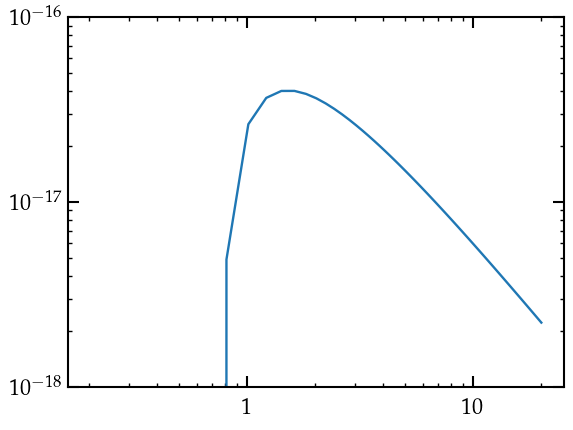

In [13]:
plt.figure()

plt.plot (en_bins, phys.sigma_Hm(en_bins))


plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-18, 1e-16)

In [957]:
1 / 0.6670

1.4992503748125936

## H2 Lyman-Werner Bands

In this part of the code, we want to do a precise calculation of H2 Lyman-Werner transitions by resolving all the available Lyman-Werner bands below the Lyman limit. 


Test. Import Lyman band for X(0,0) -> B(0,1) transitions

In [350]:
# Import Lyman-R0
Lyman_R0 = pd.read_csv('LymanWernerDataTables/Lyman-R0.tsv',
                            sep='\t', 
                           skiprows=1)

# import Lyman-R1 
Lyman_R1 = pd.read_csv('LymanWernerDataTables/Lyman-R1.tsv', 
                           sep='\t', 
                           skiprows=1)

# Import Lyman-P1 
Lyman_P1 = pd.read_csv('LymanWernerDataTables/Lyman-P1.tsv', 
                           sep='\t', 
                           skiprows=1)

# Import Werner-R0 
Werner_R0 = pd.read_csv('LymanWernerDataTables/Werner-R0.tsv', 
                       sep='\t', 
                       skiprows=1)

# Import Werner-R1
Werner_R1 = pd.read_csv('LymanWernerDataTables/Werner-R1.tsv', 
                       sep='\t',
                       skiprows=1)

# Import Werner-Q1
Werner_Q1 = pd.read_csv('LymanWernerDataTables/Werner-Q1.tsv', 
                       sep='\t', 
                       skiprows=1)

In [351]:
# Extract energy values of each line
Lyman_R0['Energy (eV)'].values

array([11.188, 11.351, 11.51 , 11.665, 11.815, 11.961, 12.103, 12.241,
       12.375, 12.506, 12.632, 12.755, 12.875, 12.99 , 13.103, 13.211,
       13.316, 13.418, 13.516])

In [328]:
# Extract f_osc x f_diss for each line
Lyman_R0['f_total'].values

array([2.46e-09, 2.05e-09, 1.38e-07, 2.68e-06, 2.98e-05, 5.04e-04,
       9.59e-04, 6.06e-03, 8.31e-03, 1.08e-02, 8.52e-03, 8.13e-03,
       6.94e-03, 7.31e-03, 4.34e-04, 5.32e-03, 5.80e-03, 3.73e-03,
       3.69e-03])

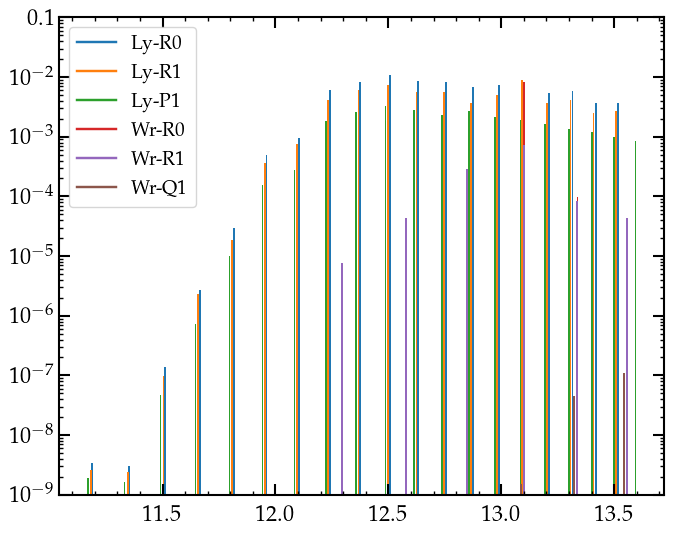

In [329]:
# Plot a bar graph 
plt.figure(figsize=(7.8,6.2))

from matplotlib.ticker import AutoMinorLocator

# ... your plotting code ...

ax = plt.gca()  # get current axis

# Set number of minor ticks between each major tick
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))  # puts 4 minor ticks between major ticks (e.g. at .1 intervals)

# Hide minor tick labels
ax.tick_params(axis='x', which='minor', labelbottom=False)

# Plot Lyman-R0 
plt.bar(Lyman_R0['Energy (eV)'].values , Lyman_R0['f_total'].values, 
        width=7.5e-3, bottom=1e-9,
         label = r'Ly-R0')

# Plot Lyman-R1 
plt.bar(Lyman_R1['Energy (eV)'].values, Lyman_R1['f_total'].values,
       width=7.5e-3, bottom=1e-9,
         label = r'Ly-R1')

# Lyman P1 
plt.bar(Lyman_P1['Energy (eV)'].values, Lyman_P1['f_total'].values, 
        width=7.5e-3, bottom=1e-9,
        label = r'Ly-R1')

# Werner R0 
plt.bar(Werner_R0['Energy (eV)'].values, Werner_R0['f_total'].values, 
        width=7.5e-3, bottom=1e-9, 
        label = r'Wr-R0')

# Werner R1 
plt.bar(Werner_R1['Energy (eV)'].values, Werner_R1['f_total'].values, 
        width=7.5e-3, bottom=1e-9, 
        label = r'Wr-R1')

# Werner Q1 
plt.bar(Werner_Q1['Energy (eV)'].values, Werner_Q1['f_total'].values, 
        width=7.5e-3, bottom=1e-9, 
        label = r'Wr-Q1')


# Create custom legends with Lyman and Werner bands
custom_handles = [
    Line2D([0], [0], color=default_colors[0], lw=1.75, label=r'Ly-R0'),
    Line2D([0], [0], color=default_colors[1], lw=1.75, label=r'Ly-R1'),
    Line2D([0], [0], color=default_colors[2], lw=1.75, label=r'Ly-P1'),
    Line2D([0], [0], color=default_colors[3], lw=1.75, label=r'Wr-R0'),
    Line2D([0], [0], color=default_colors[4], lw=1.75, label=r'Wr-R1'),
    Line2D([0], [0], color=default_colors[5], lw=1.75, label=r'Wr-Q1'),
]

plt.yscale('log')
plt.ylim(1e-9,1e-1) 
plt.legend(handles=custom_handles)


plt.show()

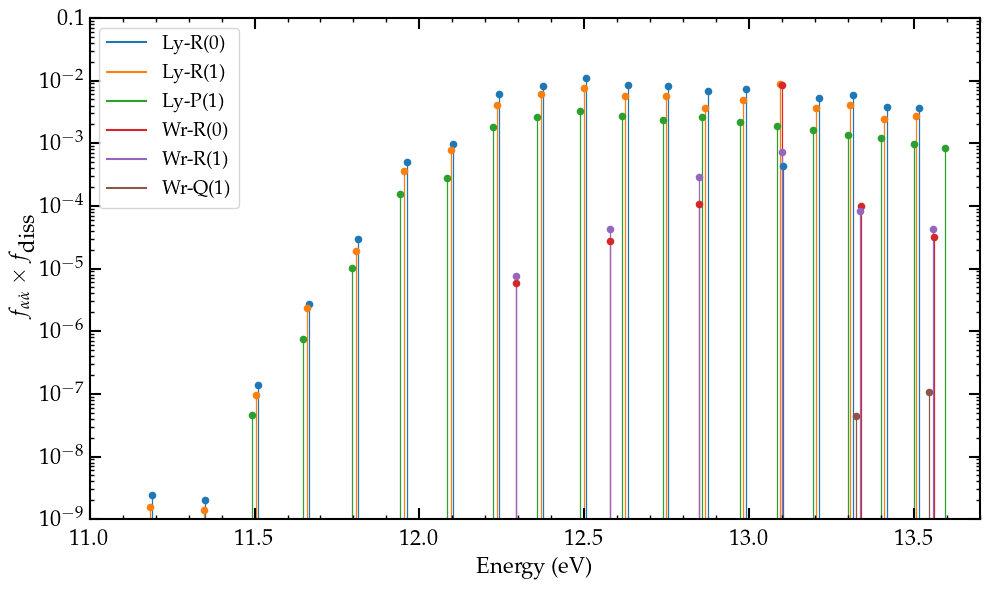

In [330]:
# Define plotting colors
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Start plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Helper function for lollipop plotting
def plot_lollipop(df, label, color, zorder=1):
    x = df['Energy (eV)'].values
    y = df['f_total'].values
    plt.vlines(x, ymin=1e-10, ymax=y, color=color, linewidth=0.9, zorder=zorder)  # "stick"
    plt.scatter(x, y, color=color, s=20, label=label, zorder=zorder+1)           # "candy"

# Plot each set
plot_lollipop(Lyman_R0, r'Ly-R(0)', default_colors[0])
plot_lollipop(Lyman_R1, r'Ly-R(1)', default_colors[1])
plot_lollipop(Lyman_P1, r'Ly-P(1)', default_colors[2])
plot_lollipop(Werner_R0, r'Wr-R(0)', default_colors[3])
plot_lollipop(Werner_R1, r'Wr-R(1)', default_colors[4])
plot_lollipop(Werner_Q1, r'Wr-Q(1)', default_colors[5])

# Customize plot
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.set_xlim(11.0, 13.7)
ax.set_xlabel('Energy (eV)', fontsize=16)
ax.set_ylabel(r'$f_{\alpha \dot{\alpha}} \times f_{\textnormal{diss}}$', fontsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.tick_params(axis='x', which='minor', labelbottom=False)


# Custom legend
custom_handles = [
    Line2D([0], [0], color=default_colors[0], lw=1.5, label=r'Ly-R(0)'),
    Line2D([0], [0], color=default_colors[1], lw=1.5, label=r'Ly-R(1)'),
    Line2D([0], [0], color=default_colors[2], lw=1.5, label=r'Ly-P(1)'),
    Line2D([0], [0], color=default_colors[3], lw=1.5, label=r'Wr-R(0)'),
    Line2D([0], [0], color=default_colors[4], lw=1.5, label=r'Wr-R(1)'),
    Line2D([0], [0], color=default_colors[5], lw=1.5, label=r'Wr-Q(1)'),
]
plt.legend(handles=custom_handles)


plt.tight_layout()

plt.savefig('plots/Lyman-Werner.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()


In [331]:
phys.h_planck * phys.cs

0.0001239841984055037

In [332]:
(137**3 * 3 * 3e+6 / 2 / 0.411*2)**(-1)

1.775978119949562e-14

In [333]:
2 / 3 / 2.14e+10

3.115264797507788e-11

In [334]:
print(f'{3 * 3.115e-11 * 3e+6 / 0.411**2:.2e}')

1.66e-03
